#### import dependencies

In [1]:
import numpy as np
from libpysal.weights import lat2W, Kernel
from numpy.linalg import inv
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from spglm.iwls import _compute_betas_gwr, iwls
from spglm.family import Gaussian
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessRegressor
from statsmodels.api import OLS
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.diagnostics import get_AICc
import libpysal as ps  # Ensure PySAL is installed
from libpysal.weights import DistanceBand, lat2W, Kernel
import geopandas as gpd
from shapely.geometry import Point, Polygon
import pandas as pd
from scipy.stats import pearsonr

from numpy.linalg import inv

import warnings
warnings.filterwarnings('ignore')

In [2]:
## Define autocorrelation function. 

def draw_map(N, lamb, W):
    """
    N    = number of areal units
    lamb = spatial autocorrelation parameter
    W    = spatial weights matrix
    """

    W.transform = "r"
    e = np.random.random((N, 1))
    u = inv(np.eye(N) - lamb * W.full()[0])
    u = np.dot(u, e)
    u = (u - u.mean()) / np.std(u)
    return u

# Define function to create tract polygons over the area
def create_tracts(xmin, xmax, ymin, ymax, x_step, y_step):
    polys = []
    ids = []
    id_counter = 0
    for x0 in np.arange(xmin, xmax, x_step):
        for y0 in np.arange(ymin, ymax, y_step):
            x1 = x0 + x_step
            y1 = y0 + y_step
            poly = Polygon([(x0, y0), (x1, y0), (x1, y1), (x0, y1)])
            polys.append(poly)
            ids.append(id_counter)
            id_counter += 1
    gdf = gpd.GeoDataFrame({'tract_id': ids, 'geometry': polys})
    return gdf

# Define grid parameters and create tracts
xmin, xmax = 0, 600
ymin, ymax = 0, 600

# This is the step where I choose the size of the tracts
x_step, y_step = 12.5, 12.5 # Creates a 48x48 grid, resulting in 2304 tracts
tracts_gdf48 = create_tracts(xmin, xmax, ymin, ymax, x_step, y_step)

orig_tracts_gdf48 = create_tracts(xmin, xmax, ymin, ymax, x_step, y_step) # this is important as its used in 16x16 visualiation

-  Simulation of X
    - In this current experiment:
      - rho = 0.80
      - Total of 3600 points with 2000 clustered and 1600 background points.
      - Number of clusters = 15

In [3]:
def simulate_clustered_S1(num_points, background_points, num_clusters, grid_gdf, cluster_std=50, random_state=None):
   
    if random_state is not None:
        np.random.seed(random_state)

    x_range = (grid_gdf.total_bounds[0], grid_gdf.total_bounds[2])
    y_range = (grid_gdf.total_bounds[1], grid_gdf.total_bounds[3])

    centers = np.random.uniform(low=x_range[0], high=x_range[1], size=(num_clusters, 2))
    clustered_locations, _ = make_blobs(n_samples=num_points, centers=centers, cluster_std=cluster_std)

    # Clip points to stay within the study area
    clustered_locations[:, 0] = np.clip(clustered_locations[:, 0], x_range[0], x_range[1])
    clustered_locations[:, 1] = np.clip(clustered_locations[:, 1], y_range[0], y_range[1])

    background_locations = np.random.uniform(low=[x_range[0], y_range[0]],
                                             high=[x_range[1], y_range[1]],
                                             size=(background_points, 2))

    # Step 4: Combine All Points
    all_locations = np.vstack((clustered_locations, background_locations))

    ## Generate data
    Nlat = 48
    N = Nlat**2
    D = 2
    M = 3
    W = lat2W(Nlat, Nlat, rook=True)

    rawX1 = draw_map(N, .80, W).flatten()

    # newX = (rawX1-rawX1.min()) / (rawX1.max()-rawX1.min()) #* (7000 - 250) + 250 
    
    x = all_locations[:, 0]
    y = all_locations[:, 1]
    S1 = []
    cell_size = 600 / Nlat  # 12.5 in this case
    S1 = []
    for i in range(len(all_locations)):
        u = min(int(np.floor(x[i] / cell_size)), Nlat - 1)
        v = min(int(np.floor(y[i] / cell_size)), Nlat - 1)
        S1.append(rawX1[u * Nlat + v])

    return np.array(S1), np.array(all_locations)

# Run Simulation with Ensured Coverage
S1, loc1  = simulate_clustered_S1(num_points=2000, background_points=1600, num_clusters=15, grid_gdf=tracts_gdf48,
                                 cluster_std=25, random_state=27)

S2 = tracts_gdf48
loc2 = np.array([[point.x, point.y] for point in S2.geometry.centroid])

- Visualizing the spatial Distribution of X

- Next, generating the spatially varying coefficient surface (beta)

<Figure size 1000x800 with 0 Axes>

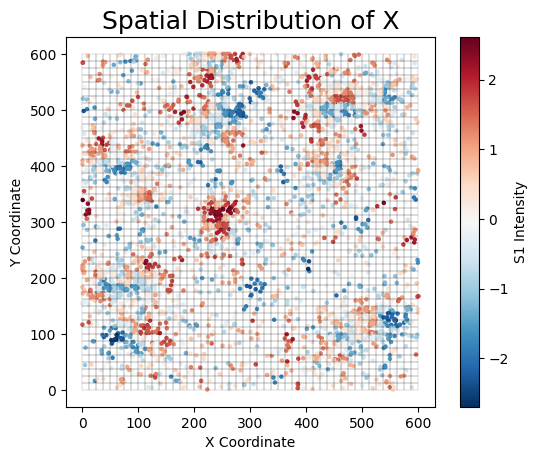

In [4]:
plt.figure(figsize=(10, 8))
tracts_gdf48.boundary.plot(edgecolor="black", linewidth=0.1)  # Plot grid boundaries

# Set colormap to "RdBu_r" 
cmap = plt.cm.RdBu_r

# Scatter plot with diverging colormap
sc = plt.scatter(loc1[:, 0], loc1[:, 1], c=S1, cmap=cmap, edgecolor="face", s=5)

# Add Colorbar
plt.colorbar(sc, label="S1 Intensity")

# Labels and Title
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("Spatial Distribution of X", fontsize=18)

plt.show()

<Figure size 1000x800 with 0 Axes>

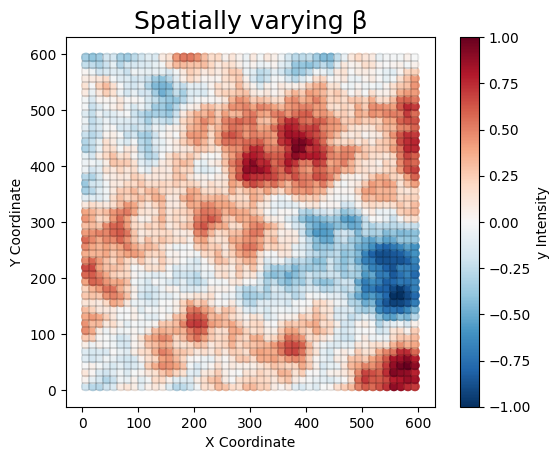

In [5]:
## Generate beta
Nlat = 48
N = Nlat**2

W = lat2W(Nlat, Nlat, rook=True)

np.random.seed(2025)
beta_surface = draw_map(N, 0.98, W)

beta_surface_scaled = 2 * (beta_surface - beta_surface.min()) / (beta_surface.max() - beta_surface.min()) - 1

plt.figure(figsize=(10, 8))
tracts_gdf48.boundary.plot(edgecolor="black", linewidth=0.1)  # Plot grid boundaries

# Set colormap to "RdBu_r" (reversed Red-Blue to match the desired effect)
cmap = plt.cm.RdBu_r

# # Scatter plot with diverging colormap
sc = plt.scatter(loc2[:, 0], loc2[:, 1], c=beta_surface_scaled, cmap=cmap, edgecolor=None)

# Add Colorbar
plt.colorbar(sc, label="y Intensity")

# Labels and Title
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("Spatially varying β", fontsize=18)

plt.show()

##### To generate the y, in the notebook we are setting the value of k (which determines the number of nearest neighbors of y in X to smooth from) to 2, 25, 250, and 500. Starting from k=2

## K = 2

- Generate the y

- Visualize the spatial distribution of smoothed X with k neighbors

- Visualized the spatial distribution of y 

In [6]:
B = beta_surface_scaled.flatten()

nbrs_S2 = NearestNeighbors(n_neighbors=2).fit(loc1)

smoothed_S1_to_S2 = np.zeros(len(S2))

for i in range(len(S2)):
    distances_S1_to_S2, indices_S1_to_S2 = nbrs_S2.kneighbors([loc2[i]])
    smoothed_S1_to_S2[i] = np.mean(S1[indices_S1_to_S2[0]].flatten())


np.random.seed(26)

error_term = np.random.normal(0, 0.01, len(S2))

y_orig = B * smoothed_S1_to_S2 + error_term

<Figure size 1000x800 with 0 Axes>

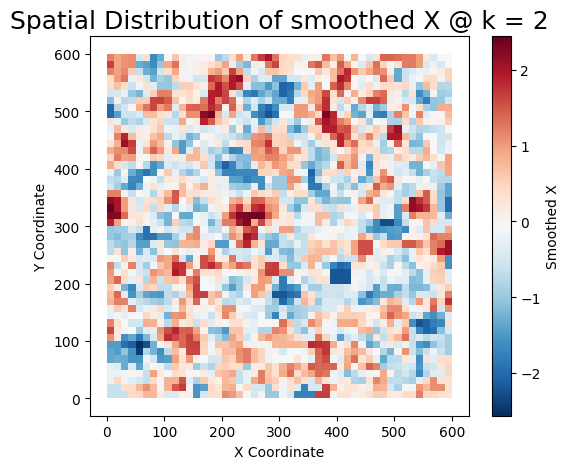

In [7]:
plt.figure(figsize=(10, 8))

# Assign smoothed values
tracts_gdf48['sX'] = smoothed_S1_to_S2

# Plot the choropleth map
ax = tracts_gdf48.plot(
    column="sX",
    cmap=plt.cm.RdBu_r,
    edgecolor="face",
    linewidth=0,
    legend=False
)

# Create scalar mappable for colorbar
norm = mcolors.Normalize(
    vmin=tracts_gdf48["sX"].min(),
    vmax=tracts_gdf48["sX"].max()
)
sm = cm.ScalarMappable(norm=norm, cmap=plt.cm.RdBu_r)
sm._A = []  # workaround to enable colorbar for ScalarMappable

# Add colorbar to the plot
cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("Smoothed X")

# Add labels and title
ax.set_xlabel("X Coordinate")
ax.set_ylabel("Y Coordinate")
ax.set_title("Spatial Distribution of smoothed X @ k = 2", fontsize=18)

plt.tight_layout()

<Figure size 1000x800 with 0 Axes>

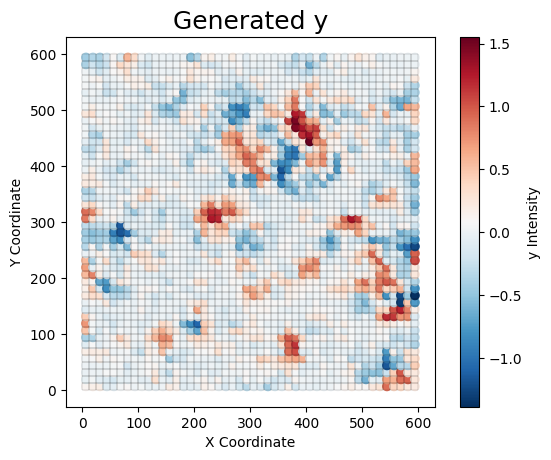

In [8]:
plt.figure(figsize=(10, 8))
tracts_gdf48.boundary.plot(edgecolor="black", linewidth=0.1)  # Plot grid boundaries

# Set colormap to "RdBu_r" (reversed Red-Blue to match the desired effect)
cmap = plt.cm.RdBu_r

# # Scatter plot with diverging colormap
sc = plt.scatter(loc2[:, 0], loc2[:, 1], c=y_orig, cmap=cmap, edgecolor=None)

# Add Colorbar
plt.colorbar(sc, label="y Intensity")

# Labels and Title
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("Generated y", fontsize=18)

plt.show()

##### Run GLASS at different values of K to test its sensitivity

- Visualize the metrics at the different K. R2, SRMSE, AICc

In [9]:
r2_list = []
srmse_list = []
bw_list = []
aicc_list = []

part1 = list(range(2, 11, 1))
part2 = list(range(15, 101, 5))
part3 = list(range(125, 1001, 25))

# Combine all parts
k_values = part1 + part2 + part3

# k_values = [2,3,4,5,6,7,8,9,10, 25, 50,100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1250, 1500, 1750, 2000, 2250]

for k in k_values:
    # --- 1. Smooth point-level X (S1) to polygon-level (S2 centroids) ---
    nbrs_S1 = NearestNeighbors(n_neighbors=k).fit(loc1)  # loc1 = point locations
    smoothed_S1_to_S2 = np.zeros(len(loc2))  # loc2 = tract centroids
    
    for i in range(len(loc2)):
        distances_S1_to_S2, indices_S1_to_S2 = nbrs_S1.kneighbors([loc2[i]])
        bw_S1 = distances_S1_to_S2[0][-1]
        weights_X = np.exp(-0.5 * (distances_S1_to_S2[0] / bw_S1) ** 2)
        local_X = S1[indices_S1_to_S2[0]]  # S1 = point-level X
        smoothed_S1_to_S2[i] = np.sum(local_X * weights_X) / np.sum(weights_X)
    
    # --- 3. Fit GWR at polygon level ---
    coords = loc2  # tract centroids
    X_design = smoothed_S1_to_S2.reshape(-1,1)
    y_design = y_orig.reshape(-1,1)
    
    bw = Sel_BW(coords, y_design, X_design, constant=False).search(bw_min=2)
    gwr_model = GWR(coords, y_design, X_design, bw, constant=False)
    gwr_results = gwr_model.fit()
    
    # --- 4. Extract metrics ---
    y_pred = gwr_results.predy.flatten()
    r2 = r2_score(y_orig, y_pred)
    srmse = np.sqrt(mean_squared_error(y_orig, y_pred)) / np.std(y_orig)
    aicc = gwr_results.aicc
    
    r2_list.append(r2)
    srmse_list.append(srmse)
    bw_list.append(bw)
    aicc_list.append(aicc)
    
    print(f"k={k}: R2={r2:.4f}, SRMSE={srmse:.4f}, AICc={aicc:.4f}, BW={bw:.4f}")

k=2: R2=0.9860, SRMSE=0.1183, AICc=-5476.4999, BW=6.0000
k=3: R2=0.9176, SRMSE=0.2870, AICc=-3360.4820, BW=10.0000
k=4: R2=0.8655, SRMSE=0.3667, AICc=-2478.2101, BW=14.0000
k=5: R2=0.8034, SRMSE=0.4434, AICc=-1967.0796, BW=22.0000
k=6: R2=0.7770, SRMSE=0.4722, AICc=-1683.0219, BW=22.0000
k=7: R2=0.7500, SRMSE=0.5000, AICc=-1441.5828, BW=24.0000
k=8: R2=0.7288, SRMSE=0.5207, AICc=-1244.4021, BW=22.0000
k=9: R2=0.7089, SRMSE=0.5395, AICc=-1085.7369, BW=22.0000
k=10: R2=0.6937, SRMSE=0.5534, AICc=-970.7092, BW=22.0000
k=15: R2=0.6231, SRMSE=0.6139, AICc=-511.9118, BW=25.0000
k=20: R2=0.6485, SRMSE=0.5929, AICc=-314.9671, BW=15.0000
k=25: R2=0.6342, SRMSE=0.6048, AICc=-231.3728, BW=15.0000
k=30: R2=0.6274, SRMSE=0.6104, AICc=-185.1057, BW=15.0000
k=35: R2=0.6640, SRMSE=0.5797, AICc=-179.4782, BW=13.0000
k=40: R2=0.6715, SRMSE=0.5732, AICc=-213.0575, BW=13.0000
k=45: R2=0.6736, SRMSE=0.5713, AICc=-218.3420, BW=13.0000
k=50: R2=0.6748, SRMSE=0.5703, AICc=-220.5806, BW=13.0000
k=55: R2=0.6707

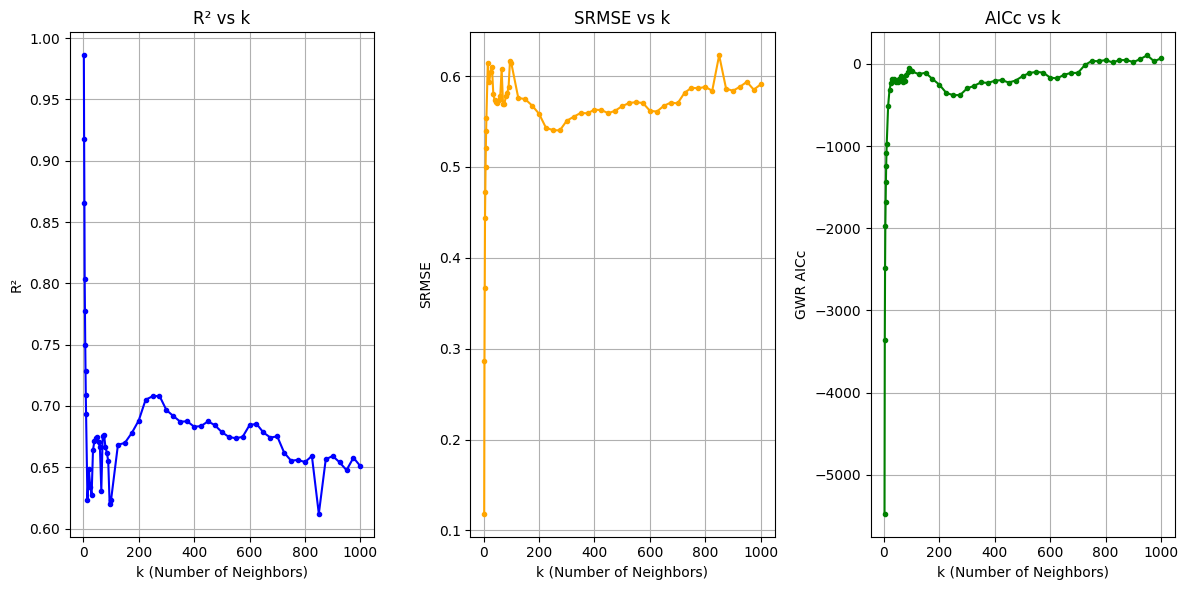

In [10]:
plt.figure(figsize=(12, 6))

# Plot R²
plt.subplot(1, 3, 1)
plt.plot(k_values, r2_list, color='blue', marker='.')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('R²')
plt.title('R² vs k')
plt.grid()

# Plot SRMSE
plt.subplot(1, 3, 2)
plt.plot(k_values, srmse_list, color='orange', marker='.')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('SRMSE')
plt.title('SRMSE vs k')
plt.grid()


# Plot AIcc
plt.subplot(1, 3, 3)
plt.plot(k_values, aicc_list, color='green', marker='.')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('GWR AICc')
plt.title('AICc vs k')
plt.grid()

plt.tight_layout()
plt.show()

### Aggregations

#### 48x48

- Create a geodataframe for X

- sjoin X points to 48x48 polygon tracts 

- Aggregate up to 48x48

- Check for and remove missing values

- Preprocess data for GWR model, X is aggregated up to 48x48, y & B are already at 48x48

- Compute GWR model metrics, R2, AICc, SRMSE

In [13]:
S1_gdf = gpd.GeoDataFrame({'X': S1, 'geometry': gpd.points_from_xy(loc1[:, 0], loc1[:, 1])})

In [14]:
# Spatial join: assign S1 points to 48x48 tracts
S1_agg = gpd.sjoin(S1_gdf, tracts_gdf48, how="left", predicate="within")

In [15]:
S1_agg = S1_agg.groupby("tract_id")["X"].mean().reset_index()
X_48x48 = tracts_gdf48.merge(S1_agg, on="tract_id", how="left")
X_48x48['y'] = y_orig

In [16]:
sX1_48 = X_48x48.copy()
sX1_48.isna().sum()

tract_id      0
geometry      0
sX            0
X           806
y             0
dtype: int64

In [17]:
sX1_48.dropna(inplace=True)
sX1_48.isna().sum()

tract_id    0
geometry    0
sX          0
X           0
y           0
dtype: int64

In [18]:
gwr_X  = sX1_48['X'].values.reshape(-1,1)
gwr_y = sX1_48['y'].values.reshape(-1, 1) # using aggregated y
coords = np.array([[point.x, point.y] for point in sX1_48['geometry'].centroid])
gwr_X.shape, gwr_y.shape

((1498, 1), (1498, 1))

In [19]:
gwr_selector = Sel_BW(coords, gwr_y, gwr_X, constant=False)
gwr_bw48 = gwr_selector.search(bw_min=2)
gwr_results = GWR(coords, gwr_y, gwr_X, gwr_bw48, constant=False).fit()
print(gwr_bw48)

14.0


In [20]:
params48 = gwr_results.params
y_pred48 = gwr_results.predy
aicc_gwr48 = gwr_results.aicc
r2_48 = gwr_results.R2

print(gwr_results.aicc), print(gwr_results.R2);

-1573.2952296577628
0.879922055531236


In [21]:
## calculating the standardized root mean squared error
y_true48 = sX1_48['y'].values.reshape(-1,1)
rmse48  = np.sqrt(np.mean((y_true48 - y_pred48)**2))
std_dev48 = np.std(y_true48)
srmse48 = rmse48 / std_dev48
srmse48, rmse48

(np.float64(0.3465226464010166), np.float64(0.11282024306025516))

#### 24x24

- Resize the tracts from 48x48 to 24x24 by adjusting the stepsize

- Sjoin X points to 24x24 polygon tracts 

- Aggregate X up to 24x24

- Also aggregate y up to 24x24

- Check for and remove missing values

- Preprocess data for GWR model

- Compute GWR model metrics, R2, AICc, SRMSE

In [22]:
x_step, y_step = 25, 25 # Creates a 24x24 grid, resulting in 576 tracts cell divisions
tracts_gdf24 = create_tracts(xmin, xmax, ymin, ymax, x_step, y_step)

loc2_24 = np.array([[point.x, point.y] for point in tracts_gdf24.geometry.centroid])

In [23]:
# X_48x48['geometry'] = X_48x48.geometry.centroid

In [24]:
# Spatial join X to 24x24 tracts
spj24_X = gpd.sjoin(S1_gdf, tracts_gdf24, how='right', predicate='within')
agg_24_X = spj24_X.groupby('tract_id')[['X']].mean().reset_index()

In [25]:
# Spatial join y @ 48x48 to 24x24 tracts. Extract only the y from the df: line 2. 
spj24_y = gpd.sjoin(X_48x48, tracts_gdf24, how='right', predicate='within')
agg_24_y = spj24_y.groupby('tract_id_right')[['y']].mean().reset_index()

In [26]:
agg_24 = agg_24_X.merge(agg_24_y, left_on='tract_id', right_on='tract_id_right').drop('tract_id', axis=1)

In [27]:
# Aggregate X & Y within each 24x24 grid cell
GWR_24x24_gdf = tracts_gdf24.merge(agg_24, left_index=True, right_on='tract_id_right', how='left').reset_index(drop=True)

In [28]:
sX1_24 = GWR_24x24_gdf.copy()
sX1_24.isna().sum()

tract_id           0
geometry           0
X                 23
tract_id_right     0
y                  0
dtype: int64

In [29]:
sX1_24.dropna(inplace=True)
sX1_24.isna().sum()

tract_id          0
geometry          0
X                 0
tract_id_right    0
y                 0
dtype: int64

In [30]:
gwr_X  = sX1_24['X'].values.reshape(-1,1)
gwr_y = sX1_24['y'].values.reshape(-1, 1) # using aggregated y
coords = np.array([[point.x, point.y] for point in sX1_24['geometry'].centroid])
gwr_X.shape, gwr_y.shape

((553, 1), (553, 1))

In [31]:
gwr_selector = Sel_BW(coords, gwr_y, gwr_X, constant=False)
gwr_bw24 = gwr_selector.search(bw_min=2)
gwr_results = GWR(coords, gwr_y, gwr_X, gwr_bw24, constant=False).fit()
print(gwr_bw24)

11.0


In [32]:
params24 = gwr_results.params
y_pred24 = gwr_results.predy
aicc_gwr24 = gwr_results.aicc
r2_24 = gwr_results.R2

print(gwr_results.aicc), print(gwr_results.R2);

-765.5273499189606
0.8706295428928923


In [33]:
## calculating the standardized root mean squared error
y_true24 = sX1_24['y'].values.reshape(-1,1)
rmse24  = np.sqrt(np.mean((y_true24 - y_pred24)**2))
std_dev24 = np.std(y_true24)
srmse24 = rmse24 / std_dev24
srmse24, rmse24

(np.float64(0.35968104913535237), np.float64(0.09209601157845648))

#### 16x16

- Resize the tracts from 48x48 to 16x16 by adjusting the stepsize

- Sjoin X points to 16x16 polygon tracts 

- Aggregate X up to 16x16

- Also aggregate y up to 16x16

- Check for and remove missing values

- Preprocess data for GWR model

- Compute GWR model metrics, R2, AICc, SRMSE

In [34]:
x_step, y_step = 37.5, 37.5 # Creates a 32x32 grid, resulting in 576 tracts cell divisions
tracts_gdf16 = create_tracts(xmin, xmax, ymin, ymax, x_step, y_step)

loc2_16 = np.array([[point.x, point.y] for point in tracts_gdf16.geometry.centroid])

In [35]:
X_48x48['geometry'] = X_48x48.geometry.centroid

In [36]:
# Spatial join X to 16x16 tracts 
spj16_X = gpd.sjoin(S1_gdf, tracts_gdf16, how='right', predicate='within')
agg_16_X = spj16_X.groupby('tract_id')[['X']].mean().reset_index()

In [37]:
# Spatial join y @ 48x48 to 16x16 tracts. Extract only the y from the df: line 2. 
spj16_y = gpd.sjoin(X_48x48, tracts_gdf16, how='right', predicate='within')
agg_16_y = spj16_y.groupby('tract_id_right')[['y']].mean().reset_index()

In [38]:
agg_16 = agg_16_X.merge(agg_16_y, left_on='tract_id', right_on='tract_id_right').drop('tract_id', axis=1)

In [39]:
# Aggregate X & y within each 24x24 grid cell
GWR_16x16_gdf = tracts_gdf16.merge(agg_16, left_index=True, right_on='tract_id_right', how='left').reset_index(drop=True)

In [40]:
sX1_16 = GWR_16x16_gdf.copy()

gwr_X  = sX1_16['X'].values.reshape(-1,1)
gwr_y = sX1_16['y'].values.reshape(-1, 1) # using aggregated y
coords = np.array([[point.x, point.y] for point in sX1_16['geometry'].centroid])
gwr_X.shape, gwr_y.shape

((256, 1), (256, 1))

In [41]:
gwr_selector = Sel_BW(coords, gwr_y, gwr_X, constant=False)
gwr_bw16 = gwr_selector.search(bw_min=2)
gwr_results = GWR(coords, gwr_y, gwr_X, gwr_bw16, constant=False).fit()
print(gwr_bw16)

11.0


In [42]:
params16 = gwr_results.params
y_pred16 = gwr_results.predy
aicc_gwr16 = gwr_results.aicc
r2_16 = gwr_results.R2

print(gwr_results.aicc), print(gwr_results.R2);

-397.93142205398254
0.829146116071915


In [43]:
## calculating the standardized root mean squared error
y_true16 = sX1_16['y'].values.reshape(-1,1)
rmse16  = np.sqrt(np.mean((y_true16 - y_pred16)**2))
std_dev16 = np.std(y_true16)
srmse16 = rmse16 / std_dev16
srmse16, rmse16

(np.float64(0.4133447519058213), np.float64(0.08515589952941634))

#### 12x12

- Resize the tracts from 48x48 to 12x12 by adjusting the stepsize

- Sjoin X points to 12x12 polygon tracts 

- Aggregate X up to 12x12

- Also aggregate y up to 12x12

- Check for and remove missing values

- Preprocess data for GWR model

- Compute GWR model metrics, R2, AICc, SRMSE

In [44]:
# This is the step where I choose the size of the tracts 
x_step, y_step = 50, 50  # Creates a 12x12 grid, resulting in 144 tracts cell divisions
tracts_gdf12 = create_tracts(xmin, xmax, ymin, ymax, x_step, y_step)

loc2_12 = np.array([[point.x, point.y] for point in tracts_gdf12.geometry.centroid])

In [45]:
X_48x48['geometry'] = X_48x48.geometry.centroid

In [46]:
# Spatial join X to 12x12 tracts 
spj12_X = gpd.sjoin(S1_gdf, tracts_gdf12, how='right', predicate='within')
agg_12_X = spj12_X.groupby('tract_id')[['X']].mean().reset_index()

In [47]:
# Spatial join y @ 48x48 to 12x12 tracts. Extract only the y from the df: line 2. 
spj12_y = gpd.sjoin(X_48x48, tracts_gdf12, how='right', predicate='within')
agg_12_y = spj12_y.groupby('tract_id_right')[['y']].mean().reset_index()

In [48]:
agg_12 = agg_12_X.merge(agg_12_y, left_on='tract_id', right_on='tract_id_right').drop('tract_id', axis=1)

In [49]:
# Aggregate X & Y within each 24x24 grid cell
GWR_12x12_gdf = tracts_gdf12.merge(agg_12, left_index=True, right_on='tract_id_right', how='left').reset_index(drop=True)

In [50]:
sX1_12 = GWR_12x12_gdf.copy()
sX1_12.isna().sum()

tract_id          0
geometry          0
X                 0
tract_id_right    0
y                 0
dtype: int64

In [51]:
gwr_X  = sX1_12['X'].values.reshape(-1,1)
gwr_y = sX1_12['y'].values.reshape(-1, 1) # using aggregated y
coords = np.array([[point.x, point.y] for point in sX1_12['geometry'].centroid])
gwr_X.shape, gwr_y.shape

((144, 1), (144, 1))

In [52]:
gwr_selector = Sel_BW(coords, gwr_y, gwr_X, constant=False)
gwr_bw12 = gwr_selector.search(bw_min=2)
gwr_results = GWR(coords, gwr_y, gwr_X, gwr_bw12, constant=False).fit()
print(gwr_bw12)

10.0


In [53]:
params12 = gwr_results.params
y_pred12 = gwr_results.predy
aicc_gwr12 = gwr_results.aicc
r2_12 = gwr_results.R2

print(gwr_results.aicc), print(gwr_results.R2);

-219.09687965903026
0.7828808291745021


In [54]:
## calculating the standardized root mean squared error
y_true12 = sX1_12['y'].values.reshape(-1,1)
rmse12  = np.sqrt(np.mean((y_true12 - y_pred12)**2))
std_dev12 = np.std(y_true12)
srmse12 = rmse12 / std_dev12
srmse12, rmse12

(np.float64(0.46596048204273494), np.float64(0.08590318414783259))

#### 8x8

- Resize the tracts from 48x48 to 8x8 by adjusting the stepsize

- Sjoin X points to 8x8 polygon tracts 

- Aggregate X up to 8x8

- Also aggregate y up to 8x8

- Check for and remove missing values

- Preprocess data for GWR model

- Compute GWR model metrics, R2, AICc, SRMSE

In [55]:
# This is the step where I choose the size of the tracts 
x_step, y_step = 75, 75  # Creates a 8x8 grid, resulting in 256 tracts cell divisions
tracts_gdf8 = create_tracts(xmin, xmax, ymin, ymax, x_step, y_step)

loc2_8 = np.array([[point.x, point.y] for point in tracts_gdf8.geometry.centroid])

In [56]:
X_48x48['geometry'] = X_48x48.geometry.centroid

In [57]:
# Spatial join X to 8x8 tracts 
spj8_X = gpd.sjoin(S1_gdf, tracts_gdf8, how='right', predicate='within')
agg_8_X = spj8_X.groupby('tract_id')[['X']].mean().reset_index()

In [58]:
# Spatial join y @ 48x48 to 8x8 tracts. Extract only the y from the df: line 2. 
spj8_y = gpd.sjoin(X_48x48, tracts_gdf8, how='right', predicate='within')
agg_8_y = spj8_y.groupby('tract_id_right')[['y']].mean().reset_index()

In [59]:
agg_8 = agg_8_X.merge(agg_8_y, left_on='tract_id', right_on='tract_id_right').drop('tract_id', axis=1)

In [60]:
# Aggregate X & Y within each 24x24 grid cell
GWR_8x8_gdf = tracts_gdf8.merge(agg_8, left_index=True, right_on='tract_id_right', how='left').reset_index(drop=True)

In [61]:
sX1_8 = GWR_8x8_gdf.copy()
sX1_8.isna().sum()

tract_id          0
geometry          0
X                 0
tract_id_right    0
y                 0
dtype: int64

In [62]:
gwr_X  = sX1_8['X'].values.reshape(-1,1)
gwr_y = sX1_8['y'].values.reshape(-1, 1) # using aggregated y
coords = np.array([[point.x, point.y] for point in sX1_8['geometry'].centroid])
gwr_X.shape, gwr_y.shape

((64, 1), (64, 1))

In [63]:
gwr_selector = Sel_BW(coords, gwr_y, gwr_X, constant=False)
gwr_bw8 = gwr_selector.search(bw_min=2)
gwr_results = GWR(coords, gwr_y, gwr_X, gwr_bw8, constant=False).fit()
print(gwr_bw8)

20.0


In [64]:
params8 = gwr_results.params
y_pred8 = gwr_results.predy
aicc_gwr8 = gwr_results.aicc
r2_8 = gwr_results.R2

print(gwr_results.aicc), print(gwr_results.R2);

-115.45490717146967
0.4549243395639432


In [65]:
## calculating the standardized root mean squared error
y_true8 = sX1_8['y'].values.reshape(-1,1)
rmse8  = np.sqrt(np.mean((y_true8 - y_pred8)**2))
std_dev8 = np.std(y_true8)
srmse8 = rmse8 / std_dev8
srmse8, rmse8

(np.float64(0.7382923949466477), np.float64(0.08227617039322957))

#### table

In [66]:
grid_sizes = [s for s in ['48x48', '24x24', '16x16', '12x12', '8x8'] for _ in range(3)] 
metrics = ['R²', 'SRMSE', 'BW'] * 5  # Repeat R² and SRMSE for each grid size
# values = [r2_48, srmse48, r2_40, srmse40, r2_32, srmse32, r2_24, srmse24, r2_16, srmse16, r2_8, srmse8]
r2 = [r2_48, r2_24, r2_16, r2_12, r2_8]
srmse = [ srmse48, srmse24, srmse16,srmse12, srmse8]
bw = [gwr_bw48, gwr_bw24, gwr_bw16, gwr_bw12, gwr_bw8]

values = []
for i in range(5):
    values.extend([r2[i], srmse[i], bw[i]])

In [67]:
len(metrics), len(grid_sizes), len(values)


(15, 15, 15)

In [68]:
df = pd.DataFrame({
    'Metric': metrics, # Repeat each grid size for R², SRMSE, BW,
    'Grid Size': grid_sizes,
    'Value': np.round(values, 4)
})

In [69]:
# Reset index to start from 1
df.index = range(1, len(df) + 1)

# Pivot the table to get desired format
df_pivot = df.pivot(index='Metric', columns='Grid Size', values='Value')

df_pivot = df_pivot.reindex(columns=['48x48', '24x24', '16x16', '12x12', '8x8'])
# Remove the "Metric" label
df_pivot.index.name = None
df_pivot

Grid Size    48x48    24x24    16x16    12x12      8x8
BW         14.0000  11.0000  11.0000  10.0000  20.0000
R²          0.8799   0.8706   0.8291   0.7829   0.4549
SRMSE       0.3465   0.3597   0.4133   0.4660   0.7383

#### Visualizations

##### 48x48

In [70]:
loc2_48 = np.array([[point.x, point.y] for point in sX1_48.geometry.centroid])

In [71]:
sX1_48['params48'] = params48
sX1_48

tracts_gdf48_points = tracts_gdf48.copy()
tracts_gdf48_points['geometry'] = tracts_gdf48_points['geometry'].centroid
spj48_48 = gpd.sjoin(tracts_gdf48_points, sX1_48, how='left', predicate='within')
spj48_48['y'] = y_orig

tracts_gdf48["X_48x48"] = spj48_48["X"]
tracts_gdf48['y_48x48'] = spj48_48["y"]
tracts_gdf48['est_beta48'] = spj48_48["params48"]


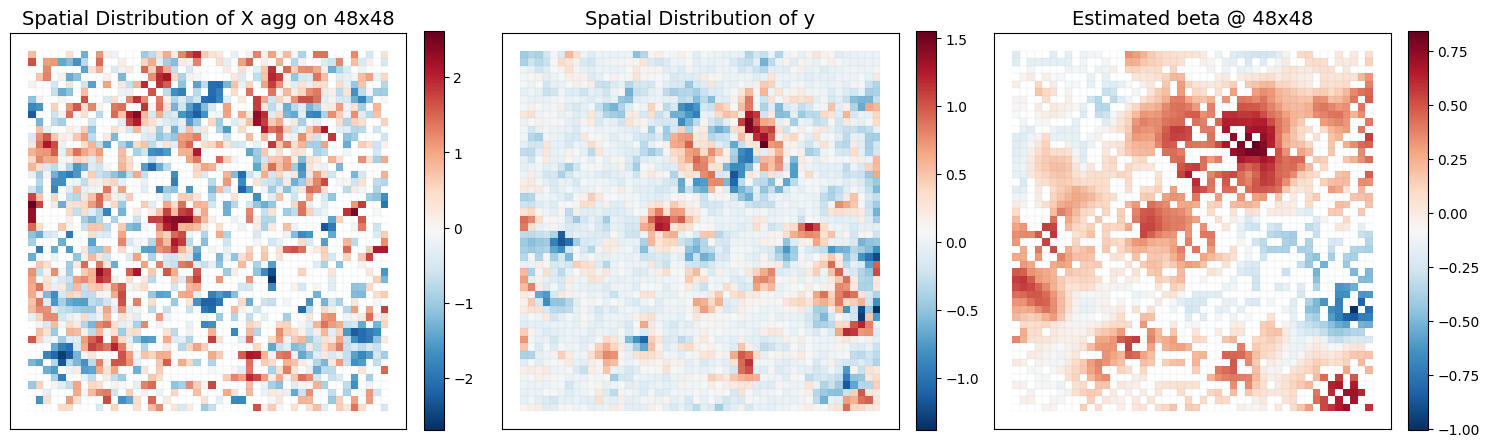

In [72]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
cmap1 = plt.cm.Reds
cmap2 = plt.cm.RdBu_r
cmap3 = plt.cm.RdBu_r

# Plot 1 - X_48x48
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[0])
plot1 = tracts_gdf48.plot(column="X_48x48", cmap=cmap2,
                          edgecolor="face", linewidth=0,
                          ax=ax[0], legend=False)
ax[0].set_title("Spatial Distribution of X agg on 48x48", fontsize=14)
ax[0].set_xticks([])
ax[0].set_yticks([])

# Colorbar for Plot 1
norm1 = mcolors.Normalize(vmin=tracts_gdf48["X_48x48"].min(), vmax=tracts_gdf48["X_48x48"].max())
sm1 = cm.ScalarMappable(cmap=cmap2, norm=norm1)
sm1.set_array([])
fig.colorbar(sm1, ax=ax[0], fraction=0.046, pad=0.04)

# Plot 2 - y_48x48
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[1])
plot2 = tracts_gdf48.plot(column="y_48x48", cmap=cmap2,
                          edgecolor="face", linewidth=0,
                          ax=ax[1], legend=False)
ax[1].set_title("Spatial Distribution of y", fontsize=14)
ax[1].set_xticks([])
ax[1].set_yticks([])

# Colorbar for Plot 2
norm2 = mcolors.Normalize(vmin=tracts_gdf48["y_48x48"].min(), vmax=tracts_gdf48["y_48x48"].max())
sm2 = cm.ScalarMappable(cmap=cmap2, norm=norm2)
sm2.set_array([])
fig.colorbar(sm2, ax=ax[1], fraction=0.046, pad=0.04)

# Plot 3 - est_beta48
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[2])
plot3 = tracts_gdf48.plot(column="est_beta48", cmap=cmap3,
                          edgecolor="face", linewidth=0,
                          ax=ax[2], legend=False)
ax[2].set_title("Estimated beta @ 48x48", fontsize=14)
ax[2].set_xticks([])
ax[2].set_yticks([])

# Colorbar for Plot 3
norm3 = mcolors.Normalize(vmin=tracts_gdf48["est_beta48"].min(), vmax=tracts_gdf48["est_beta48"].max())
sm3 = cm.ScalarMappable(cmap=cmap3, norm=norm3)
sm3.set_array([])
fig.colorbar(sm3, ax=ax[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


##### 24x24

In [73]:
sX1_24['params24'] = params24
sX1_24

tracts_gdf48_points = orig_tracts_gdf48.copy()
tracts_gdf48_points['geometry'] = tracts_gdf48_points['geometry'].centroid
spj24_48 = gpd.sjoin(tracts_gdf48_points, sX1_24, how='left', predicate='within')

In [74]:
tracts_gdf48["X_24x24"] = spj24_48["X"]
tracts_gdf48['y_24x24'] = spj24_48["y"]
tracts_gdf48['est_beta24'] = spj24_48["params24"]

In [75]:
spj24_48["X"]

0      -1.632562
1      -1.632562
2      -0.227612
3      -0.227612
4            NaN
          ...   
2299   -0.842849
2300    0.238502
2301    0.238502
2302   -0.078837
2303   -0.078837
Name: X, Length: 2304, dtype: float64

In [76]:
tracts_gdf48['est_beta24'].isna().sum()

np.int64(92)

In [77]:
# Spatial join X to 16x16 tracts 
spj16_X = gpd.sjoin(S1_gdf, tracts_gdf16, how='right', predicate='within')
agg_16_X = spj16_X.groupby('tract_id')[['X']].mean().reset_index()

In [78]:
# Spatial join y @ 48x48 to 16x16 tracts. Extract only the y from the df: line 2. 
spj16_y = gpd.sjoin(X_48x48, tracts_gdf16, how='right', predicate='within')
agg_16_y = spj16_y.groupby('tract_id_right')[['y']].mean().reset_index()

In [79]:
agg_16 = agg_16_X.merge(agg_16_y, left_on='tract_id', right_on='tract_id_right').drop('tract_id', axis=1)

In [80]:
# Aggregate X & Y within each 24x24 grid cell
GWR_16x16_gdf = tracts_gdf16.merge(agg_16, left_index=True, right_on='tract_id_right', how='left').reset_index(drop=True)

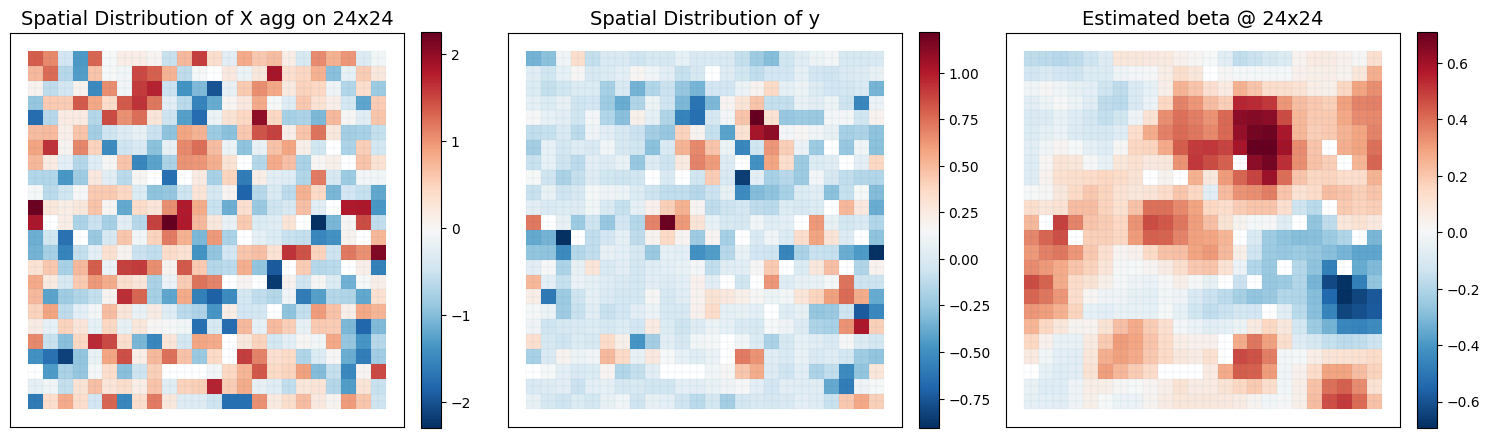

In [81]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
cmap1 = plt.cm.Reds
cmap2 = plt.cm.RdBu_r
cmap3 = plt.cm.RdBu_r

# Plot 1 - X_24x24
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[0])
plot1 = tracts_gdf48.plot(column="X_24x24", cmap=cmap2,
                          edgecolor="face", linewidth=0,
                          ax=ax[0], legend=False)
ax[0].set_title("Spatial Distribution of X agg on 24x24", fontsize=14)
ax[0].set_xticks([])
ax[0].set_yticks([])

# Colorbar for Plot 1
norm1 = mcolors.Normalize(vmin=tracts_gdf48["X_24x24"].min(), vmax=tracts_gdf48["X_24x24"].max())
sm1 = cm.ScalarMappable(cmap=cmap2, norm=norm1)
sm1.set_array([])
fig.colorbar(sm1, ax=ax[0], fraction=0.046, pad=0.04)

# Plot 2 - y_24x24
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[1])
plot2 = tracts_gdf48.plot(column="y_24x24", cmap=cmap2,
                          edgecolor="face", linewidth=0,
                          ax=ax[1], legend=False)
ax[1].set_title("Spatial Distribution of y", fontsize=14)
ax[1].set_xticks([])
ax[1].set_yticks([])

# Colorbar for Plot 2
norm2 = mcolors.Normalize(vmin=tracts_gdf48["y_24x24"].min(), vmax=tracts_gdf48["y_24x24"].max())
sm2 = cm.ScalarMappable(cmap=cmap2, norm=norm2)
sm2.set_array([])
fig.colorbar(sm2, ax=ax[1], fraction=0.046, pad=0.04)

# Plot 3 - est_beta24
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[2])
plot3 = tracts_gdf48.plot(column="est_beta24", cmap=cmap3,
                          edgecolor="face", linewidth=0,
                          ax=ax[2], legend=False)
ax[2].set_title("Estimated beta @ 24x24", fontsize=14)
ax[2].set_xticks([])
ax[2].set_yticks([])

# Colorbar for Plot 3
norm3 = mcolors.Normalize(vmin=tracts_gdf48["est_beta24"].min(), vmax=tracts_gdf48["est_beta24"].max())
sm3 = cm.ScalarMappable(cmap=cmap3, norm=norm3)
sm3.set_array([])
fig.colorbar(sm3, ax=ax[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


##### 16x16

In [82]:
sX1_16['params16'] = params16
sX1_16

tracts_gdf48_points = orig_tracts_gdf48.copy()
tracts_gdf48_points['geometry'] = tracts_gdf48_points['geometry'].centroid
spj16_48 = gpd.sjoin(tracts_gdf48_points, sX1_16, how='left', predicate='within')

In [83]:
tracts_gdf48["X_16x16"] = spj16_48["X"]
tracts_gdf48['y_16x16'] = spj16_48["y"]
tracts_gdf48['est_beta16'] = spj16_48["params16"]

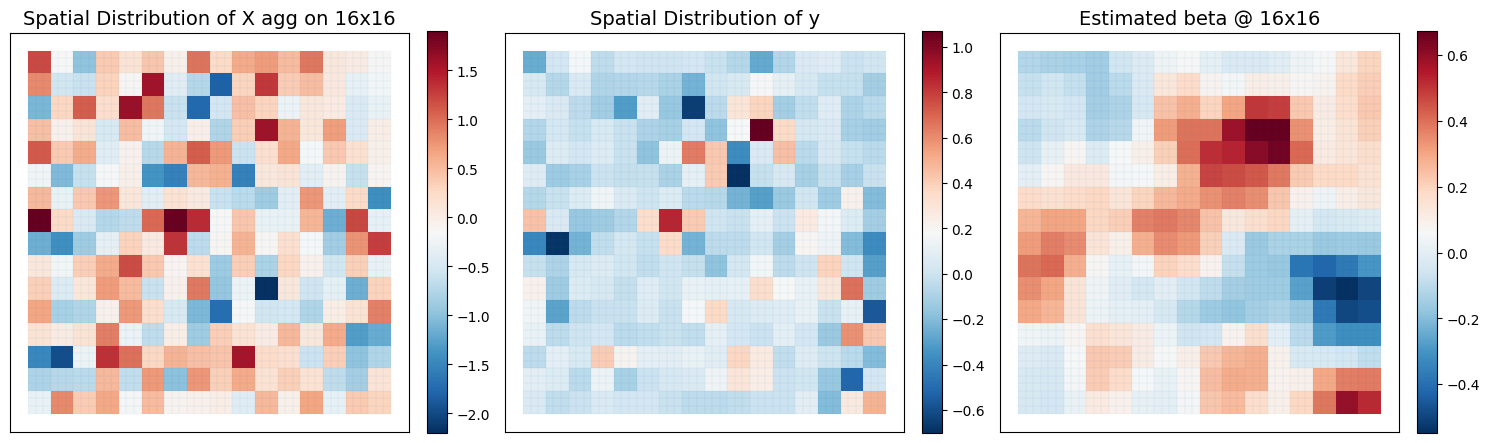

In [84]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
cmap1 = plt.cm.Reds
cmap2 = plt.cm.RdBu_r
cmap3 = plt.cm.RdBu_r

# Plot 1 - X_16x16
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[0])
plot1 = tracts_gdf48.plot(column="X_16x16", cmap=cmap2,
                          edgecolor="face", linewidth=0,
                          ax=ax[0], legend=False)
ax[0].set_title("Spatial Distribution of X agg on 16x16", fontsize=14)
ax[0].set_xticks([])
ax[0].set_yticks([])

# Colorbar for Plot 1
norm1 = mcolors.Normalize(vmin=tracts_gdf48["X_16x16"].min(), vmax=tracts_gdf48["X_16x16"].max())
sm1 = cm.ScalarMappable(cmap=cmap2, norm=norm1)
sm1.set_array([])
fig.colorbar(sm1, ax=ax[0], fraction=0.046, pad=0.04)

# Plot 2 - y_16x16
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[1])
plot2 = tracts_gdf48.plot(column="y_16x16", cmap=cmap2,
                          edgecolor="face", linewidth=0,
                          ax=ax[1], legend=False)
ax[1].set_title("Spatial Distribution of y", fontsize=14)
ax[1].set_xticks([])
ax[1].set_yticks([])

# Colorbar for Plot 2
norm2 = mcolors.Normalize(vmin=tracts_gdf48["y_16x16"].min(), vmax=tracts_gdf48["y_16x16"].max())
sm2 = cm.ScalarMappable(cmap=cmap2, norm=norm2)
sm2.set_array([])
fig.colorbar(sm2, ax=ax[1], fraction=0.046, pad=0.04)

# Plot 3 - est_beta16
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[2])
plot3 = tracts_gdf48.plot(column="est_beta16", cmap=cmap3,
                          edgecolor="face", linewidth=0,
                          ax=ax[2], legend=False)
ax[2].set_title("Estimated beta @ 16x16", fontsize=14)
ax[2].set_xticks([])
ax[2].set_yticks([])

# Colorbar for Plot 3
norm3 = mcolors.Normalize(vmin=tracts_gdf48["est_beta16"].min(), vmax=tracts_gdf48["est_beta16"].max())
sm3 = cm.ScalarMappable(cmap=cmap3, norm=norm3)
sm3.set_array([])
fig.colorbar(sm3, ax=ax[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


##### 12x12

In [85]:
sX1_12['params12'] = params12
sX1_12

tracts_gdf48_points = orig_tracts_gdf48.copy()
tracts_gdf48_points['geometry'] = tracts_gdf48_points['geometry'].centroid
spj12_48 = gpd.sjoin(tracts_gdf48_points, sX1_12, how='left', predicate='within')

In [86]:
tracts_gdf48["X_12x12"] = spj12_48["X"]
tracts_gdf48['y_12x12'] = spj12_48["y"]
tracts_gdf48['est_beta12'] = spj12_48["params12"]

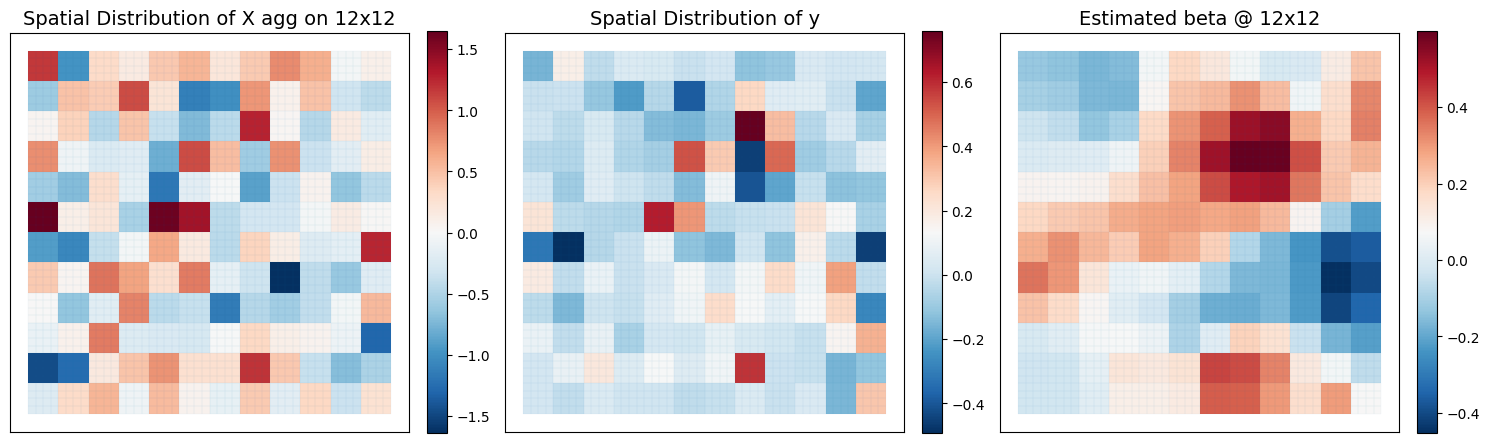

In [87]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
cmap1 = plt.cm.Reds
cmap2 = plt.cm.RdBu_r
cmap3 = plt.cm.RdBu_r

# Plot 1 - X_12x12
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[0])
plot1 = tracts_gdf48.plot(column="X_12x12", cmap=cmap2,
                          edgecolor="face", linewidth=0,
                          ax=ax[0], legend=False)
ax[0].set_title("Spatial Distribution of X agg on 12x12", fontsize=14)
ax[0].set_xticks([])
ax[0].set_yticks([])

# Colorbar for Plot 1
norm1 = mcolors.Normalize(vmin=tracts_gdf48["X_12x12"].min(), vmax=tracts_gdf48["X_12x12"].max())
sm1 = cm.ScalarMappable(cmap=cmap2, norm=norm1)
sm1.set_array([])
fig.colorbar(sm1, ax=ax[0], fraction=0.046, pad=0.04)

# Plot 2 - y_12x12
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[1])
plot2 = tracts_gdf48.plot(column="y_12x12", cmap=cmap2,
                          edgecolor="face", linewidth=0,
                          ax=ax[1], legend=False)
ax[1].set_title("Spatial Distribution of y", fontsize=14)
ax[1].set_xticks([])
ax[1].set_yticks([])

# Colorbar for Plot 2
norm2 = mcolors.Normalize(vmin=tracts_gdf48["y_12x12"].min(), vmax=tracts_gdf48["y_12x12"].max())
sm2 = cm.ScalarMappable(cmap=cmap2, norm=norm2)
sm2.set_array([])
fig.colorbar(sm2, ax=ax[1], fraction=0.046, pad=0.04)

# Plot 3 - est_beta12
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[2])
plot3 = tracts_gdf48.plot(column="est_beta12", cmap=cmap3,
                          edgecolor="face", linewidth=0,
                          ax=ax[2], legend=False)
ax[2].set_title("Estimated beta @ 12x12", fontsize=14)
ax[2].set_xticks([])
ax[2].set_yticks([])

# Colorbar for Plot 3
norm3 = mcolors.Normalize(vmin=tracts_gdf48["est_beta12"].min(), vmax=tracts_gdf48["est_beta12"].max())
sm3 = cm.ScalarMappable(cmap=cmap3, norm=norm3)
sm3.set_array([])
fig.colorbar(sm3, ax=ax[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


##### 8x8

In [88]:
sX1_8['params8'] = params8

tracts_gdf48_points = orig_tracts_gdf48.copy()
tracts_gdf48_points['geometry'] = tracts_gdf48_points['geometry'].centroid
spj8_48 = gpd.sjoin(tracts_gdf48_points, sX1_8, how='left', predicate='within')

In [89]:
tracts_gdf48["X_8x8"] = spj8_48["X"]
tracts_gdf48['y_8x8'] = spj8_48["y"]
tracts_gdf48['est_beta8'] = spj8_48["params8"]

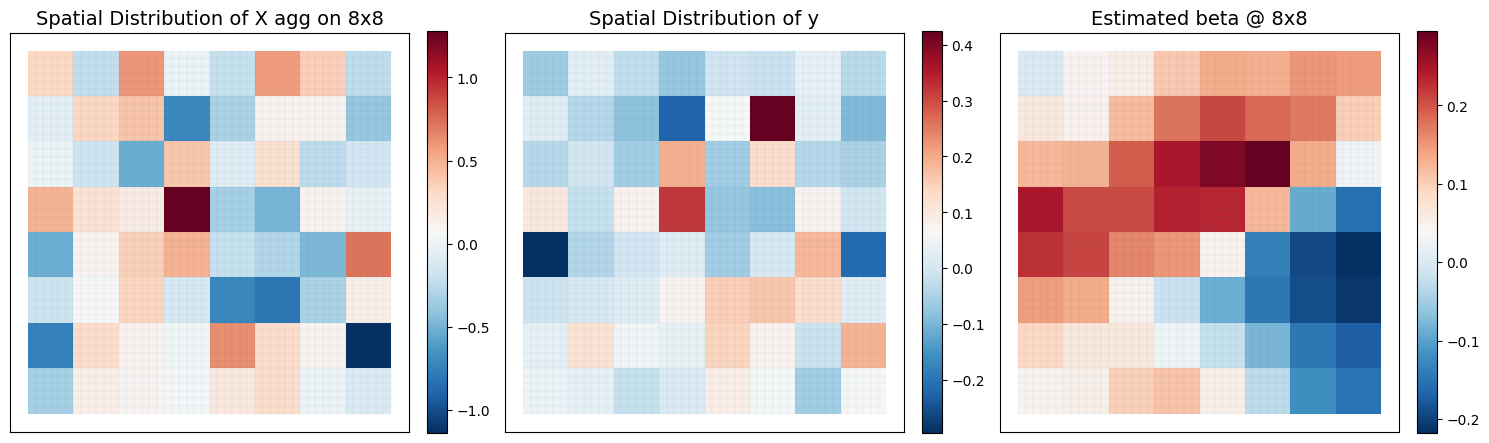

In [90]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
cmap1 = plt.cm.Reds
cmap2 = plt.cm.RdBu_r
cmap3 = plt.cm.RdBu_r

# Plot 1 - X_8x8
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[0])
plot1 = tracts_gdf48.plot(column="X_8x8", cmap=cmap2,
                          edgecolor="face", linewidth=0,
                          ax=ax[0], legend=False)
ax[0].set_title("Spatial Distribution of X agg on 8x8", fontsize=14)
ax[0].set_xticks([])
ax[0].set_yticks([])

# Colorbar for Plot 1
norm1 = mcolors.Normalize(vmin=tracts_gdf48["X_8x8"].min(), vmax=tracts_gdf48["X_8x8"].max())
sm1 = cm.ScalarMappable(cmap=cmap2, norm=norm1)
sm1.set_array([])
fig.colorbar(sm1, ax=ax[0], fraction=0.046, pad=0.04)

# Plot 2 - y_8x8
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[1])
plot2 = tracts_gdf48.plot(column="y_8x8", cmap=cmap2,
                          edgecolor="face", linewidth=0,
                          ax=ax[1], legend=False)
ax[1].set_title("Spatial Distribution of y", fontsize=14)
ax[1].set_xticks([])
ax[1].set_yticks([])

# Colorbar for Plot 2
norm2 = mcolors.Normalize(vmin=tracts_gdf48["y_8x8"].min(), vmax=tracts_gdf48["y_8x8"].max())
sm2 = cm.ScalarMappable(cmap=cmap2, norm=norm2)
sm2.set_array([])
fig.colorbar(sm2, ax=ax[1], fraction=0.046, pad=0.04)

# Plot 3 - est_beta8
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[2])
plot3 = tracts_gdf48.plot(column="est_beta8", cmap=cmap3,
                          edgecolor="face", linewidth=0,
                          ax=ax[2], legend=False)
ax[2].set_title("Estimated beta @ 8x8", fontsize=14)
ax[2].set_xticks([])
ax[2].set_yticks([])

# Colorbar for Plot 3
norm3 = mcolors.Normalize(vmin=tracts_gdf48["est_beta8"].min(), vmax=tracts_gdf48["est_beta8"].max())
sm3 = cm.ScalarMappable(cmap=cmap3, norm=norm3)
sm3.set_array([])
fig.colorbar(sm3, ax=ax[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


#### General Vizualization

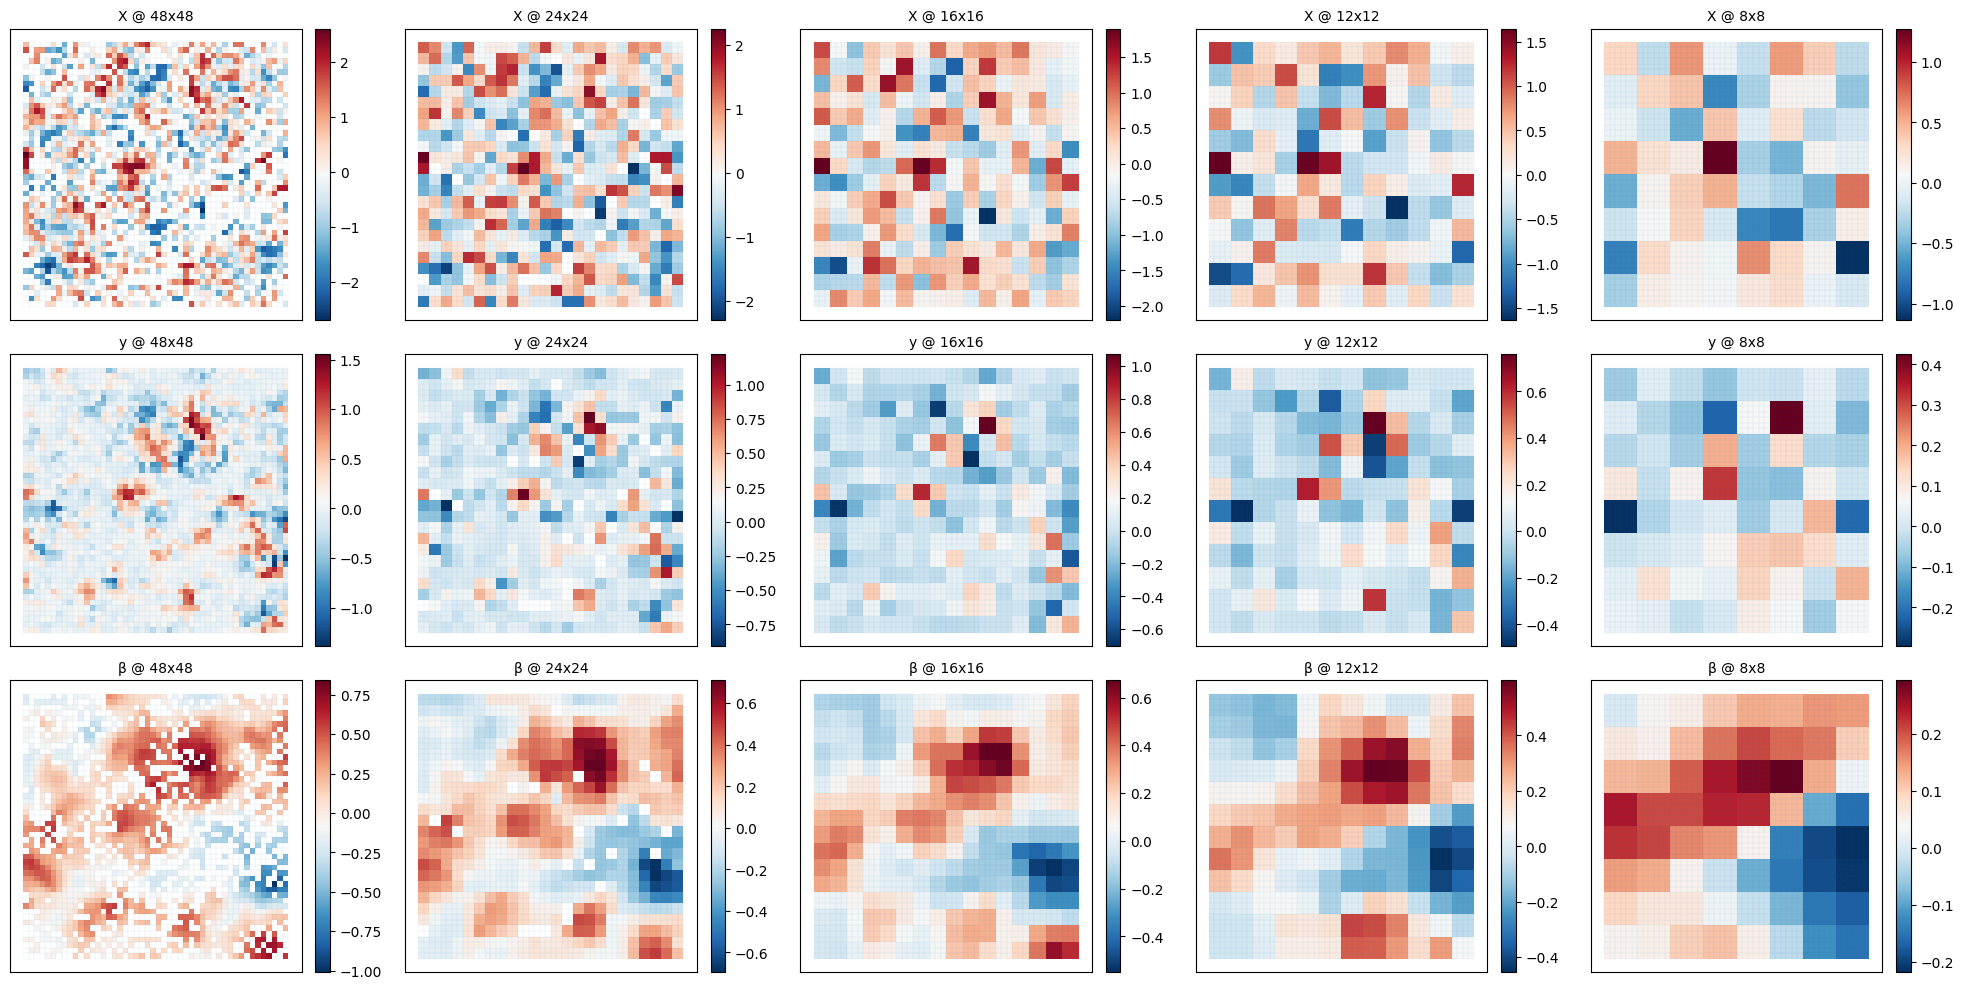

In [94]:
res_labels = ["48x48", "24x24", "16x16", "12x12", "8x8"]
x_cols = ["X_48x48", "X_24x24", "X_16x16", "X_12x12", "X_8x8"]
y_cols = ["y_48x48", "y_24x24", "y_16x16", "y_12x12", "y_8x8"]
beta_cols = ["est_beta48", "est_beta24", "est_beta16", "est_beta12", "est_beta8"]
titles = ["X", "y", "β"]
cmap = plt.cm.RdBu_r

# Create a 3x5 grid
fig, axes = plt.subplots(3, 5, figsize=(20, 10))

# Loop through each row (X, y, β) and each column (resolutions)
for row, cols in enumerate([x_cols, y_cols, beta_cols]):
    for col, colname in enumerate(cols):
        ax = axes[row, col]
        
        # Base map (light boundary layer)
        tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax)
        
        # Choropleth plot
        tracts_gdf48.plot(column=colname, cmap=cmap, edgecolor="face", linewidth=0, ax=ax, legend=False)
        
        # Normalize for consistent colorbar
        norm = mcolors.Normalize(vmin=tracts_gdf48[colname].min(), vmax=tracts_gdf48[colname].max())
        sm = cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        fig.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
        
        # Title and layout tweaks
        ax.set_title(f"{titles[row]} @ {res_labels[col]}", fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])

plt.tight_layout()
plt.show()

## K = 25

In [96]:
# Define grid parameters and create tracts
xmin, xmax = 0, 600
ymin, ymax = 0, 600

# This is the step where I choose the size of the tracts 
x_step, y_step = 12.5, 12.5 # Creates a 48x48 grid, resulting in 2304 tracts
tracts_gdf48 = create_tracts(xmin, xmax, ymin, ymax, x_step, y_step)

orig_tracts_gdf48 = create_tracts(xmin, xmax, ymin, ymax, x_step, y_step)

In [97]:
B = beta_surface_scaled.flatten()

nbrs_S2 = NearestNeighbors(n_neighbors=25).fit(loc1)

smoothed_S1_to_S2 = np.zeros(len(S2))

for i in range(len(S2)):
    distances_S1_to_S2, indices_S1_to_S2 = nbrs_S2.kneighbors([loc2[i]])
    smoothed_S1_to_S2[i] = np.mean(S1[indices_S1_to_S2[0]].flatten())


np.random.seed(26)

error_term = np.random.normal(0, 0.01, len(S2))

y_orig = B * smoothed_S1_to_S2 + error_term

<Figure size 1000x800 with 0 Axes>

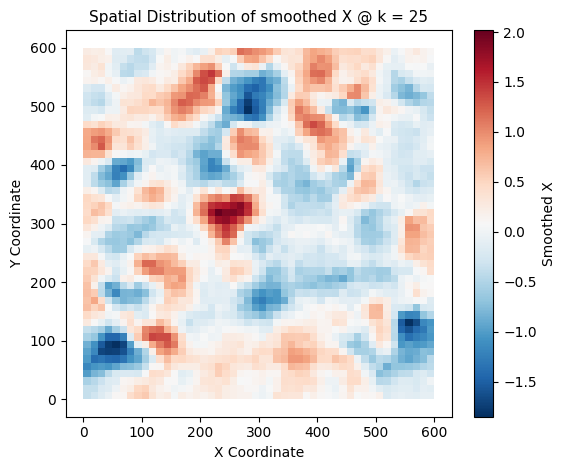

In [98]:
plt.figure(figsize=(10, 8))

# Assign smoothed values
tracts_gdf48['sX'] = smoothed_S1_to_S2

# Plot the choropleth map
ax = tracts_gdf48.plot(
    column="sX",
    cmap=plt.cm.RdBu_r,
    edgecolor="face",
    linewidth=0,
    legend=False
)

# Create scalar mappable for colorbar
norm = mcolors.Normalize(
    vmin=tracts_gdf48["sX"].min(),
    vmax=tracts_gdf48["sX"].max()
)
sm = cm.ScalarMappable(norm=norm, cmap=plt.cm.RdBu_r)
sm._A = []  # workaround to enable colorbar for ScalarMappable

# Add colorbar to the plot
cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("Smoothed X")

# Add labels and title
ax.set_xlabel("X Coordinate")
ax.set_ylabel("Y Coordinate")
ax.set_title("Spatial Distribution of smoothed X @ k = 25", fontsize=11)

plt.tight_layout()


<Figure size 1000x800 with 0 Axes>

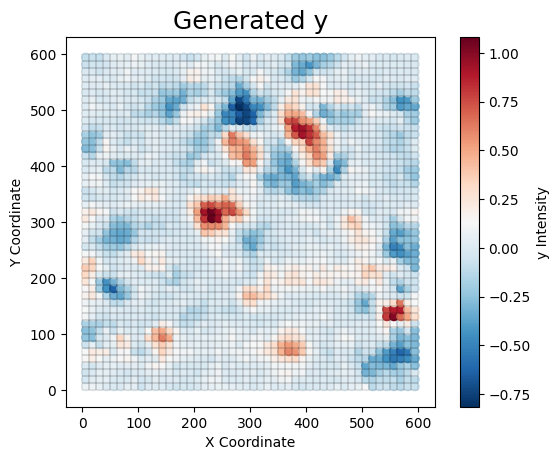

In [99]:
plt.figure(figsize=(10, 8))
tracts_gdf48.boundary.plot(edgecolor="black", linewidth=0.1)  # Plot grid boundaries

# Set colormap to "RdBu_r" (reversed Red-Blue to match the desired effect)
cmap = plt.cm.RdBu_r

# # Scatter plot with diverging colormap
sc = plt.scatter(loc2[:, 0], loc2[:, 1], c=y_orig, cmap=cmap, edgecolor=None)

# Add Colorbar
plt.colorbar(sc, label="y Intensity")

# Labels and Title
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("Generated y", fontsize=18)

plt.show()

In [100]:
r2_list = []
srmse_list = []
bw_list = []
aicc_list = []

part1 = list(range(2, 11, 1))
part2 = list(range(15, 101, 5))
part3 = list(range(125, 1001, 25))

k_values = part1 + part2 + part3

for k in k_values:
    # --- 1. Smooth point-level X (S1) to polygon-level (S2 centroids) ---
    nbrs_S1 = NearestNeighbors(n_neighbors=k).fit(loc1)  # loc1 = point locations
    smoothed_S1_to_S2 = np.zeros(len(loc2))  # loc2 = tract centroids
    
    for i in range(len(loc2)):
        distances_S1_to_S2, indices_S1_to_S2 = nbrs_S1.kneighbors([loc2[i]])
        bw_S1 = distances_S1_to_S2[0][-1]
        weights_X = np.exp(-0.5 * (distances_S1_to_S2[0] / bw_S1) ** 2)
        local_X = S1[indices_S1_to_S2[0]]  # S1 = point-level X
        smoothed_S1_to_S2[i] = np.sum(local_X * weights_X) / np.sum(weights_X)
    
    # --- 3. Fit GWR at polygon level ---
    coords = loc2  # tract centroids
    X_design = smoothed_S1_to_S2.reshape(-1,1)
    y_design = y_orig.reshape(-1,1)
    
    bw = Sel_BW(coords, y_design, X_design, constant=False).search(bw_min=2)
    gwr_model = GWR(coords, y_design, X_design, bw, constant=False)
    gwr_results = gwr_model.fit()
    
    # --- 4. Extract metrics ---
    y_pred = gwr_results.predy.flatten()
    r2 = r2_score(y_orig, y_pred)
    srmse = np.sqrt(mean_squared_error(y_orig, y_pred)) / np.std(y_orig)
    aicc = gwr_results.aicc
    
    r2_list.append(r2)
    srmse_list.append(srmse)
    bw_list.append(bw)
    aicc_list.append(aicc)
    
    print(f"k={k}: R2={r2:.4f}, SRMSE={srmse:.4f}, AICc={aicc:.4f}, BW={bw:.4f}")

k=2: R2=0.6609, SRMSE=0.5823, AICc=-3083.0587, BW=25.0000
k=3: R2=0.7339, SRMSE=0.5159, AICc=-3292.9611, BW=18.0000
k=4: R2=0.7535, SRMSE=0.4965, AICc=-3507.7456, BW=20.0000
k=5: R2=0.7693, SRMSE=0.4804, AICc=-3635.0049, BW=18.0000
k=6: R2=0.7861, SRMSE=0.4625, AICc=-3814.8493, BW=18.0000
k=7: R2=0.8054, SRMSE=0.4412, AICc=-4043.2702, BW=18.0000
k=8: R2=0.8156, SRMSE=0.4295, AICc=-4175.1706, BW=18.0000
k=9: R2=0.8289, SRMSE=0.4136, AICc=-4356.3606, BW=18.0000
k=10: R2=0.8382, SRMSE=0.4022, AICc=-4489.1453, BW=18.0000
k=15: R2=0.9053, SRMSE=0.3077, AICc=-5469.7547, BW=12.0000
k=20: R2=0.9399, SRMSE=0.2453, AICc=-6514.0896, BW=10.0000
k=25: R2=0.9845, SRMSE=0.1243, AICc=-7773.0245, BW=7.0000
k=30: R2=0.9570, SRMSE=0.2074, AICc=-7294.5164, BW=12.0000
k=35: R2=0.9481, SRMSE=0.2279, AICc=-6844.6978, BW=12.0000
k=40: R2=0.9411, SRMSE=0.2427, AICc=-6536.8845, BW=12.0000
k=45: R2=0.9352, SRMSE=0.2545, AICc=-6307.5988, BW=12.0000
k=50: R2=0.9283, SRMSE=0.2678, AICc=-6066.5178, BW=12.0000
k=55: 

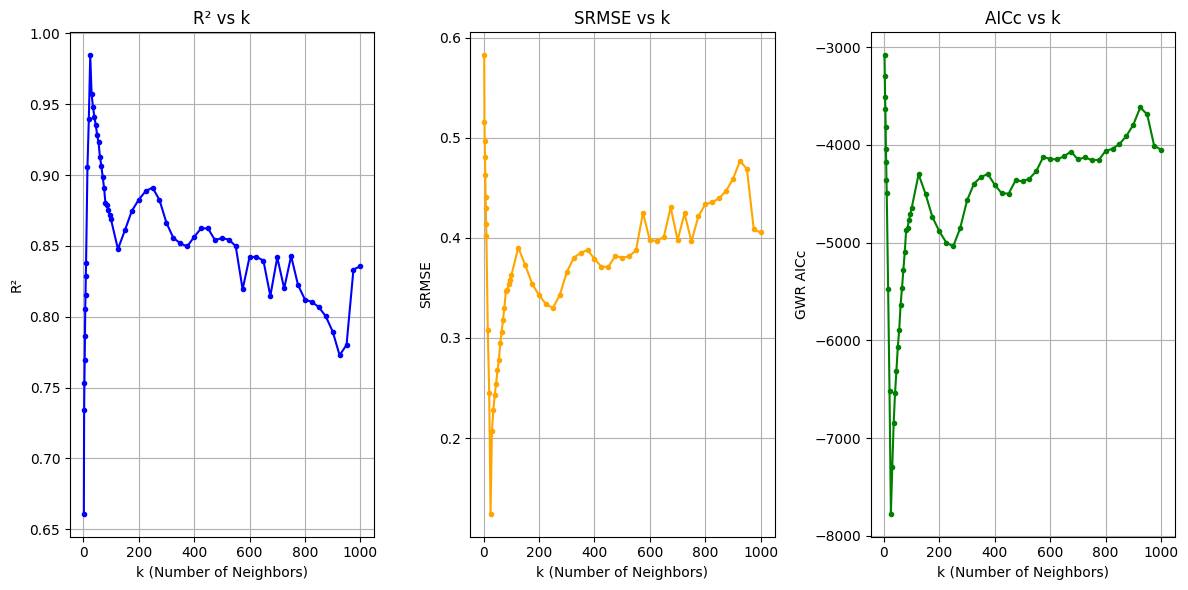

In [101]:
plt.figure(figsize=(12, 6))

# Plot R²
plt.subplot(1, 3, 1)
plt.plot(k_values, r2_list, color='blue', marker='.')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('R²')
plt.title('R² vs k')
plt.grid()

# Plot SRMSE
plt.subplot(1, 3, 2)
plt.plot(k_values, srmse_list, color='orange', marker='.')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('SRMSE')
plt.title('SRMSE vs k')
plt.grid()


# Plot AIcc
plt.subplot(1, 3, 3)
plt.plot(k_values, aicc_list, color='green', marker='.')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('GWR AICc')
plt.title('AICc vs k')
plt.grid()

plt.tight_layout()
plt.show()

### Aggregations

#### 48x48

In [102]:
S1_gdf = gpd.GeoDataFrame({'X': S1, 'geometry': gpd.points_from_xy(loc1[:, 0], loc1[:, 1])})

In [103]:
S1_gdf

X                 geometry
0    -1.217070   POINT (32.857 197.992)
1    -0.725300  POINT (204.138 595.669)
2    -0.125980  POINT (536.507 155.182)
3     0.505422    POINT (6.775 422.464)
4     1.787147  POINT (396.912 484.592)
...        ...                      ...
3595 -1.011250   POINT (237.294 369.16)
3596  1.698226  POINT (253.043 288.905)
3597 -1.774934  POINT (342.353 125.307)
3598 -0.584132   POINT (394.937 184.82)
3599 -1.251444     POINT (5.464 75.523)

[3600 rows x 2 columns]

In [104]:
# Spatial join: assign S1 points to 48x48 tracts
S1_agg = gpd.sjoin(S1_gdf, tracts_gdf48, how="left", predicate="within")

In [105]:
S1_agg = S1_agg.groupby("tract_id")["X"].mean().reset_index()
X_48x48 = tracts_gdf48.merge(S1_agg, on="tract_id", how="left")
X_48x48['y'] = y_orig

In [106]:
sX1_48 = X_48x48.copy()
sX1_48.isna().sum()

tract_id      0
geometry      0
sX            0
X           806
y             0
dtype: int64

In [107]:
sX1_48.dropna(inplace=True)
sX1_48.isna().sum()

tract_id    0
geometry    0
sX          0
X           0
y           0
dtype: int64

In [108]:
gwr_X  = sX1_48['X'].values.reshape(-1,1)
gwr_y = sX1_48['y'].values.reshape(-1, 1) # using aggregated y
coords = np.array([[point.x, point.y] for point in sX1_48['geometry'].centroid])
gwr_X.shape, gwr_y.shape

((1498, 1), (1498, 1))

In [109]:
gwr_selector = Sel_BW(coords, gwr_y, gwr_X, constant=False)
gwr_bw48 = gwr_selector.search(bw_min=2)
gwr_results = GWR(coords, gwr_y, gwr_X, gwr_bw48, constant=False).fit()
print(gwr_bw48)

24.0


In [110]:
params48 = gwr_results.params
y_pred48 = gwr_results.predy
aicc_gwr48 = gwr_results.aicc
r2_48 = gwr_results.R2

print(gwr_results.aicc), print(gwr_results.R2);

-1684.9700546922356
0.6365386339835368


In [111]:
## calculating the standardized root mean squared error
y_true48 = sX1_48['y'].values.reshape(-1,1)
rmse48  = np.sqrt(np.mean((y_true48 - y_pred48)**2))
std_dev48 = np.std(y_true48)
srmse48 = rmse48 / std_dev48
srmse48, rmse48

(np.float64(0.602877571333072), np.float64(0.12135171869444311))

#### 24x24

In [112]:
x_step, y_step = 25, 25 # Creates a 24x24 grid, resulting in 576 tracts cell divisions
tracts_gdf24 = create_tracts(xmin, xmax, ymin, ymax, x_step, y_step)

loc2_24 = np.array([[point.x, point.y] for point in tracts_gdf24.geometry.centroid])

In [113]:
X_48x48['geometry'] = X_48x48.geometry.centroid

In [114]:
# Spatial join X to 24x24 tracts 
spj24_X = gpd.sjoin(S1_gdf, tracts_gdf24, how='right', predicate='within')
agg_24_X = spj24_X.groupby('tract_id')[['X']].mean().reset_index()

In [115]:
# Spatial join y @ 48x48 to 24x24 tracts. Extract only the y from the df: line 2. 
spj24_y = gpd.sjoin(X_48x48, tracts_gdf24, how='right', predicate='within')
agg_24_y = spj24_y.groupby('tract_id_right')[['y']].mean().reset_index()

In [116]:
agg_24 = agg_24_X.merge(agg_24_y, left_on='tract_id', right_on='tract_id_right').drop('tract_id', axis=1)

In [117]:
# Aggregate X & Y within each 24x24 grid cell
GWR_24x24_gdf = tracts_gdf24.merge(agg_24, left_index=True, right_on='tract_id_right', how='left').reset_index(drop=True)

In [118]:
sX1_24 = GWR_24x24_gdf.copy()
sX1_24.isna().sum()

tract_id           0
geometry           0
X                 23
tract_id_right     0
y                  0
dtype: int64

In [119]:
sX1_24.dropna(inplace=True)
sX1_24.isna().sum()

tract_id          0
geometry          0
X                 0
tract_id_right    0
y                 0
dtype: int64

In [120]:
gwr_X  = sX1_24['X'].values.reshape(-1,1)
gwr_y = sX1_24['y'].values.reshape(-1, 1) # using aggregated y
coords = np.array([[point.x, point.y] for point in sX1_24['geometry'].centroid])
gwr_X.shape, gwr_y.shape

((553, 1), (553, 1))

In [121]:
gwr_selector = Sel_BW(coords, gwr_y, gwr_X, constant=False)
gwr_bw24 = gwr_selector.search(bw_min=2)
gwr_results = GWR(coords, gwr_y, gwr_X, gwr_bw24, constant=False).fit()
print(gwr_bw24)

16.0


In [122]:
params24 = gwr_results.params
y_pred24 = gwr_results.predy
aicc_gwr24 = gwr_results.aicc
r2_24 = gwr_results.R2

print(gwr_results.aicc), print(gwr_results.R2);

-733.7580700434852
0.6707593539890371


In [123]:
## calculating the standardized root mean squared error
y_true24 = sX1_24['y'].values.reshape(-1,1)
rmse24  = np.sqrt(np.mean((y_true24 - y_pred24)**2))
std_dev24 = np.std(y_true24)
srmse24 = rmse24 / std_dev24
srmse24, rmse24

(np.float64(0.5737949511898506), np.float64(0.10111693491120996))

#### 16x16

In [124]:
x_step, y_step = 37.5, 37.5 # Creates a 32x32 grid, resulting in 576 tracts cell divisions
tracts_gdf16 = create_tracts(xmin, xmax, ymin, ymax, x_step, y_step)

loc2_16 = np.array([[point.x, point.y] for point in tracts_gdf16.geometry.centroid])

In [125]:
X_48x48['geometry'] = X_48x48.geometry.centroid

In [126]:
# Spatial join X to 16x16 tracts 
spj16_X = gpd.sjoin(S1_gdf, tracts_gdf16, how='right', predicate='within')
agg_16_X = spj16_X.groupby('tract_id')[['X']].mean().reset_index()

In [127]:
# Spatial join y @ 48x48 to 16x16 tracts. Extract only the y from the df: line 2. 
spj16_y = gpd.sjoin(X_48x48, tracts_gdf16, how='right', predicate='within')
agg_16_y = spj16_y.groupby('tract_id_right')[['y']].mean().reset_index()

In [128]:
agg_16 = agg_16_X.merge(agg_16_y, left_on='tract_id', right_on='tract_id_right').drop('tract_id', axis=1)

In [129]:
# Aggregate X & y within each 24x24 grid cell
GWR_16x16_gdf = tracts_gdf16.merge(agg_16, left_index=True, right_on='tract_id_right', how='left').reset_index(drop=True)

In [130]:
sX1_16 = GWR_16x16_gdf.copy()

gwr_X  = sX1_16['X'].values.reshape(-1,1)
gwr_y = sX1_16['y'].values.reshape(-1, 1) # using aggregated y
coords = np.array([[point.x, point.y] for point in sX1_16['geometry'].centroid])
gwr_X.shape, gwr_y.shape

((256, 1), (256, 1))

In [131]:
gwr_selector = Sel_BW(coords, gwr_y, gwr_X, constant=False)
gwr_bw16 = gwr_selector.search(bw_min=2)
gwr_results = GWR(coords, gwr_y, gwr_X, gwr_bw16, constant=False).fit()
print(gwr_bw16)

15.0


In [132]:
params16 = gwr_results.params
y_pred16 = gwr_results.predy
aicc_gwr16 = gwr_results.aicc
r2_16 = gwr_results.R2

print(gwr_results.aicc), print(gwr_results.R2);

-404.66260042461556
0.6729114412322885


In [133]:
## calculating the standardized root mean squared error
y_true16 = sX1_16['y'].values.reshape(-1,1)
rmse16  = np.sqrt(np.mean((y_true16 - y_pred16)**2))
std_dev16 = np.std(y_true16)
srmse16 = rmse16 / std_dev16
srmse16, rmse16

(np.float64(0.5719165662644434), np.float64(0.08937916919832674))

#### 12x12

In [134]:
# This is the step where I choose the size of the tracts 
x_step, y_step = 50, 50  # Creates a 12x12 grid, resulting in 144 tracts cell divisions
tracts_gdf12 = create_tracts(xmin, xmax, ymin, ymax, x_step, y_step)

loc2_12 = np.array([[point.x, point.y] for point in tracts_gdf12.geometry.centroid])

In [135]:
X_48x48['geometry'] = X_48x48.geometry.centroid

In [136]:
# Spatial join X to 12x12 tracts 
spj12_X = gpd.sjoin(S1_gdf, tracts_gdf12, how='right', predicate='within')
agg_12_X = spj12_X.groupby('tract_id')[['X']].mean().reset_index()

In [137]:
# Spatial join y @ 48x48 to 12x12 tracts. Extract only the y from the df: line 2. 
spj12_y = gpd.sjoin(X_48x48, tracts_gdf12, how='right', predicate='within')
agg_12_y = spj12_y.groupby('tract_id_right')[['y']].mean().reset_index()

In [138]:
agg_12 = agg_12_X.merge(agg_12_y, left_on='tract_id', right_on='tract_id_right').drop('tract_id', axis=1)

In [139]:
# Aggregate X & Y within each 24x24 grid cell
GWR_12x12_gdf = tracts_gdf12.merge(agg_12, left_index=True, right_on='tract_id_right', how='left').reset_index(drop=True)

In [140]:
sX1_12 = GWR_12x12_gdf.copy()
sX1_12.isna().sum()

tract_id          0
geometry          0
X                 0
tract_id_right    0
y                 0
dtype: int64

In [141]:
gwr_X  = sX1_12['X'].values.reshape(-1,1)
gwr_y = sX1_12['y'].values.reshape(-1, 1) # using aggregated y
coords = np.array([[point.x, point.y] for point in sX1_12['geometry'].centroid])
gwr_X.shape, gwr_y.shape

((144, 1), (144, 1))

In [142]:
gwr_selector = Sel_BW(coords, gwr_y, gwr_X, constant=False)
gwr_bw12 = gwr_selector.search(bw_min=2)
gwr_results = GWR(coords, gwr_y, gwr_X, gwr_bw12, constant=False).fit()
print(gwr_bw12)

10.0


In [143]:
params12 = gwr_results.params
y_pred12 = gwr_results.predy
aicc_gwr12 = gwr_results.aicc
r2_12 = gwr_results.R2

print(gwr_results.aicc), print(gwr_results.R2);

-251.45594640990538
0.7051084455321193


In [144]:
## calculating the standardized root mean squared error
y_true12 = sX1_12['y'].values.reshape(-1,1)
rmse12  = np.sqrt(np.mean((y_true12 - y_pred12)**2))
std_dev12 = np.std(y_true12)
srmse12 = rmse12 / std_dev12
srmse12, rmse12

(np.float64(0.5430391831791521), np.float64(0.07677376849210357))

#### 8x8

In [145]:
# This is the step where I choose the size of the tracts 
x_step, y_step = 75, 75  # Creates a 8x8 grid, resulting in 256 tracts cell divisions
tracts_gdf8 = create_tracts(xmin, xmax, ymin, ymax, x_step, y_step)

loc2_8 = np.array([[point.x, point.y] for point in tracts_gdf8.geometry.centroid])

In [146]:
X_48x48['geometry'] = X_48x48.geometry.centroid

In [147]:
# Spatial join X to 8x8 tracts 
spj8_X = gpd.sjoin(S1_gdf, tracts_gdf8, how='right', predicate='within')
agg_8_X = spj8_X.groupby('tract_id')[['X']].mean().reset_index()

In [148]:
# Spatial join y @ 48x48 to 8x8 tracts. Extract only the y from the df: line 2. 
spj8_y = gpd.sjoin(X_48x48, tracts_gdf8, how='right', predicate='within')
agg_8_y = spj8_y.groupby('tract_id_right')[['y']].mean().reset_index()

In [149]:
agg_8 = agg_8_X.merge(agg_8_y, left_on='tract_id', right_on='tract_id_right').drop('tract_id', axis=1)

In [150]:
# Aggregate X & Y within each 24x24 grid cell
GWR_8x8_gdf = tracts_gdf8.merge(agg_8, left_index=True, right_on='tract_id_right', how='left').reset_index(drop=True)

In [151]:
sX1_8 = GWR_8x8_gdf.copy()
sX1_8.isna().sum()

tract_id          0
geometry          0
X                 0
tract_id_right    0
y                 0
dtype: int64

In [152]:
gwr_X  = sX1_8['X'].values.reshape(-1,1)
gwr_y = sX1_8['y'].values.reshape(-1, 1) # using aggregated y
coords = np.array([[point.x, point.y] for point in sX1_8['geometry'].centroid])
gwr_X.shape, gwr_y.shape

((64, 1), (64, 1))

In [153]:
gwr_selector = Sel_BW(coords, gwr_y, gwr_X, constant=False)
gwr_bw8 = gwr_selector.search(bw_min=2)
gwr_results = GWR(coords, gwr_y, gwr_X, gwr_bw8, constant=False).fit()
print(gwr_bw8)

20.0


In [154]:
params8 = gwr_results.params
y_pred8 = gwr_results.predy
aicc_gwr8 = gwr_results.aicc
r2_8 = gwr_results.R2

print(gwr_results.aicc), print(gwr_results.R2);

-131.66565774060595
0.4826704995021286


In [155]:
## calculating the standardized root mean squared error
y_true8 = sX1_8['y'].values.reshape(-1,1)
rmse8  = np.sqrt(np.mean((y_true8 - y_pred8)**2))
std_dev8 = np.std(y_true8)
srmse8 = rmse8 / std_dev8
srmse8, rmse8

(np.float64(0.7192562133884359), np.float64(0.07248901486579298))

#### table

In [156]:
grid_sizes = [s for s in ['48x48', '24x24', '16x16', '12x12', '8x8'] for _ in range(3)] 
metrics = ['R²', 'SRMSE', 'BW'] * 5  # Repeat R² and SRMSE for each grid size
# values = [r2_48, srmse48, r2_40, srmse40, r2_32, srmse32, r2_24, srmse24, r2_16, srmse16, r2_8, srmse8]
r2 = [r2_48, r2_24, r2_16, r2_12, r2_8]
srmse = [ srmse48, srmse24, srmse16,srmse12, srmse8]
bw = [gwr_bw48, gwr_bw24, gwr_bw16, gwr_bw12, gwr_bw8]

values = []
for i in range(5):
    values.extend([r2[i], srmse[i], bw[i]])

In [157]:
len(metrics), len(grid_sizes), len(values)


(15, 15, 15)

In [158]:
df = pd.DataFrame({
    'Metric': metrics, # Repeat each grid size for R², SRMSE, BW,
    'Grid Size': grid_sizes,
    'Value': np.round(values, 4)
})

In [159]:
# Reset index to start from 1
df.index = range(1, len(df) + 1)

# Pivot the table to get desired format
df_pivot = df.pivot(index='Metric', columns='Grid Size', values='Value')

df_pivot = df_pivot.reindex(columns=['48x48', '24x24', '16x16', '12x12', '8x8'])
# Remove the "Metric" label
df_pivot.index.name = None
df_pivot

Grid Size    48x48    24x24    16x16    12x12      8x8
BW         24.0000  16.0000  15.0000  10.0000  20.0000
R²          0.6365   0.6708   0.6729   0.7051   0.4827
SRMSE       0.6029   0.5738   0.5719   0.5430   0.7193

#### Visualizations

##### 48x48

In [160]:
loc2_48 = np.array([[point.x, point.y] for point in sX1_48.geometry.centroid])

In [161]:
sX1_48['params48'] = params48
sX1_48

tracts_gdf48_points = tracts_gdf48.copy()
tracts_gdf48_points['geometry'] = tracts_gdf48_points['geometry'].centroid
spj48_48 = gpd.sjoin(tracts_gdf48_points, sX1_48, how='left', predicate='within')
spj48_48['y'] = y_orig

tracts_gdf48["X_48x48"] = spj48_48["X"]
tracts_gdf48['y_48x48'] = spj48_48["y"]
tracts_gdf48['est_beta48'] = spj48_48["params48"]


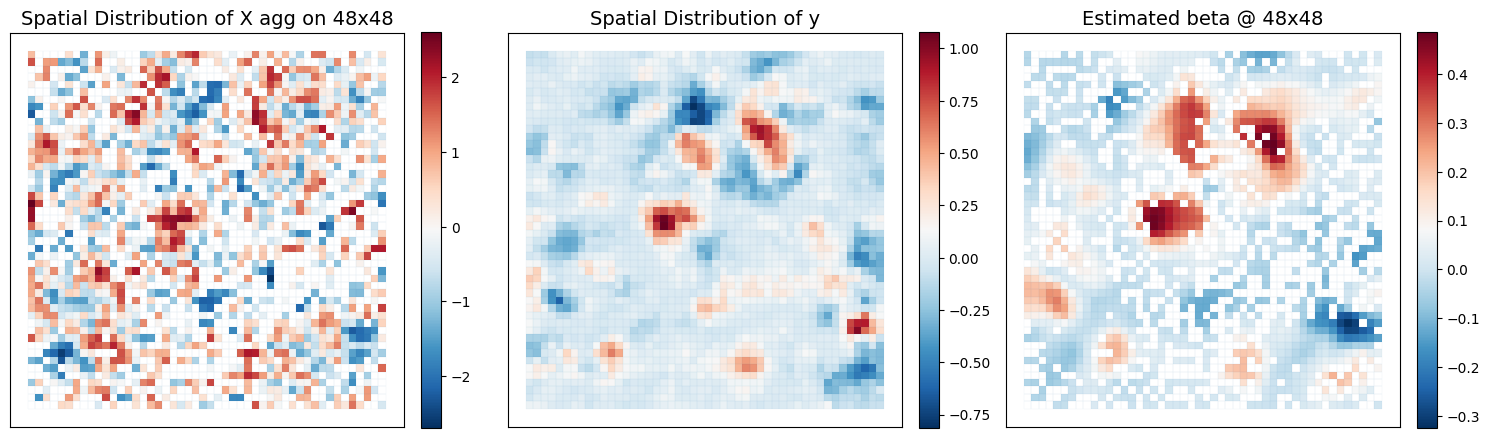

In [162]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
cmap1 = plt.cm.Reds
cmap2 = plt.cm.RdBu_r
cmap3 = plt.cm.RdBu_r

# Plot 1 - X_48x48
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[0])
plot1 = tracts_gdf48.plot(column="X_48x48", cmap=cmap2,
                          edgecolor="face", linewidth=0,
                          ax=ax[0], legend=False)
ax[0].set_title("Spatial Distribution of X agg on 48x48", fontsize=14)
ax[0].set_xticks([])
ax[0].set_yticks([])

# Colorbar for Plot 1
norm1 = mcolors.Normalize(vmin=tracts_gdf48["X_48x48"].min(), vmax=tracts_gdf48["X_48x48"].max())
sm1 = cm.ScalarMappable(cmap=cmap2, norm=norm1)
sm1.set_array([])
fig.colorbar(sm1, ax=ax[0], fraction=0.046, pad=0.04)

# Plot 2 - y_48x48
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[1])
plot2 = tracts_gdf48.plot(column="y_48x48", cmap=cmap2,
                          edgecolor="face", linewidth=0,
                          ax=ax[1], legend=False)
ax[1].set_title("Spatial Distribution of y", fontsize=14)
ax[1].set_xticks([])
ax[1].set_yticks([])

# Colorbar for Plot 2
norm2 = mcolors.Normalize(vmin=tracts_gdf48["y_48x48"].min(), vmax=tracts_gdf48["y_48x48"].max())
sm2 = cm.ScalarMappable(cmap=cmap2, norm=norm2)
sm2.set_array([])
fig.colorbar(sm2, ax=ax[1], fraction=0.046, pad=0.04)

# Plot 3 - est_beta48
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[2])
plot3 = tracts_gdf48.plot(column="est_beta48", cmap=cmap3,
                          edgecolor="face", linewidth=0,
                          ax=ax[2], legend=False)
ax[2].set_title("Estimated beta @ 48x48", fontsize=14)
ax[2].set_xticks([])
ax[2].set_yticks([])

# Colorbar for Plot 3
norm3 = mcolors.Normalize(vmin=tracts_gdf48["est_beta48"].min(), vmax=tracts_gdf48["est_beta48"].max())
sm3 = cm.ScalarMappable(cmap=cmap3, norm=norm3)
sm3.set_array([])
fig.colorbar(sm3, ax=ax[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


##### 24x24

In [163]:
sX1_24['params24'] = params24
sX1_24

tracts_gdf48_points = orig_tracts_gdf48.copy()
tracts_gdf48_points['geometry'] = tracts_gdf48_points['geometry'].centroid
spj24_48 = gpd.sjoin(tracts_gdf48_points, sX1_24, how='left', predicate='within')

In [164]:
tracts_gdf48["X_24x24"] = spj24_48["X"]
tracts_gdf48['y_24x24'] = spj24_48["y"]
tracts_gdf48['est_beta24'] = spj24_48["params24"]

In [165]:
spj24_48["X"]

0      -1.632562
1      -1.632562
2      -0.227612
3      -0.227612
4            NaN
          ...   
2299   -0.842849
2300    0.238502
2301    0.238502
2302   -0.078837
2303   -0.078837
Name: X, Length: 2304, dtype: float64

In [166]:
tracts_gdf48['est_beta24'].isna().sum()

np.int64(92)

In [167]:
# Spatial join X to 16x16 tracts 
spj16_X = gpd.sjoin(S1_gdf, tracts_gdf16, how='right', predicate='within')
agg_16_X = spj16_X.groupby('tract_id')[['X']].mean().reset_index()

In [168]:
# Spatial join y @ 48x48 to 16x16 tracts. Extract only the y from the df: line 2. 
spj16_y = gpd.sjoin(X_48x48, tracts_gdf16, how='right', predicate='within')
agg_16_y = spj16_y.groupby('tract_id_right')[['y']].mean().reset_index()

In [169]:
agg_16 = agg_16_X.merge(agg_16_y, left_on='tract_id', right_on='tract_id_right').drop('tract_id', axis=1)

In [170]:
# Aggregate X & Y within each 24x24 grid cell
GWR_16x16_gdf = tracts_gdf16.merge(agg_16, left_index=True, right_on='tract_id_right', how='left').reset_index(drop=True)

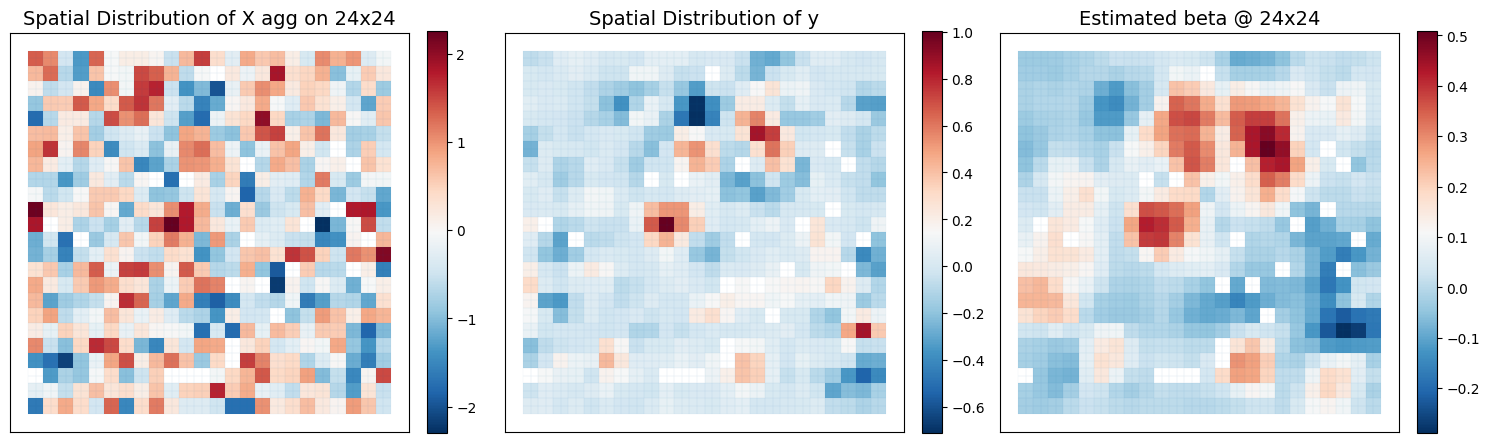

In [171]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
cmap1 = plt.cm.Reds
cmap2 = plt.cm.RdBu_r
cmap3 = plt.cm.RdBu_r

# Plot 1 - X_24x24
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[0])
plot1 = tracts_gdf48.plot(column="X_24x24", cmap=cmap2,
                          edgecolor="face", linewidth=0,
                          ax=ax[0], legend=False)
ax[0].set_title("Spatial Distribution of X agg on 24x24", fontsize=14)
ax[0].set_xticks([])
ax[0].set_yticks([])

# Colorbar for Plot 1
norm1 = mcolors.Normalize(vmin=tracts_gdf48["X_24x24"].min(), vmax=tracts_gdf48["X_24x24"].max())
sm1 = cm.ScalarMappable(cmap=cmap2, norm=norm1)
sm1.set_array([])
fig.colorbar(sm1, ax=ax[0], fraction=0.046, pad=0.04)

# Plot 2 - y_24x24
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[1])
plot2 = tracts_gdf48.plot(column="y_24x24", cmap=cmap2,
                          edgecolor="face", linewidth=0,
                          ax=ax[1], legend=False)
ax[1].set_title("Spatial Distribution of y", fontsize=14)
ax[1].set_xticks([])
ax[1].set_yticks([])

# Colorbar for Plot 2
norm2 = mcolors.Normalize(vmin=tracts_gdf48["y_24x24"].min(), vmax=tracts_gdf48["y_24x24"].max())
sm2 = cm.ScalarMappable(cmap=cmap2, norm=norm2)
sm2.set_array([])
fig.colorbar(sm2, ax=ax[1], fraction=0.046, pad=0.04)

# Plot 3 - est_beta24
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[2])
plot3 = tracts_gdf48.plot(column="est_beta24", cmap=cmap3,
                          edgecolor="face", linewidth=0,
                          ax=ax[2], legend=False)
ax[2].set_title("Estimated beta @ 24x24", fontsize=14)
ax[2].set_xticks([])
ax[2].set_yticks([])

# Colorbar for Plot 3
norm3 = mcolors.Normalize(vmin=tracts_gdf48["est_beta24"].min(), vmax=tracts_gdf48["est_beta24"].max())
sm3 = cm.ScalarMappable(cmap=cmap3, norm=norm3)
sm3.set_array([])
fig.colorbar(sm3, ax=ax[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


##### 16x16

In [172]:
sX1_16['params16'] = params16
sX1_16

tracts_gdf48_points = orig_tracts_gdf48.copy()
tracts_gdf48_points['geometry'] = tracts_gdf48_points['geometry'].centroid
spj16_48 = gpd.sjoin(tracts_gdf48_points, sX1_16, how='left', predicate='within')

In [173]:
tracts_gdf48["X_16x16"] = spj16_48["X"]
tracts_gdf48['y_16x16'] = spj16_48["y"]
tracts_gdf48['est_beta16'] = spj16_48["params16"]

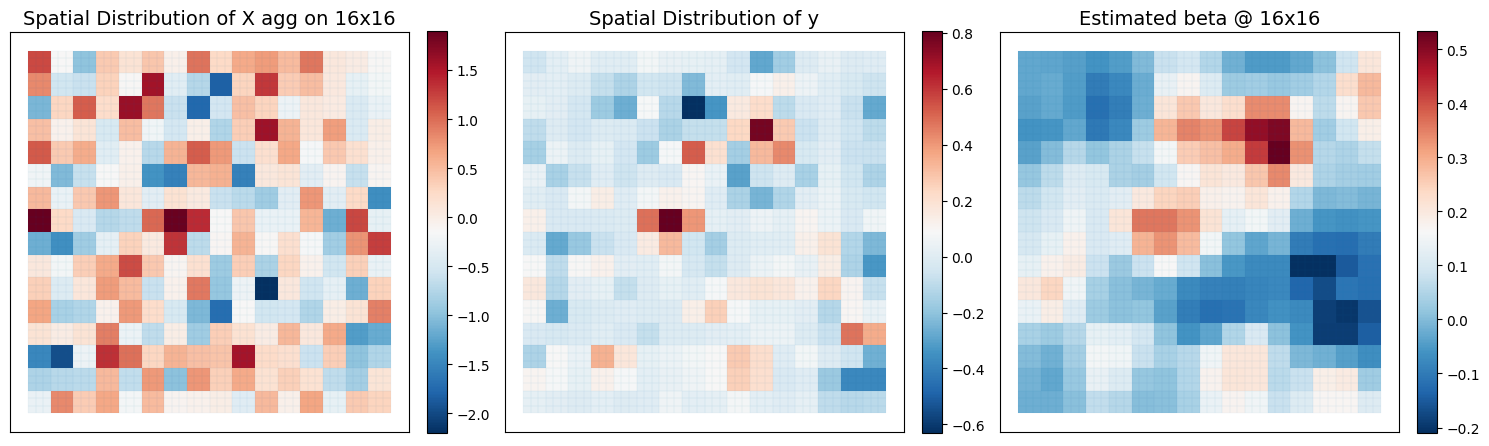

In [174]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
cmap1 = plt.cm.Reds
cmap2 = plt.cm.RdBu_r
cmap3 = plt.cm.RdBu_r

# Plot 1 - X_16x16
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[0])
plot1 = tracts_gdf48.plot(column="X_16x16", cmap=cmap2,
                          edgecolor="face", linewidth=0,
                          ax=ax[0], legend=False)
ax[0].set_title("Spatial Distribution of X agg on 16x16", fontsize=14)
ax[0].set_xticks([])
ax[0].set_yticks([])

# Colorbar for Plot 1
norm1 = mcolors.Normalize(vmin=tracts_gdf48["X_16x16"].min(), vmax=tracts_gdf48["X_16x16"].max())
sm1 = cm.ScalarMappable(cmap=cmap2, norm=norm1)
sm1.set_array([])
fig.colorbar(sm1, ax=ax[0], fraction=0.046, pad=0.04)

# Plot 2 - y_16x16
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[1])
plot2 = tracts_gdf48.plot(column="y_16x16", cmap=cmap2,
                          edgecolor="face", linewidth=0,
                          ax=ax[1], legend=False)
ax[1].set_title("Spatial Distribution of y", fontsize=14)
ax[1].set_xticks([])
ax[1].set_yticks([])

# Colorbar for Plot 2
norm2 = mcolors.Normalize(vmin=tracts_gdf48["y_16x16"].min(), vmax=tracts_gdf48["y_16x16"].max())
sm2 = cm.ScalarMappable(cmap=cmap2, norm=norm2)
sm2.set_array([])
fig.colorbar(sm2, ax=ax[1], fraction=0.046, pad=0.04)

# Plot 3 - est_beta16
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[2])
plot3 = tracts_gdf48.plot(column="est_beta16", cmap=cmap3,
                          edgecolor="face", linewidth=0,
                          ax=ax[2], legend=False)
ax[2].set_title("Estimated beta @ 16x16", fontsize=14)
ax[2].set_xticks([])
ax[2].set_yticks([])

# Colorbar for Plot 3
norm3 = mcolors.Normalize(vmin=tracts_gdf48["est_beta16"].min(), vmax=tracts_gdf48["est_beta16"].max())
sm3 = cm.ScalarMappable(cmap=cmap3, norm=norm3)
sm3.set_array([])
fig.colorbar(sm3, ax=ax[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


##### 12x12

In [175]:
sX1_12['params12'] = params12
sX1_12

tracts_gdf48_points = orig_tracts_gdf48.copy()
tracts_gdf48_points['geometry'] = tracts_gdf48_points['geometry'].centroid
spj12_48 = gpd.sjoin(tracts_gdf48_points, sX1_12, how='left', predicate='within')

In [176]:
tracts_gdf48["X_12x12"] = spj12_48["X"]
tracts_gdf48['y_12x12'] = spj12_48["y"]
tracts_gdf48['est_beta12'] = spj12_48["params12"]

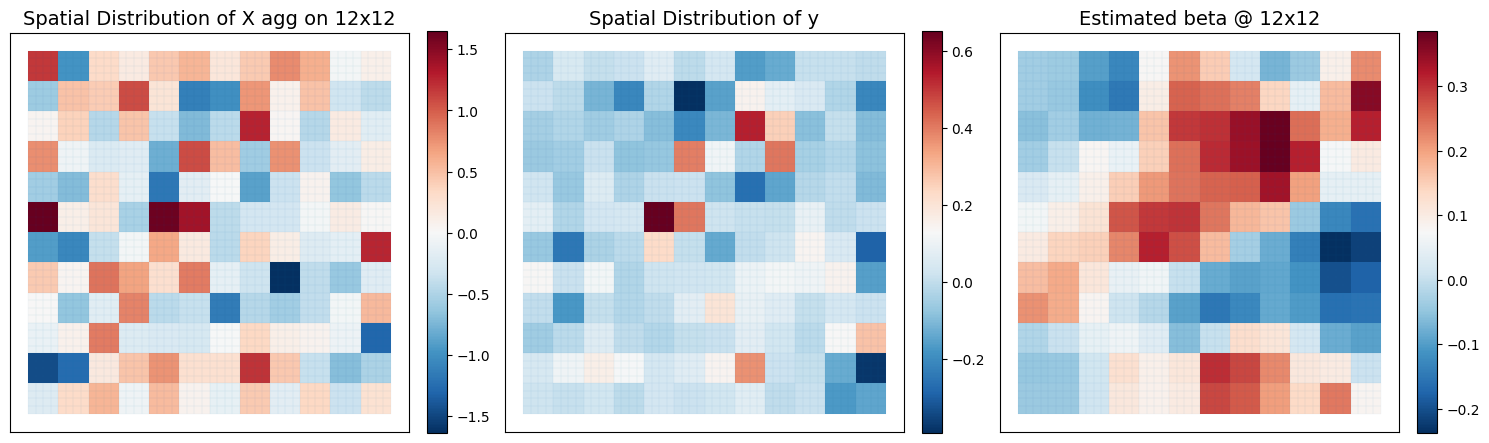

In [177]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
cmap1 = plt.cm.Reds
cmap2 = plt.cm.RdBu_r
cmap3 = plt.cm.RdBu_r

# Plot 1 - X_12x12
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[0])
plot1 = tracts_gdf48.plot(column="X_12x12", cmap=cmap2,
                          edgecolor="face", linewidth=0,
                          ax=ax[0], legend=False)
ax[0].set_title("Spatial Distribution of X agg on 12x12", fontsize=14)
ax[0].set_xticks([])
ax[0].set_yticks([])

# Colorbar for Plot 1
norm1 = mcolors.Normalize(vmin=tracts_gdf48["X_12x12"].min(), vmax=tracts_gdf48["X_12x12"].max())
sm1 = cm.ScalarMappable(cmap=cmap2, norm=norm1)
sm1.set_array([])
fig.colorbar(sm1, ax=ax[0], fraction=0.046, pad=0.04)

# Plot 2 - y_12x12
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[1])
plot2 = tracts_gdf48.plot(column="y_12x12", cmap=cmap2,
                          edgecolor="face", linewidth=0,
                          ax=ax[1], legend=False)
ax[1].set_title("Spatial Distribution of y", fontsize=14)
ax[1].set_xticks([])
ax[1].set_yticks([])

# Colorbar for Plot 2
norm2 = mcolors.Normalize(vmin=tracts_gdf48["y_12x12"].min(), vmax=tracts_gdf48["y_12x12"].max())
sm2 = cm.ScalarMappable(cmap=cmap2, norm=norm2)
sm2.set_array([])
fig.colorbar(sm2, ax=ax[1], fraction=0.046, pad=0.04)

# Plot 3 - est_beta12
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[2])
plot3 = tracts_gdf48.plot(column="est_beta12", cmap=cmap3,
                          edgecolor="face", linewidth=0,
                          ax=ax[2], legend=False)
ax[2].set_title("Estimated beta @ 12x12", fontsize=14)
ax[2].set_xticks([])
ax[2].set_yticks([])

# Colorbar for Plot 3
norm3 = mcolors.Normalize(vmin=tracts_gdf48["est_beta12"].min(), vmax=tracts_gdf48["est_beta12"].max())
sm3 = cm.ScalarMappable(cmap=cmap3, norm=norm3)
sm3.set_array([])
fig.colorbar(sm3, ax=ax[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


##### 8x8

In [178]:
sX1_8['params8'] = params8

tracts_gdf48_points = orig_tracts_gdf48.copy()
tracts_gdf48_points['geometry'] = tracts_gdf48_points['geometry'].centroid
spj8_48 = gpd.sjoin(tracts_gdf48_points, sX1_8, how='left', predicate='within')

In [179]:
tracts_gdf48["X_8x8"] = spj8_48["X"]
tracts_gdf48['y_8x8'] = spj8_48["y"]
tracts_gdf48['est_beta8'] = spj8_48["params8"]

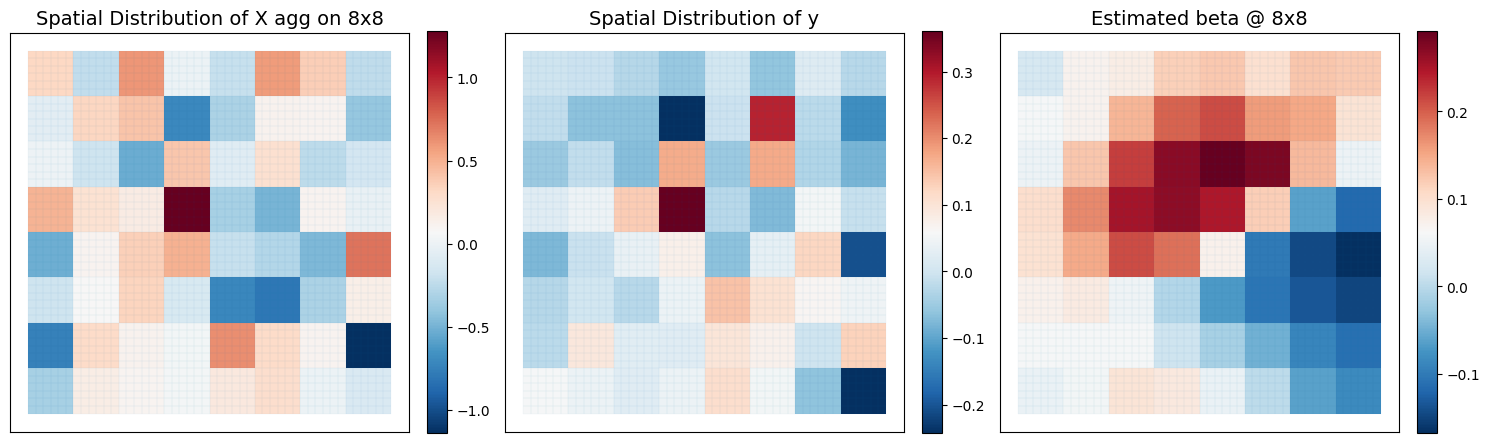

In [180]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
cmap1 = plt.cm.Reds
cmap2 = plt.cm.RdBu_r
cmap3 = plt.cm.RdBu_r

# Plot 1 - X_8x8
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[0])
plot1 = tracts_gdf48.plot(column="X_8x8", cmap=cmap2,
                          edgecolor="face", linewidth=0,
                          ax=ax[0], legend=False)
ax[0].set_title("Spatial Distribution of X agg on 8x8", fontsize=14)
ax[0].set_xticks([])
ax[0].set_yticks([])

# Colorbar for Plot 1
norm1 = mcolors.Normalize(vmin=tracts_gdf48["X_8x8"].min(), vmax=tracts_gdf48["X_8x8"].max())
sm1 = cm.ScalarMappable(cmap=cmap2, norm=norm1)
sm1.set_array([])
fig.colorbar(sm1, ax=ax[0], fraction=0.046, pad=0.04)

# Plot 2 - y_8x8
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[1])
plot2 = tracts_gdf48.plot(column="y_8x8", cmap=cmap2,
                          edgecolor="face", linewidth=0,
                          ax=ax[1], legend=False)
ax[1].set_title("Spatial Distribution of y", fontsize=14)
ax[1].set_xticks([])
ax[1].set_yticks([])

# Colorbar for Plot 2
norm2 = mcolors.Normalize(vmin=tracts_gdf48["y_8x8"].min(), vmax=tracts_gdf48["y_8x8"].max())
sm2 = cm.ScalarMappable(cmap=cmap2, norm=norm2)
sm2.set_array([])
fig.colorbar(sm2, ax=ax[1], fraction=0.046, pad=0.04)

# Plot 3 - est_beta8
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[2])
plot3 = tracts_gdf48.plot(column="est_beta8", cmap=cmap3,
                          edgecolor="face", linewidth=0,
                          ax=ax[2], legend=False)
ax[2].set_title("Estimated beta @ 8x8", fontsize=14)
ax[2].set_xticks([])
ax[2].set_yticks([])

# Colorbar for Plot 3
norm3 = mcolors.Normalize(vmin=tracts_gdf48["est_beta8"].min(), vmax=tracts_gdf48["est_beta8"].max())
sm3 = cm.ScalarMappable(cmap=cmap3, norm=norm3)
sm3.set_array([])
fig.colorbar(sm3, ax=ax[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


##### general viz

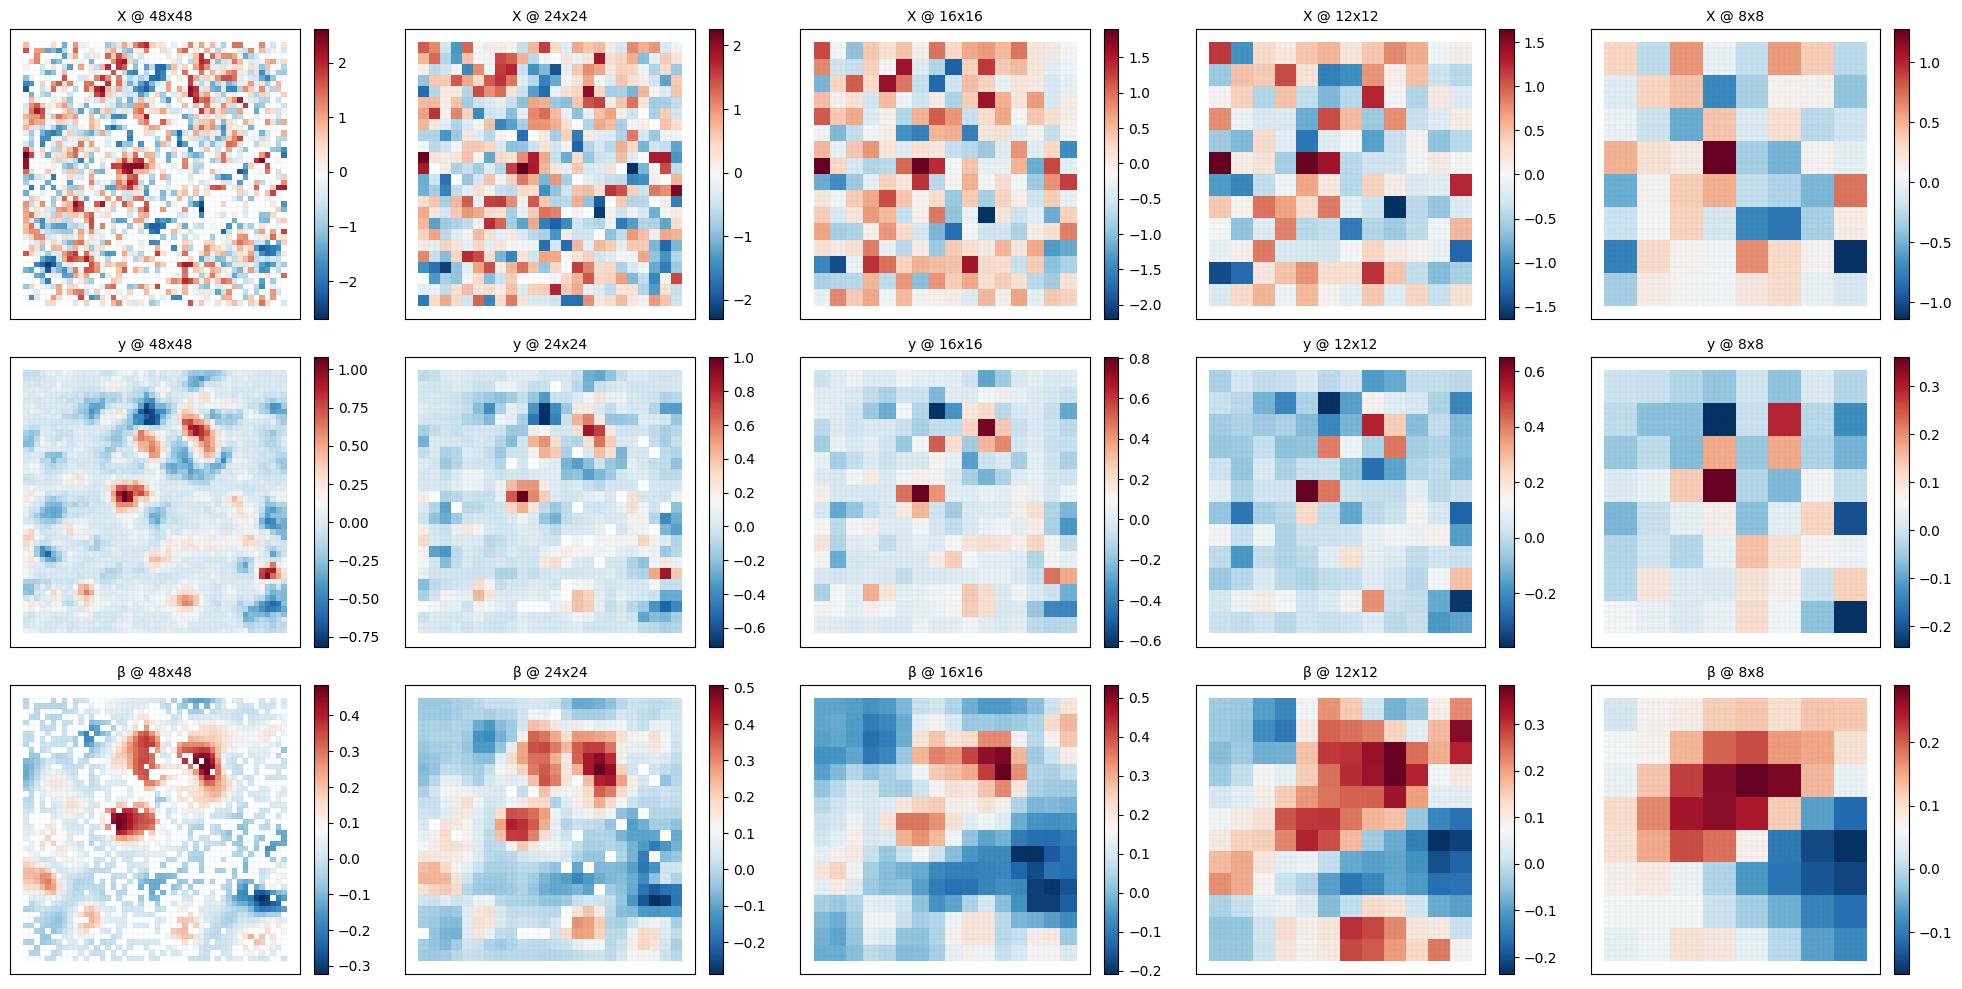

In [184]:
res_labels = ["48x48", "24x24", "16x16", "12x12", "8x8"]
x_cols = ["X_48x48", "X_24x24", "X_16x16", "X_12x12", "X_8x8"]
y_cols = ["y_48x48", "y_24x24", "y_16x16", "y_12x12", "y_8x8"]
beta_cols = ["est_beta48", "est_beta24", "est_beta16", "est_beta12", "est_beta8"]
titles = ["X", "y", "β"]
cmap = plt.cm.RdBu_r

# Create a 3x5 grid
fig, axes = plt.subplots(3, 5, figsize=(20, 10))

# Loop through each row (X, y, β) and each column (resolutions)
for row, cols in enumerate([x_cols, y_cols, beta_cols]):
    for col, colname in enumerate(cols):
        ax = axes[row, col]
        
        # Base map (light boundary layer)
        tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax)
        
        # Choropleth plot
        tracts_gdf48.plot(column=colname, cmap=cmap, edgecolor="face", linewidth=0, ax=ax, legend=False)
        
        # Normalize for consistent colorbar
        norm = mcolors.Normalize(vmin=tracts_gdf48[colname].min(), vmax=tracts_gdf48[colname].max())
        sm = cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        fig.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
        
        # Title and layout tweaks
        ax.set_title(f"{titles[row]} @ {res_labels[col]}", fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])

plt.tight_layout()
plt.show()


## K = 250

In [185]:
# Define grid parameters and create tracts
xmin, xmax = 0, 600
ymin, ymax = 0, 600

# This is the step where I choose the size of the tracts 
x_step, y_step = 12.5, 12.5 # Creates a 48x48 grid, resulting in 2304 tracts
tracts_gdf48 = create_tracts(xmin, xmax, ymin, ymax, x_step, y_step)

orig_tracts_gdf48 = create_tracts(xmin, xmax, ymin, ymax, x_step, y_step)

In [186]:
B = beta_surface_scaled.flatten()

nbrs_S2 = NearestNeighbors(n_neighbors=250).fit(loc1)

smoothed_S1_to_S2 = np.zeros(len(S2))

for i in range(len(S2)):
    distances_S1_to_S2, indices_S1_to_S2 = nbrs_S2.kneighbors([loc2[i]])
    smoothed_S1_to_S2[i] = np.mean(S1[indices_S1_to_S2[0]].flatten())


np.random.seed(26)

error_term = np.random.normal(0, 0.01, len(S2))

y_orig = B * smoothed_S1_to_S2 + error_term

<Figure size 1000x800 with 0 Axes>

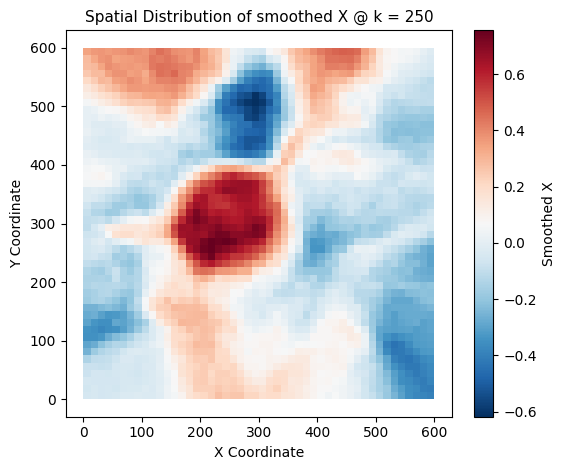

In [187]:
plt.figure(figsize=(10, 8))

# Assign smoothed values
tracts_gdf48['sX'] = smoothed_S1_to_S2

# Plot the choropleth map
ax = tracts_gdf48.plot(
    column="sX",
    cmap=plt.cm.RdBu_r,
    edgecolor="face",
    linewidth=0,
    legend=False
)

# Create scalar mappable for colorbar
norm = mcolors.Normalize(
    vmin=tracts_gdf48["sX"].min(),
    vmax=tracts_gdf48["sX"].max()
)
sm = cm.ScalarMappable(norm=norm, cmap=plt.cm.RdBu_r)
sm._A = []  # workaround to enable colorbar for ScalarMappable

# Add colorbar to the plot
cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("Smoothed X")

# Add labels and title
ax.set_xlabel("X Coordinate")
ax.set_ylabel("Y Coordinate")
ax.set_title("Spatial Distribution of smoothed X @ k = 250", fontsize=11)

plt.tight_layout()


<Figure size 1000x800 with 0 Axes>

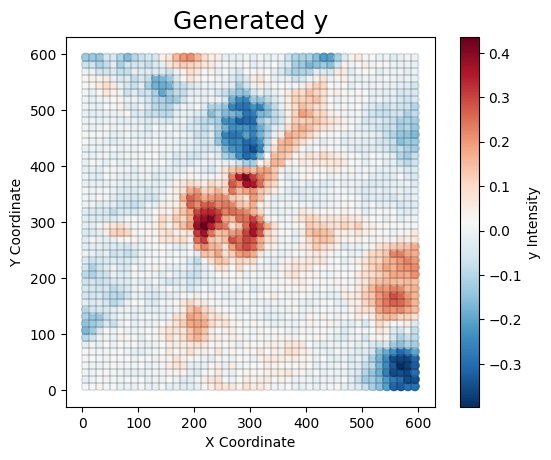

In [188]:
plt.figure(figsize=(10, 8))
tracts_gdf48.boundary.plot(edgecolor="black", linewidth=0.1)  # Plot grid boundaries

# Set colormap to "RdBu_r" (reversed Red-Blue to match the desired effect)
cmap = plt.cm.RdBu_r

# # Scatter plot with diverging colormap
sc = plt.scatter(loc2[:, 0], loc2[:, 1], c=y_orig, cmap=cmap, edgecolor=None)

# Add Colorbar
plt.colorbar(sc, label="y Intensity")

# Labels and Title
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("Generated y", fontsize=18)

plt.show()

In [189]:
r2_list = []
srmse_list = []
bw_list = []
aicc_list = []

part1 = list(range(2, 11, 1))
part2 = list(range(15, 101, 5))
part3 = list(range(125, 1001, 25))

k_values = part1 + part2 + part3

for k in k_values:
    # --- 1. Smooth point-level X (S1) to polygon-level (S2 centroids) ---
    nbrs_S1 = NearestNeighbors(n_neighbors=k).fit(loc1)  # loc1 = point locations
    smoothed_S1_to_S2 = np.zeros(len(loc2))  # loc2 = tract centroids
    
    for i in range(len(loc2)):
        distances_S1_to_S2, indices_S1_to_S2 = nbrs_S1.kneighbors([loc2[i]])
        bw_S1 = distances_S1_to_S2[0][-1]
        weights_X = np.exp(-0.5 * (distances_S1_to_S2[0] / bw_S1) ** 2)
        local_X = S1[indices_S1_to_S2[0]]  # S1 = point-level X
        smoothed_S1_to_S2[i] = np.sum(local_X * weights_X) / np.sum(weights_X)
    
    # --- 3. Fit GWR at polygon level ---
    coords = loc2  # tract centroids
    X_design = smoothed_S1_to_S2.reshape(-1,1)
    y_design = y_orig.reshape(-1,1)
    
    bw = Sel_BW(coords, y_design, X_design, constant=False).search(bw_min=2)
    gwr_model = GWR(coords, y_design, X_design, bw, constant=False)
    gwr_results = gwr_model.fit()
    
    # --- 4. Extract metrics ---
    y_pred = gwr_results.predy.flatten()
    r2 = r2_score(y_orig, y_pred)
    srmse = np.sqrt(mean_squared_error(y_orig, y_pred)) / np.std(y_orig)
    aicc = gwr_results.aicc
    
    r2_list.append(r2)
    srmse_list.append(srmse)
    bw_list.append(bw)
    aicc_list.append(aicc)
    
    print(f"k={k}: R2={r2:.4f}, SRMSE={srmse:.4f}, AICc={aicc:.4f}, BW={bw:.4f}")

k=2: R2=0.5498, SRMSE=0.6710, AICc=-5237.3913, BW=14.0000
k=3: R2=0.5736, SRMSE=0.6530, AICc=-5382.9369, BW=15.0000
k=4: R2=0.6005, SRMSE=0.6321, AICc=-5536.3406, BW=14.0000
k=5: R2=0.6040, SRMSE=0.6293, AICc=-5566.3151, BW=14.0000
k=6: R2=0.6143, SRMSE=0.6211, AICc=-5631.6534, BW=15.0000
k=7: R2=0.6132, SRMSE=0.6219, AICc=-5636.1160, BW=14.0000
k=8: R2=0.6144, SRMSE=0.6209, AICc=-5651.4349, BW=14.0000
k=9: R2=0.6208, SRMSE=0.6158, AICc=-5697.8434, BW=14.0000
k=10: R2=0.6242, SRMSE=0.6131, AICc=-5722.4331, BW=14.0000
k=15: R2=0.6607, SRMSE=0.5825, AICc=-5959.6732, BW=15.0000
k=20: R2=0.7014, SRMSE=0.5465, AICc=-6006.6711, BW=10.0000
k=25: R2=0.6882, SRMSE=0.5584, AICc=-6165.5521, BW=14.0000
k=30: R2=0.7348, SRMSE=0.5150, AICc=-6534.8095, BW=14.0000
k=35: R2=0.7682, SRMSE=0.4815, AICc=-6833.0776, BW=14.0000
k=40: R2=0.7902, SRMSE=0.4580, AICc=-7058.1689, BW=16.0000
k=45: R2=0.7992, SRMSE=0.4481, AICc=-7143.5882, BW=14.0000
k=50: R2=0.8082, SRMSE=0.4380, AICc=-7252.2645, BW=18.0000
k=55:

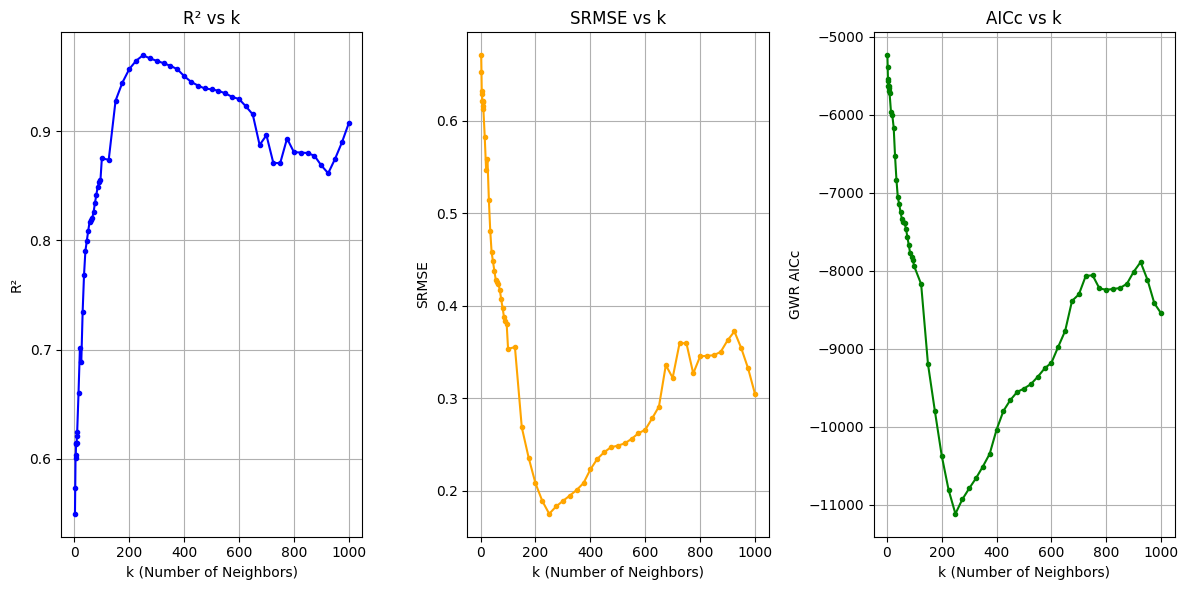

In [190]:
plt.figure(figsize=(12, 6))

# Plot R²
plt.subplot(1, 3, 1)
plt.plot(k_values, r2_list, color='blue', marker='.')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('R²')
plt.title('R² vs k')
plt.grid()

# Plot SRMSE
plt.subplot(1, 3, 2)
plt.plot(k_values, srmse_list, color='orange', marker='.')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('SRMSE')
plt.title('SRMSE vs k')
plt.grid()


# Plot AIcc
plt.subplot(1, 3, 3)
plt.plot(k_values, aicc_list, color='green', marker='.')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('GWR AICc')
plt.title('AICc vs k')
plt.grid()

plt.tight_layout()
plt.show()

### Aggregations

#### 48x48

In [191]:
S1_gdf = gpd.GeoDataFrame({'X': S1, 'geometry': gpd.points_from_xy(loc1[:, 0], loc1[:, 1])})

In [192]:
S1_gdf

X                 geometry
0    -1.217070   POINT (32.857 197.992)
1    -0.725300  POINT (204.138 595.669)
2    -0.125980  POINT (536.507 155.182)
3     0.505422    POINT (6.775 422.464)
4     1.787147  POINT (396.912 484.592)
...        ...                      ...
3595 -1.011250   POINT (237.294 369.16)
3596  1.698226  POINT (253.043 288.905)
3597 -1.774934  POINT (342.353 125.307)
3598 -0.584132   POINT (394.937 184.82)
3599 -1.251444     POINT (5.464 75.523)

[3600 rows x 2 columns]

In [193]:
# Spatial join: assign S1 points to 48x48 tracts
S1_agg = gpd.sjoin(S1_gdf, tracts_gdf48, how="left", predicate="within")

In [194]:
S1_agg = S1_agg.groupby("tract_id")["X"].mean().reset_index()
X_48x48 = tracts_gdf48.merge(S1_agg, on="tract_id", how="left")
X_48x48['y'] = y_orig

In [195]:
sX1_48 = X_48x48.copy()
sX1_48.isna().sum()

tract_id      0
geometry      0
sX            0
X           806
y             0
dtype: int64

In [196]:
sX1_48.dropna(inplace=True)
sX1_48.isna().sum()

tract_id    0
geometry    0
sX          0
X           0
y           0
dtype: int64

In [197]:
gwr_X  = sX1_48['X'].values.reshape(-1,1)
gwr_y = sX1_48['y'].values.reshape(-1, 1) # using aggregated y
coords = np.array([[point.x, point.y] for point in sX1_48['geometry'].centroid])
gwr_X.shape, gwr_y.shape

((1498, 1), (1498, 1))

In [198]:
gwr_selector = Sel_BW(coords, gwr_y, gwr_X, constant=False)
gwr_bw48 = gwr_selector.search(bw_min=2)
gwr_results = GWR(coords, gwr_y, gwr_X, gwr_bw48, constant=False).fit()
print(gwr_bw48)

22.0


In [199]:
params48 = gwr_results.params
y_pred48 = gwr_results.predy
aicc_gwr48 = gwr_results.aicc
r2_48 = gwr_results.R2

print(gwr_results.aicc), print(gwr_results.R2);

-3237.3170013523923
0.4183804021825205


In [200]:
## calculating the standardized root mean squared error
y_true48 = sX1_48['y'].values.reshape(-1,1)
rmse48  = np.sqrt(np.mean((y_true48 - y_pred48)**2))
std_dev48 = np.std(y_true48)
srmse48 = rmse48 / std_dev48
srmse48, rmse48

(np.float64(0.7626398873763944), np.float64(0.07152616649990517))

#### 24x24

In [201]:
x_step, y_step = 25, 25 # Creates a 24x24 grid, resulting in 576 tracts cell divisions
tracts_gdf24 = create_tracts(xmin, xmax, ymin, ymax, x_step, y_step)

loc2_24 = np.array([[point.x, point.y] for point in tracts_gdf24.geometry.centroid])

In [202]:
X_48x48['geometry'] = X_48x48.geometry.centroid

In [203]:
# Spatial join X to 24x24 tracts 
spj24_X = gpd.sjoin(S1_gdf, tracts_gdf24, how='right', predicate='within')
agg_24_X = spj24_X.groupby('tract_id')[['X']].mean().reset_index()

In [204]:
# Spatial join y @ 48x48 to 24x24 tracts. Extract only the y from the df: line 2. 
spj24_y = gpd.sjoin(X_48x48, tracts_gdf24, how='right', predicate='within')
agg_24_y = spj24_y.groupby('tract_id_right')[['y']].mean().reset_index()

In [205]:
agg_24 = agg_24_X.merge(agg_24_y, left_on='tract_id', right_on='tract_id_right').drop('tract_id', axis=1)

In [206]:
# Aggregate X & Y within each 24x24 grid cell
GWR_24x24_gdf = tracts_gdf24.merge(agg_24, left_index=True, right_on='tract_id_right', how='left').reset_index(drop=True)

In [207]:
sX1_24 = GWR_24x24_gdf.copy()
sX1_24.isna().sum()

tract_id           0
geometry           0
X                 23
tract_id_right     0
y                  0
dtype: int64

In [208]:
sX1_24.dropna(inplace=True)
sX1_24.isna().sum()

tract_id          0
geometry          0
X                 0
tract_id_right    0
y                 0
dtype: int64

In [209]:
gwr_X  = sX1_24['X'].values.reshape(-1,1)
gwr_y = sX1_24['y'].values.reshape(-1, 1) # using aggregated y
coords = np.array([[point.x, point.y] for point in sX1_24['geometry'].centroid])
gwr_X.shape, gwr_y.shape

((553, 1), (553, 1))

In [210]:
gwr_selector = Sel_BW(coords, gwr_y, gwr_X, constant=False)
gwr_bw24 = gwr_selector.search(bw_min=2)
gwr_results = GWR(coords, gwr_y, gwr_X, gwr_bw24, constant=False).fit()
print(gwr_bw24)

53.0


In [211]:
params24 = gwr_results.params
y_pred24 = gwr_results.predy
aicc_gwr24 = gwr_results.aicc
r2_24 = gwr_results.R2

print(gwr_results.aicc), print(gwr_results.R2);

-1082.5141514229115
0.14098541568337253


In [212]:
## calculating the standardized root mean squared error
y_true24 = sX1_24['y'].values.reshape(-1,1)
rmse24  = np.sqrt(np.mean((y_true24 - y_pred24)**2))
std_dev24 = np.std(y_true24)
srmse24 = rmse24 / std_dev24
srmse24, rmse24

(np.float64(0.9268303967375193), np.float64(0.08583156380302728))

#### 16x16

In [213]:
x_step, y_step = 37.5, 37.5 # Creates a 32x32 grid, resulting in 576 tracts cell divisions
tracts_gdf16 = create_tracts(xmin, xmax, ymin, ymax, x_step, y_step)

loc2_16 = np.array([[point.x, point.y] for point in tracts_gdf16.geometry.centroid])

In [214]:
X_48x48['geometry'] = X_48x48.geometry.centroid

In [215]:
# Spatial join X to 16x16 tracts 
spj16_X = gpd.sjoin(S1_gdf, tracts_gdf16, how='right', predicate='within')
agg_16_X = spj16_X.groupby('tract_id')[['X']].mean().reset_index()

In [216]:
# Spatial join y @ 48x48 to 16x16 tracts. Extract only the y from the df: line 2. 
spj16_y = gpd.sjoin(X_48x48, tracts_gdf16, how='right', predicate='within')
agg_16_y = spj16_y.groupby('tract_id_right')[['y']].mean().reset_index()

In [217]:
agg_16 = agg_16_X.merge(agg_16_y, left_on='tract_id', right_on='tract_id_right').drop('tract_id', axis=1)

In [218]:
# Aggregate X & y within each 24x24 grid cell
GWR_16x16_gdf = tracts_gdf16.merge(agg_16, left_index=True, right_on='tract_id_right', how='left').reset_index(drop=True)

In [219]:
sX1_16 = GWR_16x16_gdf.copy()

gwr_X  = sX1_16['X'].values.reshape(-1,1)
gwr_y = sX1_16['y'].values.reshape(-1, 1) # using aggregated y
coords = np.array([[point.x, point.y] for point in sX1_16['geometry'].centroid])
gwr_X.shape, gwr_y.shape

((256, 1), (256, 1))

In [220]:
gwr_selector = Sel_BW(coords, gwr_y, gwr_X, constant=False)
gwr_bw16 = gwr_selector.search(bw_min=2)
gwr_results = GWR(coords, gwr_y, gwr_X, gwr_bw16, constant=False).fit()
print(gwr_bw16)

251.0


In [221]:
params16 = gwr_results.params
y_pred16 = gwr_results.predy
aicc_gwr16 = gwr_results.aicc
r2_16 = gwr_results.R2

print(gwr_results.aicc), print(gwr_results.R2);

-516.6876998956241
-0.0005061845821352495


In [222]:
## calculating the standardized root mean squared error
y_true16 = sX1_16['y'].values.reshape(-1,1)
rmse16  = np.sqrt(np.mean((y_true16 - y_pred16)**2))
std_dev16 = np.std(y_true16)
srmse16 = rmse16 / std_dev16
srmse16, rmse16

(np.float64(1.000253060271317), np.float64(0.08714873459984776))

#### 12x12

In [223]:
# This is the step where I choose the size of the tracts 
x_step, y_step = 50, 50  # Creates a 12x12 grid, resulting in 144 tracts cell divisions
tracts_gdf12 = create_tracts(xmin, xmax, ymin, ymax, x_step, y_step)

loc2_12 = np.array([[point.x, point.y] for point in tracts_gdf12.geometry.centroid])

In [224]:
X_48x48['geometry'] = X_48x48.geometry.centroid

In [225]:
# Spatial join X to 12x12 tracts 
spj12_X = gpd.sjoin(S1_gdf, tracts_gdf12, how='right', predicate='within')
agg_12_X = spj12_X.groupby('tract_id')[['X']].mean().reset_index()

In [226]:
# Spatial join y @ 48x48 to 12x12 tracts. Extract only the y from the df: line 2. 
spj12_y = gpd.sjoin(X_48x48, tracts_gdf12, how='right', predicate='within')
agg_12_y = spj12_y.groupby('tract_id_right')[['y']].mean().reset_index()

In [227]:
agg_12 = agg_12_X.merge(agg_12_y, left_on='tract_id', right_on='tract_id_right').drop('tract_id', axis=1)

In [228]:
# Aggregate X & Y within each 12x12 grid cell
GWR_12x12_gdf = tracts_gdf12.merge(agg_12, left_index=True, right_on='tract_id_right', how='left').reset_index(drop=True)

In [229]:
sX1_12 = GWR_12x12_gdf.copy()
sX1_12.isna().sum()

tract_id          0
geometry          0
X                 0
tract_id_right    0
y                 0
dtype: int64

In [230]:
gwr_X  = sX1_12['X'].values.reshape(-1,1)
gwr_y = sX1_12['y'].values.reshape(-1, 1) # using aggregated y
coords = np.array([[point.x, point.y] for point in sX1_12['geometry'].centroid])
gwr_X.shape, gwr_y.shape

((144, 1), (144, 1))

In [231]:
coords.shape, gwr_y.shape, gwr_X.shape

((144, 2), (144, 1), (144, 1))

In [232]:
gwr_selector = Sel_BW(coords, gwr_y, gwr_X, constant=False)
gwr_bw12 = gwr_selector.search(bw_min=2)
gwr_results = GWR(coords, gwr_y, gwr_X, gwr_bw12, constant=False).fit()
print(gwr_bw12)

133.0


In [233]:
params12 = gwr_results.params
y_pred12 = gwr_results.predy
aicc_gwr12 = gwr_results.aicc
r2_12 = gwr_results.R2

print(gwr_results.aicc), print(gwr_results.R2);

-302.35883229968874
0.015491888798124243


In [234]:
## calculating the standardized root mean squared error
y_true12 = sX1_12['y'].values.reshape(-1,1)
rmse12  = np.sqrt(np.mean((y_true12 - y_pred12)**2))
std_dev12 = np.std(y_true12)
srmse12 = rmse12 / std_dev12
srmse12, rmse12

(np.float64(0.9922238211219662), np.float64(0.08266925367554805))

#### 8x8

In [235]:
# This is the step where I choose the size of the tracts 
x_step, y_step = 75, 75  # Creates a 8x8 grid, resulting in 256 tracts cell divisions
tracts_gdf8 = create_tracts(xmin, xmax, ymin, ymax, x_step, y_step)

loc2_8 = np.array([[point.x, point.y] for point in tracts_gdf8.geometry.centroid])

In [236]:
X_48x48['geometry'] = X_48x48.geometry.centroid

In [237]:
# Spatial join X to 8x8 tracts 
spj8_X = gpd.sjoin(S1_gdf, tracts_gdf8, how='right', predicate='within')
agg_8_X = spj8_X.groupby('tract_id')[['X']].mean().reset_index()

In [238]:
# Spatial join y @ 48x48 to 8x8 tracts. Extract only the y from the df: line 2. 
spj8_y = gpd.sjoin(X_48x48, tracts_gdf8, how='right', predicate='within')
agg_8_y = spj8_y.groupby('tract_id_right')[['y']].mean().reset_index()

In [239]:
agg_8 = agg_8_X.merge(agg_8_y, left_on='tract_id', right_on='tract_id_right').drop('tract_id', axis=1)

In [240]:
# Aggregate X & Y within each 24x24 grid cell
GWR_8x8_gdf = tracts_gdf8.merge(agg_8, left_index=True, right_on='tract_id_right', how='left').reset_index(drop=True)

In [241]:
sX1_8 = GWR_8x8_gdf.copy()
sX1_8.isna().sum()

tract_id          0
geometry          0
X                 0
tract_id_right    0
y                 0
dtype: int64

In [242]:
gwr_X  = sX1_8['X'].values.reshape(-1,1)
gwr_y = sX1_8['y'].values.reshape(-1, 1) # using aggregated y
coords = np.array([[point.x, point.y] for point in sX1_8['geometry'].centroid])
gwr_X.shape, gwr_y.shape

((64, 1), (64, 1))

In [243]:
gwr_selector = Sel_BW(coords, gwr_y, gwr_X, constant=False)
gwr_bw8 = gwr_selector.search(bw_min=2)
gwr_results = GWR(coords, gwr_y, gwr_X, gwr_bw8, constant=False).fit()
print(gwr_bw8)

55.0


In [244]:
params8 = gwr_results.params
y_pred8 = gwr_results.predy
aicc_gwr8 = gwr_results.aicc
r2_8 = gwr_results.R2

print(gwr_results.aicc), print(gwr_results.R2);

-154.52166509555872
0.1371278696140531


In [245]:
## calculating the standardized root mean squared error
y_true8 = sX1_8['y'].values.reshape(-1,1)
rmse8  = np.sqrt(np.mean((y_true8 - y_pred8)**2))
std_dev8 = np.std(y_true8)
srmse8 = rmse8 / std_dev8
srmse8, rmse8

(np.float64(0.9289091077096548), np.float64(0.06821142893285739))

#### table

In [246]:
grid_sizes = [s for s in ['48x48', '24x24', '16x16', '12x12', '8x8'] for _ in range(3)] 
metrics = ['R²', 'SRMSE', 'BW'] * 5  # Repeat R² and SRMSE for each grid size
# values = [r2_48, srmse48, r2_40, srmse40, r2_32, srmse32, r2_24, srmse24, r2_16, srmse16, r2_8, srmse8]
r2 = [r2_48, r2_24, r2_16, r2_12, r2_8]
srmse = [ srmse48, srmse24, srmse16,srmse12, srmse8]
bw = [gwr_bw48, gwr_bw24, gwr_bw16, gwr_bw12, gwr_bw8]

values = []
for i in range(5):
    values.extend([r2[i], srmse[i], bw[i]])

In [247]:
len(metrics), len(grid_sizes), len(values)


(15, 15, 15)

In [248]:
df = pd.DataFrame({
    'Metric': metrics, # Repeat each grid size for R², SRMSE, BW,
    'Grid Size': grid_sizes,
    'Value': np.round(values, 4)
})

In [249]:
# Reset index to start from 1
df.index = range(1, len(df) + 1)

# Pivot the table to get desired format
df_pivot = df.pivot(index='Metric', columns='Grid Size', values='Value')

df_pivot = df_pivot.reindex(columns=['48x48', '24x24', '16x16', '12x12', '8x8'])
# Remove the "Metric" label
df_pivot.index.name = None
df_pivot

Grid Size    48x48    24x24     16x16     12x12      8x8
BW         22.0000  53.0000  251.0000  133.0000  55.0000
R²          0.4184   0.1410   -0.0005    0.0155   0.1371
SRMSE       0.7626   0.9268    1.0003    0.9922   0.9289

#### Visualizations

##### 48x48

In [250]:
loc2_48 = np.array([[point.x, point.y] for point in sX1_48.geometry.centroid])

In [251]:
sX1_48['params48'] = params48
sX1_48

tracts_gdf48_points = tracts_gdf48.copy()
tracts_gdf48_points['geometry'] = tracts_gdf48_points['geometry'].centroid
spj48_48 = gpd.sjoin(tracts_gdf48_points, sX1_48, how='left', predicate='within')
spj48_48['y'] = y_orig

tracts_gdf48["X_48x48"] = spj48_48["X"]
tracts_gdf48['y_48x48'] = spj48_48["y"]
tracts_gdf48['est_beta48'] = spj48_48["params48"]


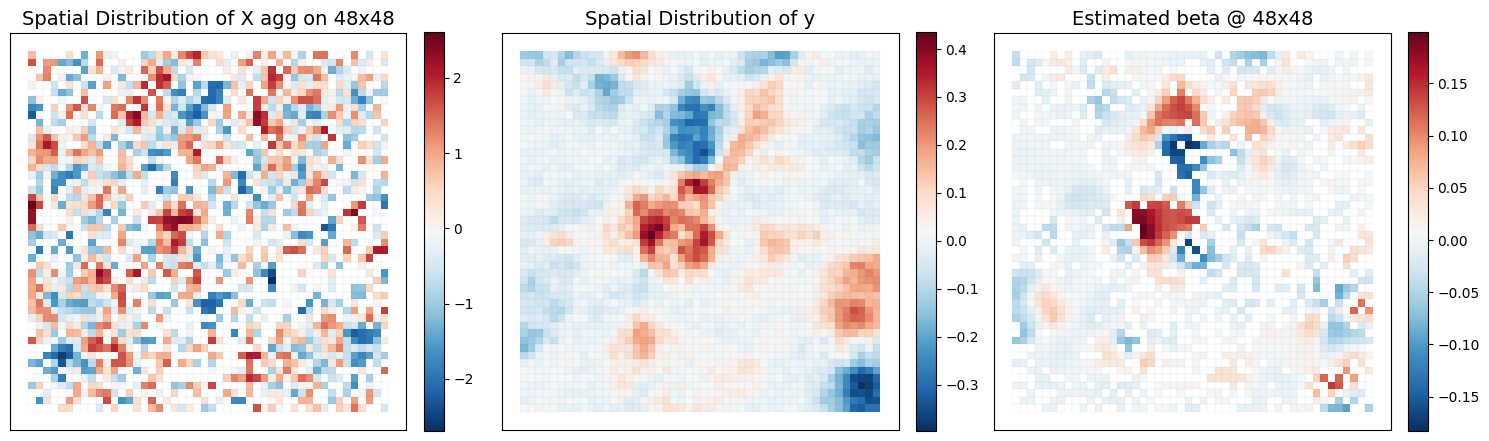

In [252]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
cmap1 = plt.cm.Reds
cmap2 = plt.cm.RdBu_r
cmap3 = plt.cm.RdBu_r

# Plot 1 - X_48x48
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[0])
plot1 = tracts_gdf48.plot(column="X_48x48", cmap=cmap2,
                          edgecolor="face", linewidth=0,
                          ax=ax[0], legend=False)
ax[0].set_title("Spatial Distribution of X agg on 48x48", fontsize=14)
ax[0].set_xticks([])
ax[0].set_yticks([])

# Colorbar for Plot 1
norm1 = mcolors.Normalize(vmin=tracts_gdf48["X_48x48"].min(), vmax=tracts_gdf48["X_48x48"].max())
sm1 = cm.ScalarMappable(cmap=cmap2, norm=norm1)
sm1.set_array([])
fig.colorbar(sm1, ax=ax[0], fraction=0.046, pad=0.04)

# Plot 2 - y_48x48
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[1])
plot2 = tracts_gdf48.plot(column="y_48x48", cmap=cmap2,
                          edgecolor="face", linewidth=0,
                          ax=ax[1], legend=False)
ax[1].set_title("Spatial Distribution of y", fontsize=14)
ax[1].set_xticks([])
ax[1].set_yticks([])

# Colorbar for Plot 2
norm2 = mcolors.Normalize(vmin=tracts_gdf48["y_48x48"].min(), vmax=tracts_gdf48["y_48x48"].max())
sm2 = cm.ScalarMappable(cmap=cmap2, norm=norm2)
sm2.set_array([])
fig.colorbar(sm2, ax=ax[1], fraction=0.046, pad=0.04)

# Plot 3 - est_beta48
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[2])
plot3 = tracts_gdf48.plot(column="est_beta48", cmap=cmap3,
                          edgecolor="face", linewidth=0,
                          ax=ax[2], legend=False)
ax[2].set_title("Estimated beta @ 48x48", fontsize=14)
ax[2].set_xticks([])
ax[2].set_yticks([])

# Colorbar for Plot 3
norm3 = mcolors.Normalize(vmin=tracts_gdf48["est_beta48"].min(), vmax=tracts_gdf48["est_beta48"].max())
sm3 = cm.ScalarMappable(cmap=cmap3, norm=norm3)
sm3.set_array([])
fig.colorbar(sm3, ax=ax[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


##### 24x24

In [253]:
sX1_24['params24'] = params24
sX1_24

tracts_gdf48_points = orig_tracts_gdf48.copy()
tracts_gdf48_points['geometry'] = tracts_gdf48_points['geometry'].centroid
spj24_48 = gpd.sjoin(tracts_gdf48_points, sX1_24, how='left', predicate='within')

In [254]:
tracts_gdf48["X_24x24"] = spj24_48["X"]
tracts_gdf48['y_24x24'] = spj24_48["y"]
tracts_gdf48['est_beta24'] = spj24_48["params24"]

In [255]:
spj24_48["X"]

0      -1.632562
1      -1.632562
2      -0.227612
3      -0.227612
4            NaN
          ...   
2299   -0.842849
2300    0.238502
2301    0.238502
2302   -0.078837
2303   -0.078837
Name: X, Length: 2304, dtype: float64

In [256]:
tracts_gdf48['est_beta24'].isna().sum()

np.int64(92)

In [257]:
# Spatial join X to 16x16 tracts 
spj16_X = gpd.sjoin(S1_gdf, tracts_gdf16, how='right', predicate='within')
agg_16_X = spj16_X.groupby('tract_id')[['X']].mean().reset_index()

In [258]:
# Spatial join y @ 48x48 to 16x16 tracts. Extract only the y from the df: line 2. 
spj16_y = gpd.sjoin(X_48x48, tracts_gdf16, how='right', predicate='within')
agg_16_y = spj16_y.groupby('tract_id_right')[['y']].mean().reset_index()

In [259]:
agg_16 = agg_16_X.merge(agg_16_y, left_on='tract_id', right_on='tract_id_right').drop('tract_id', axis=1)

In [260]:
# Aggregate X & Y within each 24x24 grid cell
GWR_16x16_gdf = tracts_gdf16.merge(agg_16, left_index=True, right_on='tract_id_right', how='left').reset_index(drop=True)

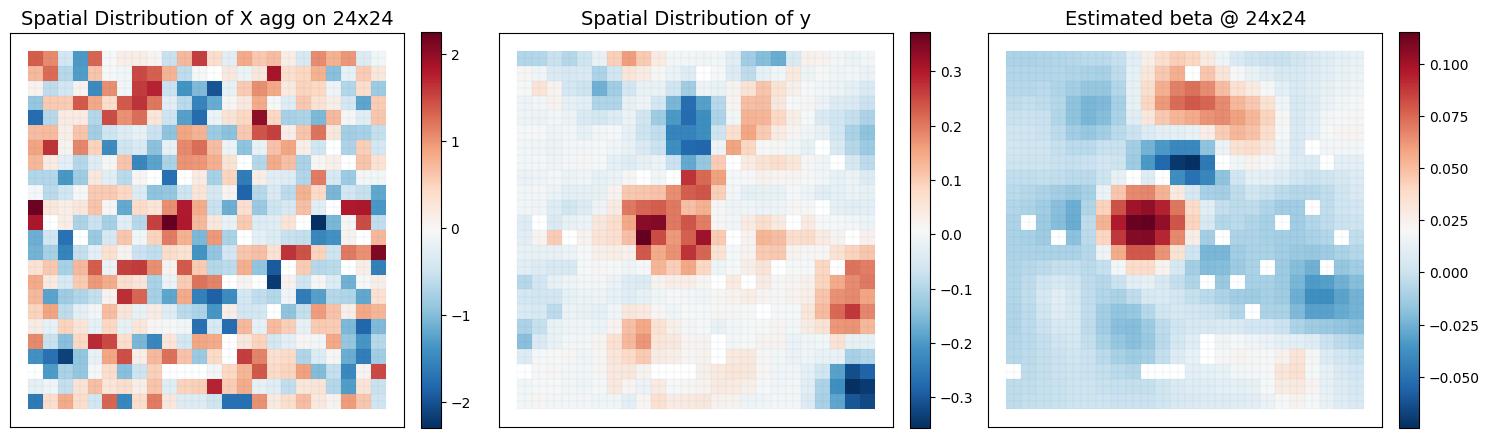

In [261]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
cmap1 = plt.cm.Reds
cmap2 = plt.cm.RdBu_r
cmap3 = plt.cm.RdBu_r

# Plot 1 - X_24x24
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[0])
plot1 = tracts_gdf48.plot(column="X_24x24", cmap=cmap2,
                          edgecolor="face", linewidth=0,
                          ax=ax[0], legend=False)
ax[0].set_title("Spatial Distribution of X agg on 24x24", fontsize=14)
ax[0].set_xticks([])
ax[0].set_yticks([])

# Colorbar for Plot 1
norm1 = mcolors.Normalize(vmin=tracts_gdf48["X_24x24"].min(), vmax=tracts_gdf48["X_24x24"].max())
sm1 = cm.ScalarMappable(cmap=cmap2, norm=norm1)
sm1.set_array([])
fig.colorbar(sm1, ax=ax[0], fraction=0.046, pad=0.04)

# Plot 2 - y_24x24
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[1])
plot2 = tracts_gdf48.plot(column="y_24x24", cmap=cmap2,
                          edgecolor="face", linewidth=0,
                          ax=ax[1], legend=False)
ax[1].set_title("Spatial Distribution of y", fontsize=14)
ax[1].set_xticks([])
ax[1].set_yticks([])

# Colorbar for Plot 2
norm2 = mcolors.Normalize(vmin=tracts_gdf48["y_24x24"].min(), vmax=tracts_gdf48["y_24x24"].max())
sm2 = cm.ScalarMappable(cmap=cmap2, norm=norm2)
sm2.set_array([])
fig.colorbar(sm2, ax=ax[1], fraction=0.046, pad=0.04)

# Plot 3 - est_beta24
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[2])
plot3 = tracts_gdf48.plot(column="est_beta24", cmap=cmap3,
                          edgecolor="face", linewidth=0,
                          ax=ax[2], legend=False)
ax[2].set_title("Estimated beta @ 24x24", fontsize=14)
ax[2].set_xticks([])
ax[2].set_yticks([])

# Colorbar for Plot 3
norm3 = mcolors.Normalize(vmin=tracts_gdf48["est_beta24"].min(), vmax=tracts_gdf48["est_beta24"].max())
sm3 = cm.ScalarMappable(cmap=cmap3, norm=norm3)
sm3.set_array([])
fig.colorbar(sm3, ax=ax[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


##### 16x16

In [262]:
sX1_16['params16'] = params16
sX1_16

tracts_gdf48_points = orig_tracts_gdf48.copy()
tracts_gdf48_points['geometry'] = tracts_gdf48_points['geometry'].centroid
spj16_48 = gpd.sjoin(tracts_gdf48_points, sX1_16, how='left', predicate='within')

In [263]:
tracts_gdf48["X_16x16"] = spj16_48["X"]
tracts_gdf48['y_16x16'] = spj16_48["y"]
tracts_gdf48['est_beta16'] = spj16_48["params16"]

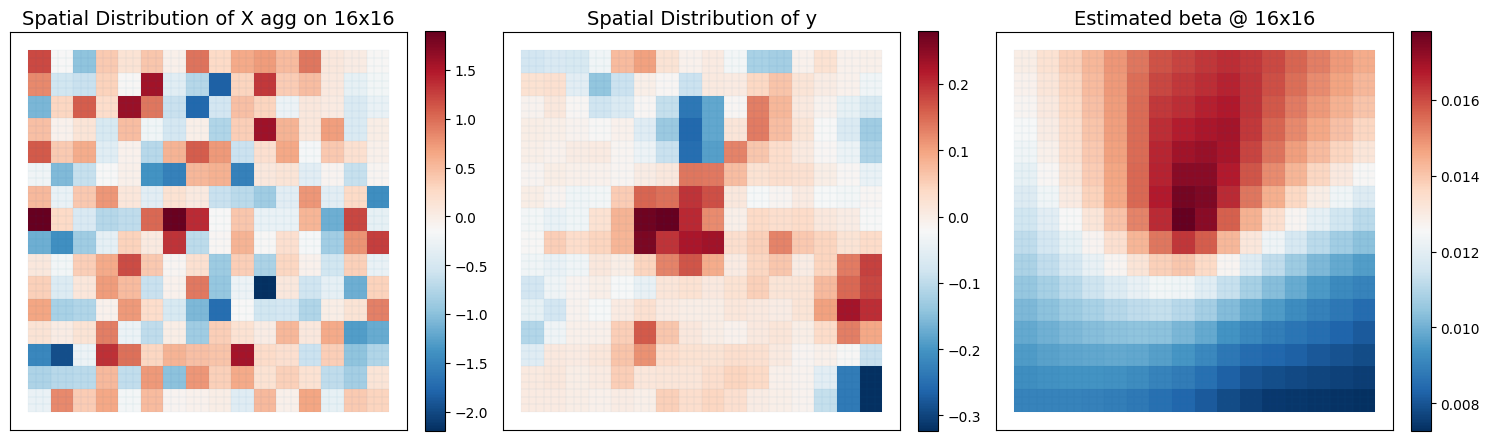

In [264]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
cmap1 = plt.cm.Reds
cmap2 = plt.cm.RdBu_r
cmap3 = plt.cm.RdBu_r

# Plot 1 - X_16x16
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[0])
plot1 = tracts_gdf48.plot(column="X_16x16", cmap=cmap2,
                          edgecolor="face", linewidth=0,
                          ax=ax[0], legend=False)
ax[0].set_title("Spatial Distribution of X agg on 16x16", fontsize=14)
ax[0].set_xticks([])
ax[0].set_yticks([])

# Colorbar for Plot 1
norm1 = mcolors.Normalize(vmin=tracts_gdf48["X_16x16"].min(), vmax=tracts_gdf48["X_16x16"].max())
sm1 = cm.ScalarMappable(cmap=cmap2, norm=norm1)
sm1.set_array([])
fig.colorbar(sm1, ax=ax[0], fraction=0.046, pad=0.04)

# Plot 2 - y_16x16
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[1])
plot2 = tracts_gdf48.plot(column="y_16x16", cmap=cmap2,
                          edgecolor="face", linewidth=0,
                          ax=ax[1], legend=False)
ax[1].set_title("Spatial Distribution of y", fontsize=14)
ax[1].set_xticks([])
ax[1].set_yticks([])

# Colorbar for Plot 2
norm2 = mcolors.Normalize(vmin=tracts_gdf48["y_16x16"].min(), vmax=tracts_gdf48["y_16x16"].max())
sm2 = cm.ScalarMappable(cmap=cmap2, norm=norm2)
sm2.set_array([])
fig.colorbar(sm2, ax=ax[1], fraction=0.046, pad=0.04)

# Plot 3 - est_beta16
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[2])
plot3 = tracts_gdf48.plot(column="est_beta16", cmap=cmap3,
                          edgecolor="face", linewidth=0,
                          ax=ax[2], legend=False)
ax[2].set_title("Estimated beta @ 16x16", fontsize=14)
ax[2].set_xticks([])
ax[2].set_yticks([])

# Colorbar for Plot 3
norm3 = mcolors.Normalize(vmin=tracts_gdf48["est_beta16"].min(), vmax=tracts_gdf48["est_beta16"].max())
sm3 = cm.ScalarMappable(cmap=cmap3, norm=norm3)
sm3.set_array([])
fig.colorbar(sm3, ax=ax[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


##### 12x12

In [265]:
sX1_12['params12'] = params12
sX1_12

tracts_gdf48_points = orig_tracts_gdf48.copy()
tracts_gdf48_points['geometry'] = tracts_gdf48_points['geometry'].centroid
spj12_48 = gpd.sjoin(tracts_gdf48_points, sX1_12, how='left', predicate='within')

In [266]:
tracts_gdf48["X_12x12"] = spj12_48["X"]
tracts_gdf48['y_12x12'] = spj12_48["y"]
tracts_gdf48['est_beta12'] = spj12_48["params12"]

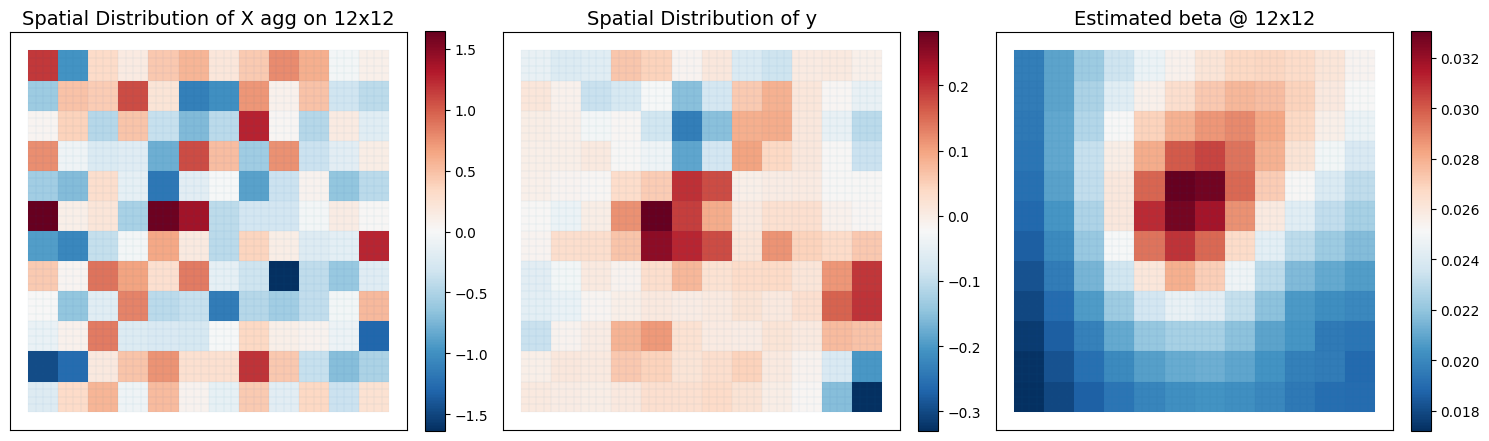

In [267]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
cmap1 = plt.cm.Reds
cmap2 = plt.cm.RdBu_r
cmap3 = plt.cm.RdBu_r

# Plot 1 - X_12x12
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[0])
plot1 = tracts_gdf48.plot(column="X_12x12", cmap=cmap2,
                          edgecolor="face", linewidth=0,
                          ax=ax[0], legend=False)
ax[0].set_title("Spatial Distribution of X agg on 12x12", fontsize=14)
ax[0].set_xticks([])
ax[0].set_yticks([])

# Colorbar for Plot 1
norm1 = mcolors.Normalize(vmin=tracts_gdf48["X_12x12"].min(), vmax=tracts_gdf48["X_12x12"].max())
sm1 = cm.ScalarMappable(cmap=cmap2, norm=norm1)
sm1.set_array([])
fig.colorbar(sm1, ax=ax[0], fraction=0.046, pad=0.04)

# Plot 2 - y_12x12
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[1])
plot2 = tracts_gdf48.plot(column="y_12x12", cmap=cmap2,
                          edgecolor="face", linewidth=0,
                          ax=ax[1], legend=False)
ax[1].set_title("Spatial Distribution of y", fontsize=14)
ax[1].set_xticks([])
ax[1].set_yticks([])

# Colorbar for Plot 2
norm2 = mcolors.Normalize(vmin=tracts_gdf48["y_12x12"].min(), vmax=tracts_gdf48["y_12x12"].max())
sm2 = cm.ScalarMappable(cmap=cmap2, norm=norm2)
sm2.set_array([])
fig.colorbar(sm2, ax=ax[1], fraction=0.046, pad=0.04)

# Plot 3 - est_beta12
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[2])
plot3 = tracts_gdf48.plot(column="est_beta12", cmap=cmap3,
                          edgecolor="face", linewidth=0,
                          ax=ax[2], legend=False)
ax[2].set_title("Estimated beta @ 12x12", fontsize=14)
ax[2].set_xticks([])
ax[2].set_yticks([])

# Colorbar for Plot 3
norm3 = mcolors.Normalize(vmin=tracts_gdf48["est_beta12"].min(), vmax=tracts_gdf48["est_beta12"].max())
sm3 = cm.ScalarMappable(cmap=cmap3, norm=norm3)
sm3.set_array([])
fig.colorbar(sm3, ax=ax[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


##### 8x8

In [268]:
sX1_8['params8'] = params8

tracts_gdf48_points = orig_tracts_gdf48.copy()
tracts_gdf48_points['geometry'] = tracts_gdf48_points['geometry'].centroid
spj8_48 = gpd.sjoin(tracts_gdf48_points, sX1_8, how='left', predicate='within')

In [269]:
tracts_gdf48["X_8x8"] = spj8_48["X"]
tracts_gdf48['y_8x8'] = spj8_48["y"]
tracts_gdf48['est_beta8'] = spj8_48["params8"]

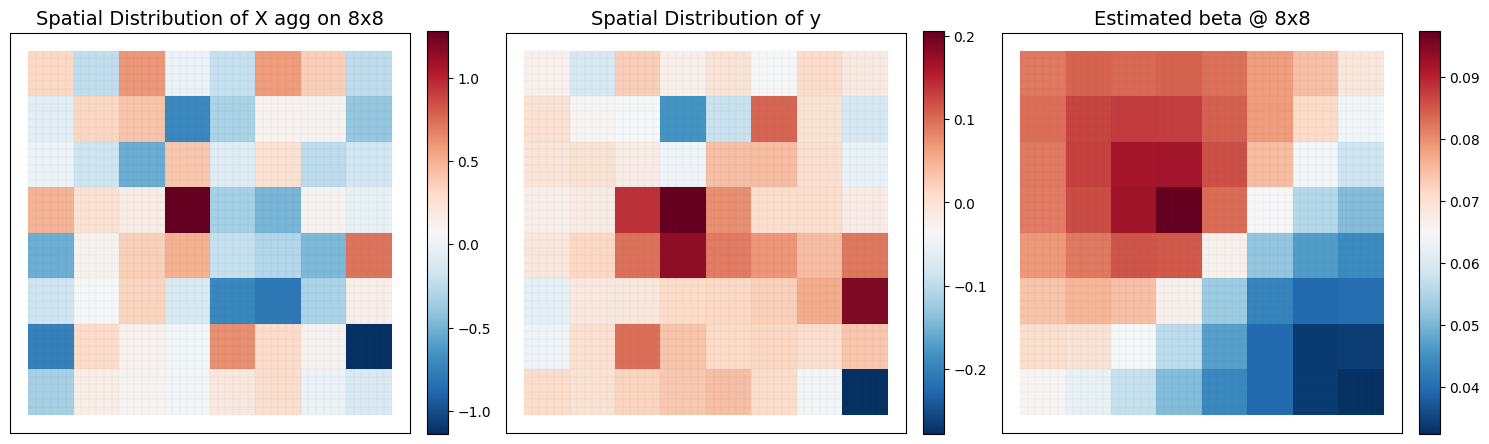

In [270]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
cmap1 = plt.cm.Reds
cmap2 = plt.cm.RdBu_r
cmap3 = plt.cm.RdBu_r

# Plot 1 - X_8x8
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[0])
plot1 = tracts_gdf48.plot(column="X_8x8", cmap=cmap2,
                          edgecolor="face", linewidth=0,
                          ax=ax[0], legend=False)
ax[0].set_title("Spatial Distribution of X agg on 8x8", fontsize=14)
ax[0].set_xticks([])
ax[0].set_yticks([])

# Colorbar for Plot 1
norm1 = mcolors.Normalize(vmin=tracts_gdf48["X_8x8"].min(), vmax=tracts_gdf48["X_8x8"].max())
sm1 = cm.ScalarMappable(cmap=cmap2, norm=norm1)
sm1.set_array([])
fig.colorbar(sm1, ax=ax[0], fraction=0.046, pad=0.04)

# Plot 2 - y_8x8
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[1])
plot2 = tracts_gdf48.plot(column="y_8x8", cmap=cmap2,
                          edgecolor="face", linewidth=0,
                          ax=ax[1], legend=False)
ax[1].set_title("Spatial Distribution of y", fontsize=14)
ax[1].set_xticks([])
ax[1].set_yticks([])

# Colorbar for Plot 2
norm2 = mcolors.Normalize(vmin=tracts_gdf48["y_8x8"].min(), vmax=tracts_gdf48["y_8x8"].max())
sm2 = cm.ScalarMappable(cmap=cmap2, norm=norm2)
sm2.set_array([])
fig.colorbar(sm2, ax=ax[1], fraction=0.046, pad=0.04)

# Plot 3 - est_beta8
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[2])
plot3 = tracts_gdf48.plot(column="est_beta8", cmap=cmap3,
                          edgecolor="face", linewidth=0,
                          ax=ax[2], legend=False)
ax[2].set_title("Estimated beta @ 8x8", fontsize=14)
ax[2].set_xticks([])
ax[2].set_yticks([])

# Colorbar for Plot 3
norm3 = mcolors.Normalize(vmin=tracts_gdf48["est_beta8"].min(), vmax=tracts_gdf48["est_beta8"].max())
sm3 = cm.ScalarMappable(cmap=cmap3, norm=norm3)
sm3.set_array([])
fig.colorbar(sm3, ax=ax[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


##### General VIz

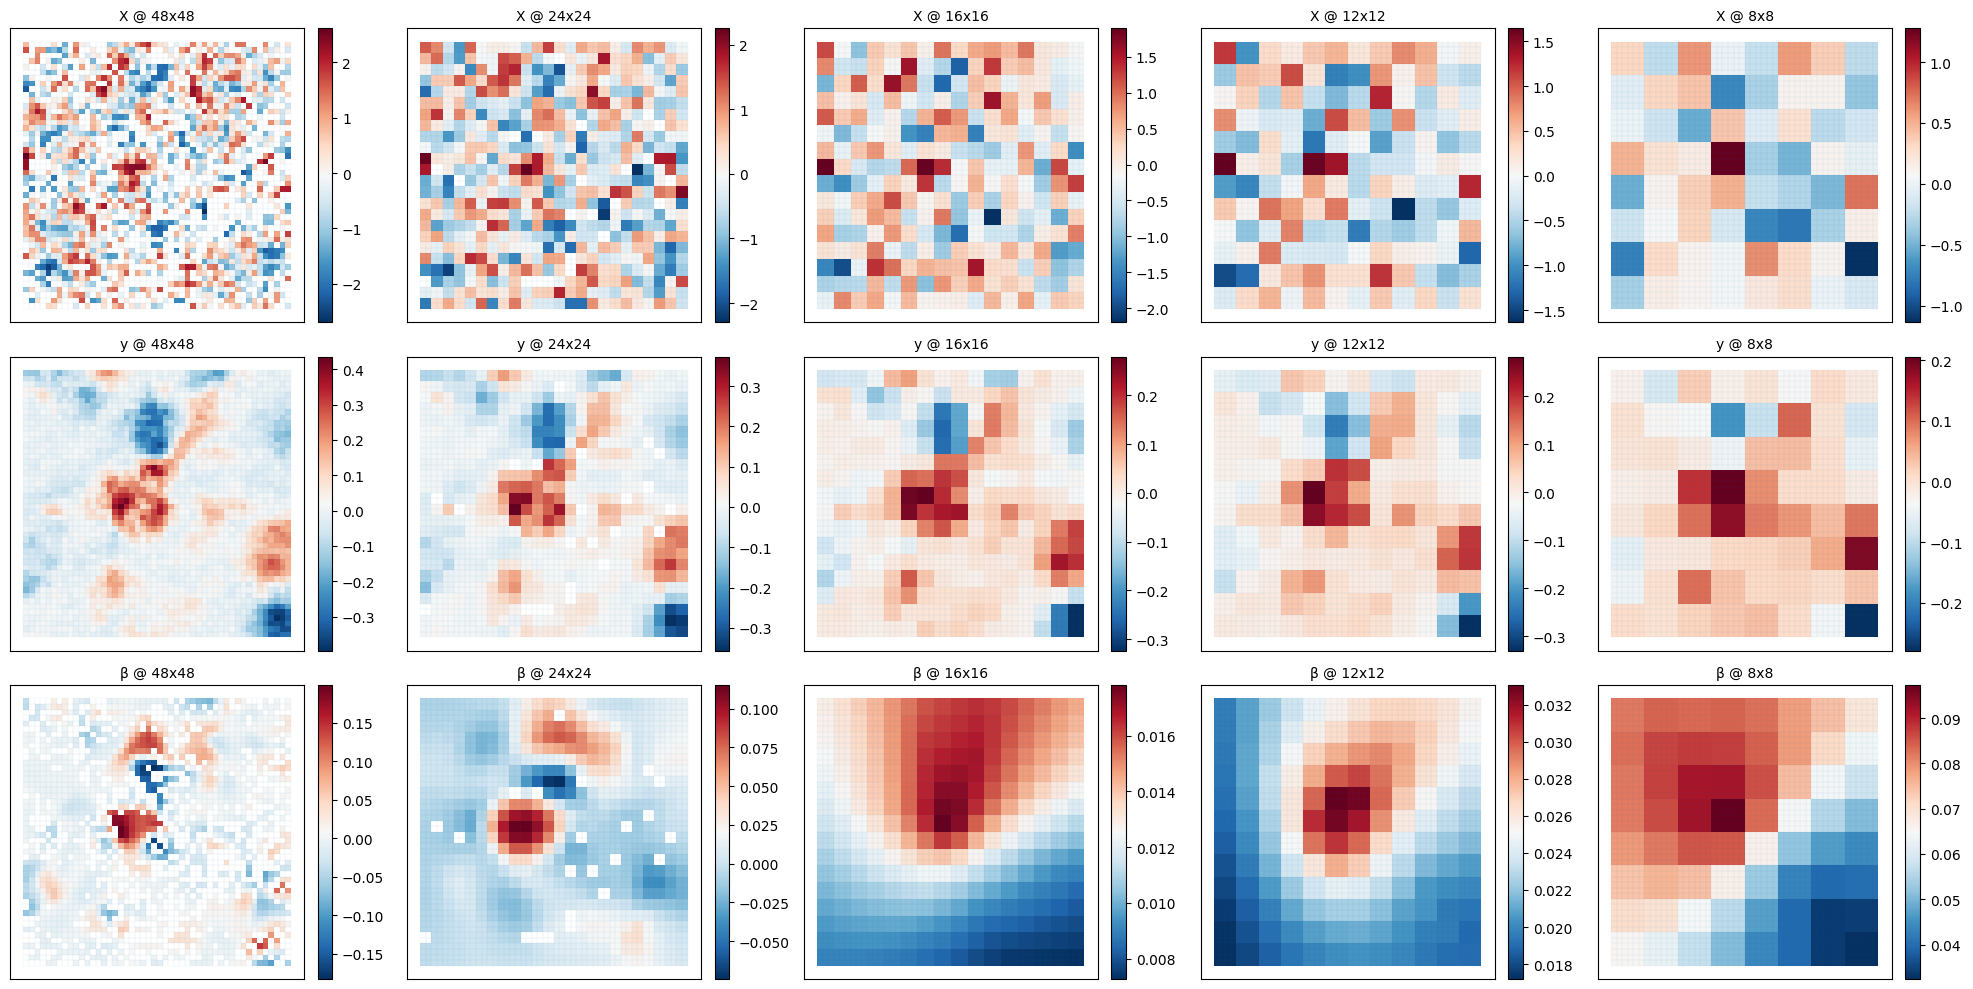

In [274]:
# Setup
res_labels = ["48x48", "24x24", "16x16", "12x12", "8x8"]
x_cols = ["X_48x48", "X_24x24", "X_16x16", "X_12x12", "X_8x8"]
y_cols = ["y_48x48", "y_24x24", "y_16x16", "y_12x12", "y_8x8"]
beta_cols = ["est_beta48", "est_beta24", "est_beta16", "est_beta12", "est_beta8"]
titles = ["X", "y", "β"]
cmap = plt.cm.RdBu_r

# Create a 3x5 grid
fig, axes = plt.subplots(3, 5, figsize=(20, 10))

# Loop through each row (X, y, β) and each column (resolutions)
for row, cols in enumerate([x_cols, y_cols, beta_cols]):
    for col, colname in enumerate(cols):
        ax = axes[row, col]
        
        # Base map (light boundary layer)
        tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax)
        
        # Choropleth plot
        tracts_gdf48.plot(column=colname, cmap=cmap, edgecolor="face", linewidth=0, ax=ax, legend=False)
        
        # Normalize for consistent colorbar
        norm = mcolors.Normalize(vmin=tracts_gdf48[colname].min(), vmax=tracts_gdf48[colname].max())
        sm = cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        fig.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
        
        # Title and layout tweaks
        ax.set_title(f"{titles[row]} @ {res_labels[col]}", fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])

plt.tight_layout()
plt.show()


## K = 500

In [275]:
# Define grid parameters and create tracts
xmin, xmax = 0, 600
ymin, ymax = 0, 600

# This is the step where I choose the size of the tracts 
x_step, y_step = 12.5, 12.5 # Creates a 48x48 grid, resulting in 2304 tracts
tracts_gdf48 = create_tracts(xmin, xmax, ymin, ymax, x_step, y_step)

orig_tracts_gdf48 = create_tracts(xmin, xmax, ymin, ymax, x_step, y_step)

In [276]:
B = beta_surface_scaled.flatten()

nbrs_S2 = NearestNeighbors(n_neighbors=500).fit(loc1)

smoothed_S1_to_S2 = np.zeros(len(S2))

for i in range(len(S2)):
    distances_S1_to_S2, indices_S1_to_S2 = nbrs_S2.kneighbors([loc2[i]])
    smoothed_S1_to_S2[i] = np.mean(S1[indices_S1_to_S2[0]].flatten())


np.random.seed(26)

error_term = np.random.normal(0, 0.01, len(S2))

y_orig = B * smoothed_S1_to_S2 + error_term

<Figure size 1000x800 with 0 Axes>

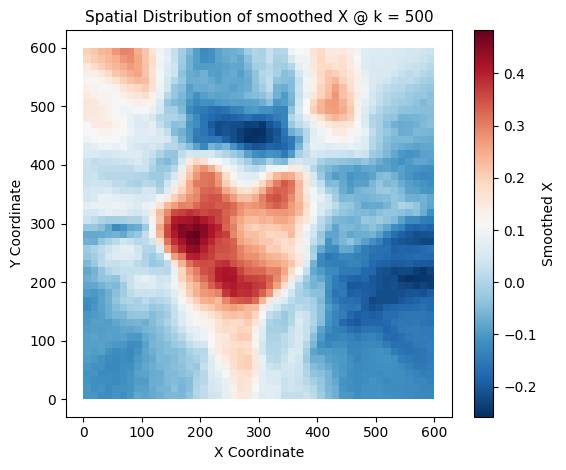

In [277]:
plt.figure(figsize=(10, 8))

# Assign smoothed values
tracts_gdf48['sX'] = smoothed_S1_to_S2

# Plot the choropleth map
ax = tracts_gdf48.plot(
    column="sX",
    cmap=plt.cm.RdBu_r,
    edgecolor="face",
    linewidth=0,
    legend=False
)

# Create scalar mappable for colorbar
norm = mcolors.Normalize(
    vmin=tracts_gdf48["sX"].min(),
    vmax=tracts_gdf48["sX"].max()
)
sm = cm.ScalarMappable(norm=norm, cmap=plt.cm.RdBu_r)
sm._A = []  # workaround to enable colorbar for ScalarMappable

# Add colorbar to the plot
cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("Smoothed X")

# Add labels and title
ax.set_xlabel("X Coordinate")
ax.set_ylabel("Y Coordinate")
ax.set_title("Spatial Distribution of smoothed X @ k = 500", fontsize=11)

plt.tight_layout()


<Figure size 1000x800 with 0 Axes>

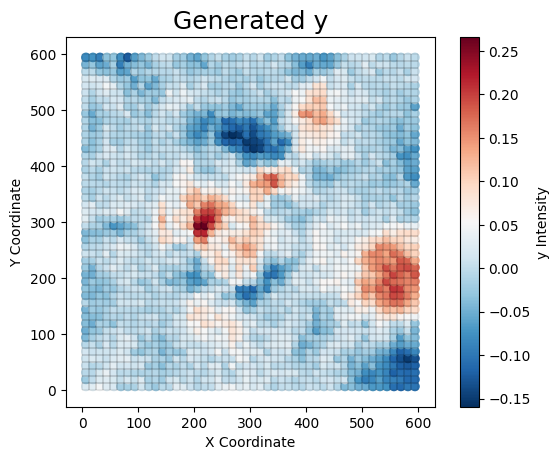

In [278]:
plt.figure(figsize=(10, 8))
tracts_gdf48.boundary.plot(edgecolor="black", linewidth=0.1)  # Plot grid boundaries

# Set colormap to "RdBu_r" (reversed Red-Blue to match the desired effect)
cmap = plt.cm.RdBu_r

# # Scatter plot with diverging colormap
sc = plt.scatter(loc2[:, 0], loc2[:, 1], c=y_orig, cmap=cmap, edgecolor=None)

# Add Colorbar
plt.colorbar(sc, label="y Intensity")

# Labels and Title
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("Generated y", fontsize=18)

plt.show()

In [279]:
r2_list = []
srmse_list = []
bw_list = []
aicc_list = []

part1 = list(range(2, 11, 1))
part2 = list(range(15, 101, 5))
part3 = list(range(125, 1001, 25))

k_values = part1 + part2 + part3

for k in k_values:
    # --- 1. Smooth point-level X (S1) to polygon-level (S2 centroids) ---
    nbrs_S1 = NearestNeighbors(n_neighbors=k).fit(loc1)  # loc1 = point locations
    smoothed_S1_to_S2 = np.zeros(len(loc2))  # loc2 = tract centroids
    
    for i in range(len(loc2)):
        distances_S1_to_S2, indices_S1_to_S2 = nbrs_S1.kneighbors([loc2[i]])
        bw_S1 = distances_S1_to_S2[0][-1]
        weights_X = np.exp(-0.5 * (distances_S1_to_S2[0] / bw_S1) ** 2)
        local_X = S1[indices_S1_to_S2[0]]  # S1 = point-level X
        smoothed_S1_to_S2[i] = np.sum(local_X * weights_X) / np.sum(weights_X)
    
    # --- 3. Fit GWR at polygon level ---
    coords = loc2  # tract centroids
    X_design = smoothed_S1_to_S2.reshape(-1,1)
    y_design = y_orig.reshape(-1,1)
    
    bw = Sel_BW(coords, y_design, X_design, constant=False).search(bw_min=2)
    gwr_model = GWR(coords, y_design, X_design, bw, constant=False)
    gwr_results = gwr_model.fit()
    
    # --- 4. Extract metrics ---
    y_pred = gwr_results.predy.flatten()
    r2 = r2_score(y_orig, y_pred)
    srmse = np.sqrt(mean_squared_error(y_orig, y_pred)) / np.std(y_orig)
    aicc = gwr_results.aicc
    
    r2_list.append(r2)
    srmse_list.append(srmse)
    bw_list.append(bw)
    aicc_list.append(aicc)
    
    print(f"k={k}: R2={r2:.4f}, SRMSE={srmse:.4f}, AICc={aicc:.4f}, BW={bw:.4f}")

k=2: R2=0.5193, SRMSE=0.6933, AICc=-7779.0338, BW=17.0000
k=3: R2=0.5466, SRMSE=0.6734, AICc=-7925.3010, BW=15.0000
k=4: R2=0.5757, SRMSE=0.6514, AICc=-8081.6065, BW=14.0000
k=5: R2=0.5783, SRMSE=0.6494, AICc=-8105.6335, BW=15.0000
k=6: R2=0.5853, SRMSE=0.6439, AICc=-8158.0646, BW=18.0000
k=7: R2=0.5899, SRMSE=0.6404, AICc=-8185.7788, BW=15.0000
k=8: R2=0.5852, SRMSE=0.6440, AICc=-8167.6695, BW=15.0000
k=9: R2=0.5896, SRMSE=0.6406, AICc=-8200.5175, BW=15.0000
k=10: R2=0.5906, SRMSE=0.6398, AICc=-8209.7796, BW=15.0000
k=15: R2=0.6260, SRMSE=0.6116, AICc=-8427.8704, BW=18.0000
k=20: R2=0.6393, SRMSE=0.6006, AICc=-8505.7686, BW=14.0000
k=25: R2=0.6486, SRMSE=0.5928, AICc=-8574.1136, BW=14.0000
k=30: R2=0.6844, SRMSE=0.5618, AICc=-8817.6990, BW=14.0000
k=35: R2=0.7113, SRMSE=0.5373, AICc=-9011.7201, BW=14.0000
k=40: R2=0.7268, SRMSE=0.5227, AICc=-9134.0272, BW=17.0000
k=45: R2=0.7334, SRMSE=0.5163, AICc=-9183.1711, BW=17.0000
k=50: R2=0.7483, SRMSE=0.5017, AICc=-9310.2888, BW=18.0000
k=55:

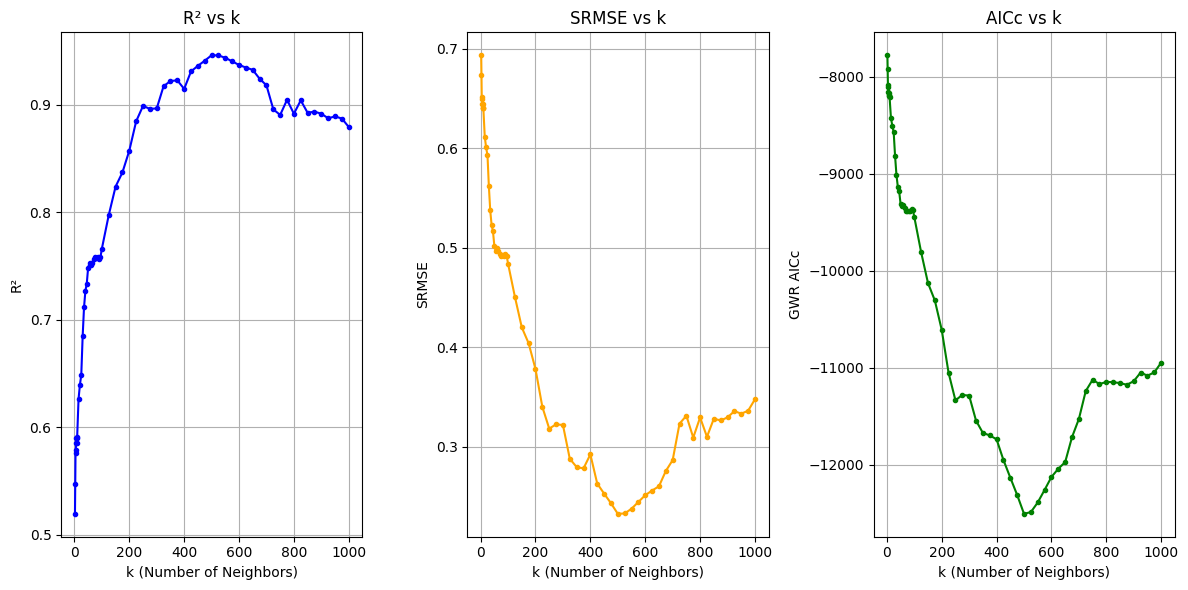

In [280]:
plt.figure(figsize=(12, 6))

# Plot R²
plt.subplot(1, 3, 1)
plt.plot(k_values, r2_list, color='blue', marker='.')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('R²')
plt.title('R² vs k')
plt.grid()

# Plot SRMSE
plt.subplot(1, 3, 2)
plt.plot(k_values, srmse_list, color='orange', marker='.')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('SRMSE')
plt.title('SRMSE vs k')
plt.grid()


# Plot AIcc
plt.subplot(1, 3, 3)
plt.plot(k_values, aicc_list, color='green', marker='.')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('GWR AICc')
plt.title('AICc vs k')
plt.grid()

plt.tight_layout()
plt.show()

### Aggregations

#### 48x48

In [281]:
S1_gdf = gpd.GeoDataFrame({'X': S1, 'geometry': gpd.points_from_xy(loc1[:, 0], loc1[:, 1])})

In [282]:
S1_gdf

X                 geometry
0    -1.217070   POINT (32.857 197.992)
1    -0.725300  POINT (204.138 595.669)
2    -0.125980  POINT (536.507 155.182)
3     0.505422    POINT (6.775 422.464)
4     1.787147  POINT (396.912 484.592)
...        ...                      ...
3595 -1.011250   POINT (237.294 369.16)
3596  1.698226  POINT (253.043 288.905)
3597 -1.774934  POINT (342.353 125.307)
3598 -0.584132   POINT (394.937 184.82)
3599 -1.251444     POINT (5.464 75.523)

[3600 rows x 2 columns]

In [283]:
# Spatial join: assign S1 points to 48x48 tracts
S1_agg = gpd.sjoin(S1_gdf, tracts_gdf48, how="left", predicate="within")

In [284]:
S1_agg = S1_agg.groupby("tract_id")["X"].mean().reset_index()
X_48x48 = tracts_gdf48.merge(S1_agg, on="tract_id", how="left")
X_48x48['y'] = y_orig

In [285]:
sX1_48 = X_48x48.copy()
sX1_48.isna().sum()

tract_id      0
geometry      0
sX            0
X           806
y             0
dtype: int64

In [286]:
sX1_48.dropna(inplace=True)
sX1_48.isna().sum()

tract_id    0
geometry    0
sX          0
X           0
y           0
dtype: int64

In [287]:
gwr_X  = sX1_48['X'].values.reshape(-1,1)
gwr_y = sX1_48['y'].values.reshape(-1, 1) # using aggregated y
coords = np.array([[point.x, point.y] for point in sX1_48['geometry'].centroid])
gwr_X.shape, gwr_y.shape

((1498, 1), (1498, 1))

In [288]:
gwr_selector = Sel_BW(coords, gwr_y, gwr_X, constant=False)
gwr_bw48 = gwr_selector.search(bw_min=2)
gwr_results = GWR(coords, gwr_y, gwr_X, gwr_bw48, constant=False).fit()
print(gwr_bw48)

22.0


In [289]:
params48 = gwr_results.params
y_pred48 = gwr_results.predy
aicc_gwr48 = gwr_results.aicc
r2_48 = gwr_results.R2

print(gwr_results.aicc), print(gwr_results.R2);

-4885.76038616141
0.3731178821688955


In [290]:
## calculating the standardized root mean squared error
y_true48 = sX1_48['y'].values.reshape(-1,1)
rmse48  = np.sqrt(np.mean((y_true48 - y_pred48)**2))
std_dev48 = np.std(y_true48)
srmse48 = rmse48 / std_dev48
srmse48, rmse48

(np.float64(0.7917588760671422), np.float64(0.041258147146107906))

#### 24x24

In [291]:
x_step, y_step = 25, 25 # Creates a 24x24 grid, resulting in 576 tracts cell divisions
tracts_gdf24 = create_tracts(xmin, xmax, ymin, ymax, x_step, y_step)

loc2_24 = np.array([[point.x, point.y] for point in tracts_gdf24.geometry.centroid])

In [292]:
X_48x48['geometry'] = X_48x48.geometry.centroid

In [293]:
# Spatial join X to 24x24 tracts 
spj24_X = gpd.sjoin(S1_gdf, tracts_gdf24, how='right', predicate='within')
agg_24_X = spj24_X.groupby('tract_id')[['X']].mean().reset_index()

In [294]:
# Spatial join y @ 48x48 to 24x24 tracts. Extract only the y from the df: line 2. 
spj24_y = gpd.sjoin(X_48x48, tracts_gdf24, how='right', predicate='within')
agg_24_y = spj24_y.groupby('tract_id_right')[['y']].mean().reset_index()

In [295]:
agg_24 = agg_24_X.merge(agg_24_y, left_on='tract_id', right_on='tract_id_right').drop('tract_id', axis=1)

In [296]:
# Aggregate X & Y within each 24x24 grid cell
GWR_24x24_gdf = tracts_gdf24.merge(agg_24, left_index=True, right_on='tract_id_right', how='left').reset_index(drop=True)

In [297]:
sX1_24 = GWR_24x24_gdf.copy()
sX1_24.isna().sum()

tract_id           0
geometry           0
X                 23
tract_id_right     0
y                  0
dtype: int64

In [298]:
sX1_24.dropna(inplace=True)
sX1_24.isna().sum()

tract_id          0
geometry          0
X                 0
tract_id_right    0
y                 0
dtype: int64

In [299]:
gwr_X  = sX1_24['X'].values.reshape(-1,1)
gwr_y = sX1_24['y'].values.reshape(-1, 1) # using aggregated y
coords = np.array([[point.x, point.y] for point in sX1_24['geometry'].centroid])
gwr_X.shape, gwr_y.shape

((553, 1), (553, 1))

In [300]:
gwr_selector = Sel_BW(coords, gwr_y, gwr_X, constant=False)
gwr_bw24 = gwr_selector.search(bw_min=2)
gwr_results = GWR(coords, gwr_y, gwr_X, gwr_bw24, constant=False).fit()
print(gwr_bw24)

54.0


In [301]:
params24 = gwr_results.params
y_pred24 = gwr_results.predy
aicc_gwr24 = gwr_results.aicc
r2_24 = gwr_results.R2

print(gwr_results.aicc), print(gwr_results.R2);

-1727.3040175599347
0.10911152258254264


In [302]:
## calculating the standardized root mean squared error
y_true24 = sX1_24['y'].values.reshape(-1,1)
rmse24  = np.sqrt(np.mean((y_true24 - y_pred24)**2))
std_dev24 = np.std(y_true24)
srmse24 = rmse24 / std_dev24
srmse24, rmse24

(np.float64(0.9438688878321275), np.float64(0.04794878752240604))

#### 16x16

In [303]:
x_step, y_step = 37.5, 37.5 # Creates a 32x32 grid, resulting in 576 tracts cell divisions
tracts_gdf16 = create_tracts(xmin, xmax, ymin, ymax, x_step, y_step)

loc2_16 = np.array([[point.x, point.y] for point in tracts_gdf16.geometry.centroid])

In [304]:
X_48x48['geometry'] = X_48x48.geometry.centroid

In [305]:
# Spatial join X to 16x16 tracts 
spj16_X = gpd.sjoin(S1_gdf, tracts_gdf16, how='right', predicate='within')
agg_16_X = spj16_X.groupby('tract_id')[['X']].mean().reset_index()

In [306]:
# Spatial join y @ 48x48 to 16x16 tracts. Extract only the y from the df: line 2. 
spj16_y = gpd.sjoin(X_48x48, tracts_gdf16, how='right', predicate='within')
agg_16_y = spj16_y.groupby('tract_id_right')[['y']].mean().reset_index()

In [307]:
agg_16 = agg_16_X.merge(agg_16_y, left_on='tract_id', right_on='tract_id_right').drop('tract_id', axis=1)

In [308]:
# Aggregate X & y within each 24x24 grid cell
GWR_16x16_gdf = tracts_gdf16.merge(agg_16, left_index=True, right_on='tract_id_right', how='left').reset_index(drop=True)

In [309]:
sX1_16 = GWR_16x16_gdf.copy()

gwr_X  = sX1_16['X'].values.reshape(-1,1)
gwr_y = sX1_16['y'].values.reshape(-1, 1) # using aggregated y
coords = np.array([[point.x, point.y] for point in sX1_16['geometry'].centroid])
gwr_X.shape, gwr_y.shape

((256, 1), (256, 1))

In [310]:
gwr_selector = Sel_BW(coords, gwr_y, gwr_X, constant=False)
gwr_bw16 = gwr_selector.search(bw_min=2)
gwr_results = GWR(coords, gwr_y, gwr_X, gwr_bw16, constant=False).fit()
print(gwr_bw16)

251.0


In [311]:
params16 = gwr_results.params
y_pred16 = gwr_results.predy
aicc_gwr16 = gwr_results.aicc
r2_16 = gwr_results.R2

print(gwr_results.aicc), print(gwr_results.R2);

-812.933423723712
-0.027696365617974728


In [312]:
## calculating the standardized root mean squared error
y_true16 = sX1_16['y'].values.reshape(-1,1)
rmse16  = np.sqrt(np.mean((y_true16 - y_pred16)**2))
std_dev16 = np.std(y_true16)
srmse16 = rmse16 / std_dev16
srmse16, rmse16

(np.float64(1.013753602024661), np.float64(0.04886255333807039))

#### 12x12

In [313]:
# This is the step where I choose the size of the tracts 
x_step, y_step = 50, 50  # Creates a 12x12 grid, resulting in 144 tracts cell divisions
tracts_gdf12 = create_tracts(xmin, xmax, ymin, ymax, x_step, y_step)

loc2_12 = np.array([[point.x, point.y] for point in tracts_gdf12.geometry.centroid])

In [314]:
X_48x48['geometry'] = X_48x48.geometry.centroid

In [315]:
# Spatial join X to 12x12 tracts 
spj12_X = gpd.sjoin(S1_gdf, tracts_gdf12, how='right', predicate='within')
agg_12_X = spj12_X.groupby('tract_id')[['X']].mean().reset_index()

In [316]:
# Spatial join y @ 48x48 to 12x12 tracts. Extract only the y from the df: line 2. 
spj12_y = gpd.sjoin(X_48x48, tracts_gdf12, how='right', predicate='within')
agg_12_y = spj12_y.groupby('tract_id_right')[['y']].mean().reset_index()

In [317]:
agg_12 = agg_12_X.merge(agg_12_y, left_on='tract_id', right_on='tract_id_right').drop('tract_id', axis=1)

In [318]:
# Aggregate X & Y within each 24x24 grid cell
GWR_12x12_gdf = tracts_gdf12.merge(agg_12, left_index=True, right_on='tract_id_right', how='left').reset_index(drop=True)

In [319]:
sX1_12 = GWR_12x12_gdf.copy()
sX1_12.isna().sum()

tract_id          0
geometry          0
X                 0
tract_id_right    0
y                 0
dtype: int64

In [320]:
gwr_X  = sX1_12['X'].values.reshape(-1,1)
gwr_y = sX1_12['y'].values.reshape(-1, 1) # using aggregated y
coords = np.array([[point.x, point.y] for point in sX1_12['geometry'].centroid])
gwr_X.shape, gwr_y.shape

((144, 1), (144, 1))

In [321]:
gwr_selector = Sel_BW(coords, gwr_y, gwr_X, constant=False)
gwr_bw12 = gwr_selector.search(bw_min=2)
gwr_results = GWR(coords, gwr_y, gwr_X, gwr_bw12, constant=False).fit()
print(gwr_bw12)

133.0


In [322]:
params12 = gwr_results.params
y_pred12 = gwr_results.predy
aicc_gwr12 = gwr_results.aicc
r2_12 = gwr_results.R2

print(gwr_results.aicc), print(gwr_results.R2);

-466.2843839799738
-0.01682440842111732


In [323]:
## calculating the standardized root mean squared error
y_true12 = sX1_12['y'].values.reshape(-1,1)
rmse12  = np.sqrt(np.mean((y_true12 - y_pred12)**2))
std_dev12 = np.std(y_true12)
srmse12 = rmse12 / std_dev12
srmse12, rmse12

(np.float64(1.0083771161728718), np.float64(0.04678963987078271))

##### 8x8

In [324]:
# This is the step where I choose the size of the tracts 
x_step, y_step = 75, 75  # Creates a 8x8 grid, resulting in 256 tracts cell divisions
tracts_gdf8 = create_tracts(xmin, xmax, ymin, ymax, x_step, y_step)

loc2_8 = np.array([[point.x, point.y] for point in tracts_gdf8.geometry.centroid])

In [325]:
X_48x48['geometry'] = X_48x48.geometry.centroid

In [326]:
# Spatial join X to 8x8 tracts 
spj8_X = gpd.sjoin(S1_gdf, tracts_gdf8, how='right', predicate='within')
agg_8_X = spj8_X.groupby('tract_id')[['X']].mean().reset_index()

In [327]:
# Spatial join y @ 48x48 to 8x8 tracts. Extract only the y from the df: line 2. 
spj8_y = gpd.sjoin(X_48x48, tracts_gdf8, how='right', predicate='within')
agg_8_y = spj8_y.groupby('tract_id_right')[['y']].mean().reset_index()

In [328]:
agg_8 = agg_8_X.merge(agg_8_y, left_on='tract_id', right_on='tract_id_right').drop('tract_id', axis=1)

In [329]:
# Aggregate X & Y within each 24x24 grid cell
GWR_8x8_gdf = tracts_gdf8.merge(agg_8, left_index=True, right_on='tract_id_right', how='left').reset_index(drop=True)

In [330]:
sX1_8 = GWR_8x8_gdf.copy()
sX1_8.isna().sum()

tract_id          0
geometry          0
X                 0
tract_id_right    0
y                 0
dtype: int64

In [331]:
gwr_X  = sX1_8['X'].values.reshape(-1,1)
gwr_y = sX1_8['y'].values.reshape(-1, 1) # using aggregated y
coords = np.array([[point.x, point.y] for point in sX1_8['geometry'].centroid])
gwr_X.shape, gwr_y.shape

((64, 1), (64, 1))

In [332]:
gwr_selector = Sel_BW(coords, gwr_y, gwr_X, constant=False)
gwr_bw8 = gwr_selector.search(bw_min=2)
gwr_results = GWR(coords, gwr_y, gwr_X, gwr_bw8, constant=False).fit()
print(gwr_bw8)

63.0


In [333]:
params8 = gwr_results.params
y_pred8 = gwr_results.predy
aicc_gwr8 = gwr_results.aicc
r2_8 = gwr_results.R2

print(gwr_results.aicc), print(gwr_results.R2);

-222.36564896522455
0.03895423602086456


In [334]:
## calculating the standardized root mean squared error
y_true8 = sX1_8['y'].values.reshape(-1,1)
rmse8  = np.sqrt(np.mean((y_true8 - y_pred8)**2))
std_dev8 = np.std(y_true8)
srmse8 = rmse8 / std_dev8
srmse8, rmse8

(np.float64(0.9803294160531628), np.float64(0.040482099888814925))

#### table

In [335]:
grid_sizes = [s for s in ['48x48', '24x24', '16x16', '12x12', '8x8'] for _ in range(3)] 
metrics = ['R²', 'SRMSE', 'BW'] * 5  # Repeat R² and SRMSE for each grid size
# values = [r2_48, srmse48, r2_40, srmse40, r2_32, srmse32, r2_24, srmse24, r2_16, srmse16, r2_8, srmse8]
r2 = [r2_48, r2_24, r2_16, r2_12, r2_8]
srmse = [ srmse48, srmse24, srmse16,srmse12, srmse8]
bw = [gwr_bw48, gwr_bw24, gwr_bw16, gwr_bw12, gwr_bw8]

values = []
for i in range(5):
    values.extend([r2[i], srmse[i], bw[i]])

In [336]:
len(metrics), len(grid_sizes), len(values)


(15, 15, 15)

In [337]:
df = pd.DataFrame({
    'Metric': metrics, # Repeat each grid size for R², SRMSE, BW,
    'Grid Size': grid_sizes,
    'Value': np.round(values, 4)
})

In [338]:
# Reset index to start from 1
df.index = range(1, len(df) + 1)

# Pivot the table to get desired format
df_pivot = df.pivot(index='Metric', columns='Grid Size', values='Value')

df_pivot = df_pivot.reindex(columns=['48x48', '24x24', '16x16', '12x12', '8x8'])
# Remove the "Metric" label
df_pivot.index.name = None
df_pivot

Grid Size    48x48    24x24     16x16     12x12      8x8
BW         22.0000  54.0000  251.0000  133.0000  63.0000
R²          0.3731   0.1091   -0.0277   -0.0168   0.0390
SRMSE       0.7918   0.9439    1.0138    1.0084   0.9803

##### table

In [339]:
grid_sizes = [s for s in ['48x48', '24x24', '16x16', '12x12', '8x8'] for _ in range(3)] 
metrics = ['R²', 'SRMSE', 'BW'] * 5  # Repeat R² and SRMSE for each grid size
# values = [r2_48, srmse48, r2_40, srmse40, r2_32, srmse32, r2_24, srmse24, r2_16, srmse16, r2_8, srmse8]
r2 = [r2_48, r2_24, r2_16, r2_12, r2_8]
srmse = [ srmse48, srmse24, srmse16,srmse12, srmse8]
bw = [gwr_bw48, gwr_bw24, gwr_bw16, gwr_bw12, gwr_bw8]

values = []
for i in range(5):
    values.extend([r2[i], srmse[i], bw[i]])

In [340]:
len(metrics), len(grid_sizes), len(values)


(15, 15, 15)

In [341]:
df = pd.DataFrame({
    'Metric': metrics, # Repeat each grid size for R², SRMSE, BW,
    'Grid Size': grid_sizes,
    'Value': np.round(values, 4)
})

In [342]:
# Reset index to start from 1
df.index = range(1, len(df) + 1)

# Pivot the table to get desired format
df_pivot = df.pivot(index='Metric', columns='Grid Size', values='Value')

df_pivot = df_pivot.reindex(columns=['48x48', '24x24', '16x16', '12x12', '8x8'])
# Remove the "Metric" label
df_pivot.index.name = None
df_pivot

Grid Size    48x48    24x24     16x16     12x12      8x8
BW         22.0000  54.0000  251.0000  133.0000  63.0000
R²          0.3731   0.1091   -0.0277   -0.0168   0.0390
SRMSE       0.7918   0.9439    1.0138    1.0084   0.9803

#### Visualizations

##### 48x48

In [343]:
loc2_48 = np.array([[point.x, point.y] for point in sX1_48.geometry.centroid])

In [344]:
sX1_48['params48'] = params48
sX1_48

tracts_gdf48_points = tracts_gdf48.copy()
tracts_gdf48_points['geometry'] = tracts_gdf48_points['geometry'].centroid
spj48_48 = gpd.sjoin(tracts_gdf48_points, sX1_48, how='left', predicate='within')
spj48_48['y'] = y_orig

tracts_gdf48["X_48x48"] = spj48_48["X"]
tracts_gdf48['y_48x48'] = spj48_48["y"]
tracts_gdf48['est_beta48'] = spj48_48["params48"]


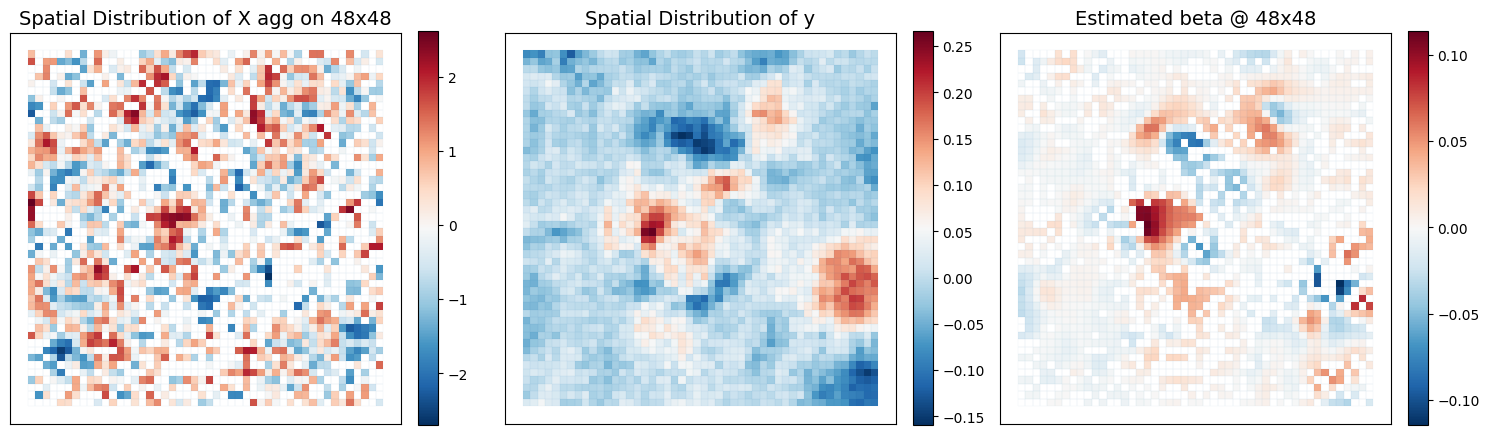

In [345]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
cmap1 = plt.cm.Reds
cmap2 = plt.cm.RdBu_r
cmap3 = plt.cm.RdBu_r

# Plot 1 - X_48x48
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[0])
plot1 = tracts_gdf48.plot(column="X_48x48", cmap=cmap2,
                          edgecolor="face", linewidth=0,
                          ax=ax[0], legend=False)
ax[0].set_title("Spatial Distribution of X agg on 48x48", fontsize=14)
ax[0].set_xticks([])
ax[0].set_yticks([])

# Colorbar for Plot 1
norm1 = mcolors.Normalize(vmin=tracts_gdf48["X_48x48"].min(), vmax=tracts_gdf48["X_48x48"].max())
sm1 = cm.ScalarMappable(cmap=cmap2, norm=norm1)
sm1.set_array([])
fig.colorbar(sm1, ax=ax[0], fraction=0.046, pad=0.04)

# Plot 2 - y_48x48
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[1])
plot2 = tracts_gdf48.plot(column="y_48x48", cmap=cmap2,
                          edgecolor="face", linewidth=0,
                          ax=ax[1], legend=False)
ax[1].set_title("Spatial Distribution of y", fontsize=14)
ax[1].set_xticks([])
ax[1].set_yticks([])

# Colorbar for Plot 2
norm2 = mcolors.Normalize(vmin=tracts_gdf48["y_48x48"].min(), vmax=tracts_gdf48["y_48x48"].max())
sm2 = cm.ScalarMappable(cmap=cmap2, norm=norm2)
sm2.set_array([])
fig.colorbar(sm2, ax=ax[1], fraction=0.046, pad=0.04)

# Plot 3 - est_beta48
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[2])
plot3 = tracts_gdf48.plot(column="est_beta48", cmap=cmap3,
                          edgecolor="face", linewidth=0,
                          ax=ax[2], legend=False)
ax[2].set_title("Estimated beta @ 48x48", fontsize=14)
ax[2].set_xticks([])
ax[2].set_yticks([])

# Colorbar for Plot 3
norm3 = mcolors.Normalize(vmin=tracts_gdf48["est_beta48"].min(), vmax=tracts_gdf48["est_beta48"].max())
sm3 = cm.ScalarMappable(cmap=cmap3, norm=norm3)
sm3.set_array([])
fig.colorbar(sm3, ax=ax[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


##### 24x24

In [346]:
sX1_24['params24'] = params24
sX1_24

tracts_gdf48_points = orig_tracts_gdf48.copy()
tracts_gdf48_points['geometry'] = tracts_gdf48_points['geometry'].centroid
spj24_48 = gpd.sjoin(tracts_gdf48_points, sX1_24, how='left', predicate='within')

In [347]:
tracts_gdf48["X_24x24"] = spj24_48["X"]
tracts_gdf48['y_24x24'] = spj24_48["y"]
tracts_gdf48['est_beta24'] = spj24_48["params24"]

In [348]:
spj24_48["X"]

0      -1.632562
1      -1.632562
2      -0.227612
3      -0.227612
4            NaN
          ...   
2299   -0.842849
2300    0.238502
2301    0.238502
2302   -0.078837
2303   -0.078837
Name: X, Length: 2304, dtype: float64

In [349]:
tracts_gdf48['est_beta24'].isna().sum()

np.int64(92)

In [350]:
# Spatial join X to 16x16 tracts 
spj16_X = gpd.sjoin(S1_gdf, tracts_gdf16, how='right', predicate='within')
agg_16_X = spj16_X.groupby('tract_id')[['X']].mean().reset_index()

In [351]:
# Spatial join y @ 48x48 to 16x16 tracts. Extract only the y from the df: line 2. 
spj16_y = gpd.sjoin(X_48x48, tracts_gdf16, how='right', predicate='within')
agg_16_y = spj16_y.groupby('tract_id_right')[['y']].mean().reset_index()

In [352]:
agg_16 = agg_16_X.merge(agg_16_y, left_on='tract_id', right_on='tract_id_right').drop('tract_id', axis=1)

In [353]:
# Aggregate X & Y within each 24x24 grid cell
GWR_16x16_gdf = tracts_gdf16.merge(agg_16, left_index=True, right_on='tract_id_right', how='left').reset_index(drop=True)

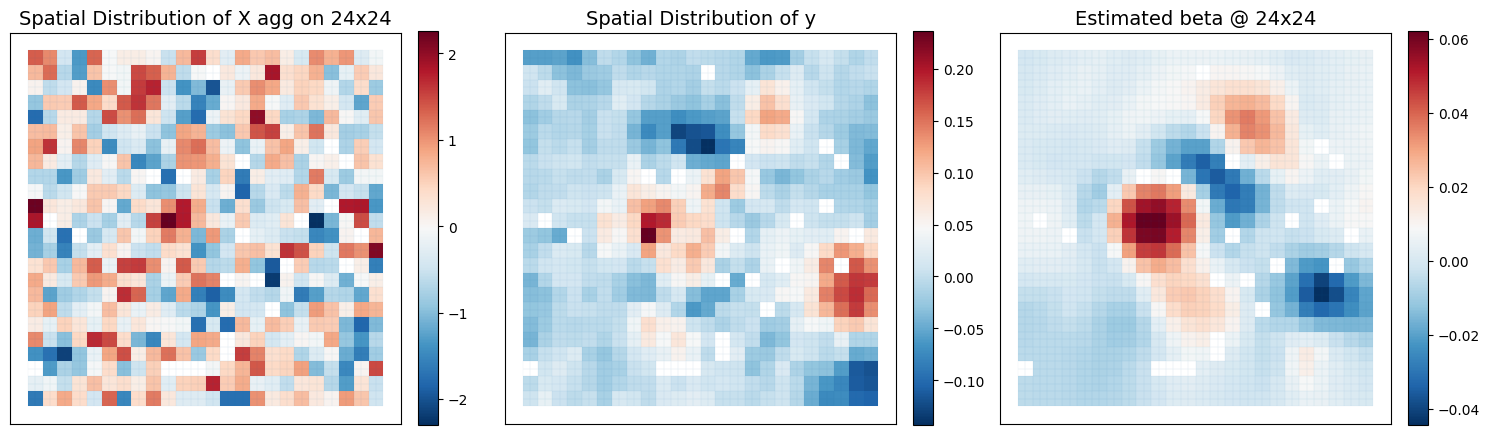

In [354]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
cmap1 = plt.cm.Reds
cmap2 = plt.cm.RdBu_r
cmap3 = plt.cm.RdBu_r

# Plot 1 - X_24x24
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[0])
plot1 = tracts_gdf48.plot(column="X_24x24", cmap=cmap2,
                          edgecolor="face", linewidth=0,
                          ax=ax[0], legend=False)
ax[0].set_title("Spatial Distribution of X agg on 24x24", fontsize=14)
ax[0].set_xticks([])
ax[0].set_yticks([])

# Colorbar for Plot 1
norm1 = mcolors.Normalize(vmin=tracts_gdf48["X_24x24"].min(), vmax=tracts_gdf48["X_24x24"].max())
sm1 = cm.ScalarMappable(cmap=cmap2, norm=norm1)
sm1.set_array([])
fig.colorbar(sm1, ax=ax[0], fraction=0.046, pad=0.04)

# Plot 2 - y_24x24
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[1])
plot2 = tracts_gdf48.plot(column="y_24x24", cmap=cmap2,
                          edgecolor="face", linewidth=0,
                          ax=ax[1], legend=False)
ax[1].set_title("Spatial Distribution of y", fontsize=14)
ax[1].set_xticks([])
ax[1].set_yticks([])

# Colorbar for Plot 2
norm2 = mcolors.Normalize(vmin=tracts_gdf48["y_24x24"].min(), vmax=tracts_gdf48["y_24x24"].max())
sm2 = cm.ScalarMappable(cmap=cmap2, norm=norm2)
sm2.set_array([])
fig.colorbar(sm2, ax=ax[1], fraction=0.046, pad=0.04)

# Plot 3 - est_beta24
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[2])
plot3 = tracts_gdf48.plot(column="est_beta24", cmap=cmap3,
                          edgecolor="face", linewidth=0,
                          ax=ax[2], legend=False)
ax[2].set_title("Estimated beta @ 24x24", fontsize=14)
ax[2].set_xticks([])
ax[2].set_yticks([])

# Colorbar for Plot 3
norm3 = mcolors.Normalize(vmin=tracts_gdf48["est_beta24"].min(), vmax=tracts_gdf48["est_beta24"].max())
sm3 = cm.ScalarMappable(cmap=cmap3, norm=norm3)
sm3.set_array([])
fig.colorbar(sm3, ax=ax[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


##### 16x16

In [355]:
sX1_16['params16'] = params16
sX1_16

tracts_gdf48_points = orig_tracts_gdf48.copy()
tracts_gdf48_points['geometry'] = tracts_gdf48_points['geometry'].centroid
spj16_48 = gpd.sjoin(tracts_gdf48_points, sX1_16, how='left', predicate='within')

In [356]:
tracts_gdf48["X_16x16"] = spj16_48["X"]
tracts_gdf48['y_16x16'] = spj16_48["y"]
tracts_gdf48['est_beta16'] = spj16_48["params16"]

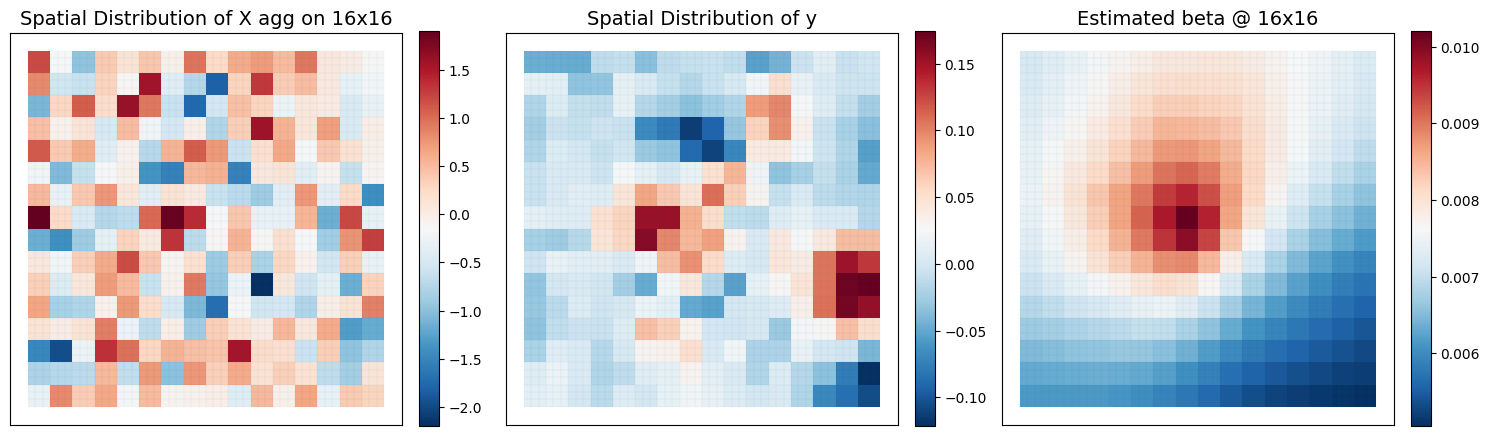

In [357]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
cmap1 = plt.cm.Reds
cmap2 = plt.cm.RdBu_r
cmap3 = plt.cm.RdBu_r

# Plot 1 - X_16x16
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[0])
plot1 = tracts_gdf48.plot(column="X_16x16", cmap=cmap2,
                          edgecolor="face", linewidth=0,
                          ax=ax[0], legend=False)
ax[0].set_title("Spatial Distribution of X agg on 16x16", fontsize=14)
ax[0].set_xticks([])
ax[0].set_yticks([])

# Colorbar for Plot 1
norm1 = mcolors.Normalize(vmin=tracts_gdf48["X_16x16"].min(), vmax=tracts_gdf48["X_16x16"].max())
sm1 = cm.ScalarMappable(cmap=cmap2, norm=norm1)
sm1.set_array([])
fig.colorbar(sm1, ax=ax[0], fraction=0.046, pad=0.04)

# Plot 2 - y_16x16
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[1])
plot2 = tracts_gdf48.plot(column="y_16x16", cmap=cmap2,
                          edgecolor="face", linewidth=0,
                          ax=ax[1], legend=False)
ax[1].set_title("Spatial Distribution of y", fontsize=14)
ax[1].set_xticks([])
ax[1].set_yticks([])

# Colorbar for Plot 2
norm2 = mcolors.Normalize(vmin=tracts_gdf48["y_16x16"].min(), vmax=tracts_gdf48["y_16x16"].max())
sm2 = cm.ScalarMappable(cmap=cmap2, norm=norm2)
sm2.set_array([])
fig.colorbar(sm2, ax=ax[1], fraction=0.046, pad=0.04)

# Plot 3 - est_beta16
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[2])
plot3 = tracts_gdf48.plot(column="est_beta16", cmap=cmap3,
                          edgecolor="face", linewidth=0,
                          ax=ax[2], legend=False)
ax[2].set_title("Estimated beta @ 16x16", fontsize=14)
ax[2].set_xticks([])
ax[2].set_yticks([])

# Colorbar for Plot 3
norm3 = mcolors.Normalize(vmin=tracts_gdf48["est_beta16"].min(), vmax=tracts_gdf48["est_beta16"].max())
sm3 = cm.ScalarMappable(cmap=cmap3, norm=norm3)
sm3.set_array([])
fig.colorbar(sm3, ax=ax[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


##### 12x12

In [358]:
sX1_12['params12'] = params12
sX1_12

tracts_gdf48_points = orig_tracts_gdf48.copy()
tracts_gdf48_points['geometry'] = tracts_gdf48_points['geometry'].centroid
spj12_48 = gpd.sjoin(tracts_gdf48_points, sX1_12, how='left', predicate='within')

In [359]:
tracts_gdf48["X_12x12"] = spj12_48["X"]
tracts_gdf48['y_12x12'] = spj12_48["y"]
tracts_gdf48['est_beta12'] = spj12_48["params12"]

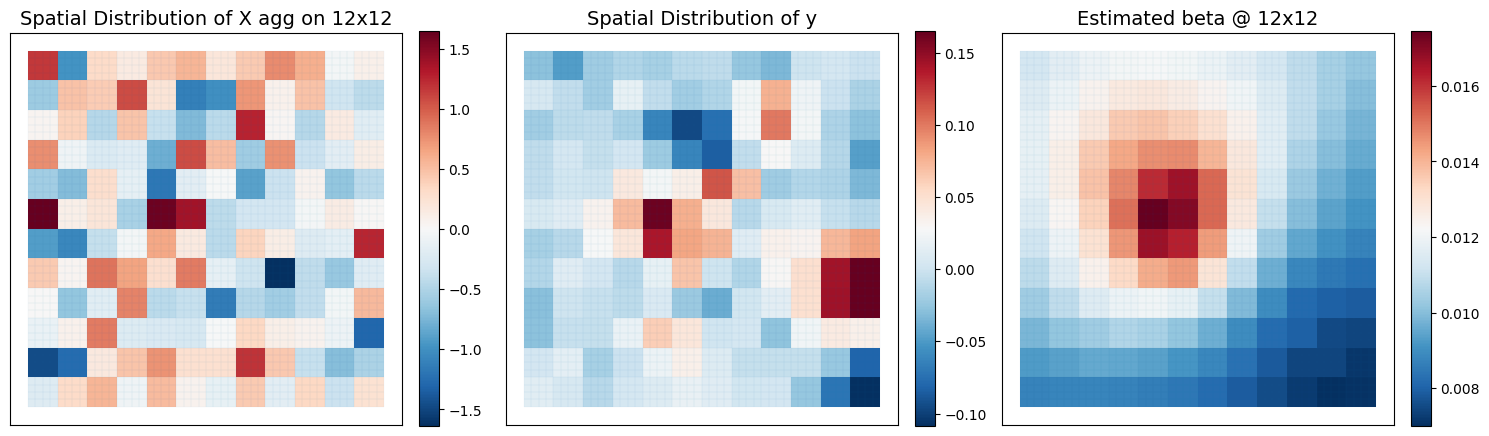

In [360]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
cmap1 = plt.cm.Reds
cmap2 = plt.cm.RdBu_r
cmap3 = plt.cm.RdBu_r

# Plot 1 - X_12x12
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[0])
plot1 = tracts_gdf48.plot(column="X_12x12", cmap=cmap2,
                          edgecolor="face", linewidth=0,
                          ax=ax[0], legend=False)
ax[0].set_title("Spatial Distribution of X agg on 12x12", fontsize=14)
ax[0].set_xticks([])
ax[0].set_yticks([])

# Colorbar for Plot 1
norm1 = mcolors.Normalize(vmin=tracts_gdf48["X_12x12"].min(), vmax=tracts_gdf48["X_12x12"].max())
sm1 = cm.ScalarMappable(cmap=cmap2, norm=norm1)
sm1.set_array([])
fig.colorbar(sm1, ax=ax[0], fraction=0.046, pad=0.04)

# Plot 2 - y_12x12
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[1])
plot2 = tracts_gdf48.plot(column="y_12x12", cmap=cmap2,
                          edgecolor="face", linewidth=0,
                          ax=ax[1], legend=False)
ax[1].set_title("Spatial Distribution of y", fontsize=14)
ax[1].set_xticks([])
ax[1].set_yticks([])

# Colorbar for Plot 2
norm2 = mcolors.Normalize(vmin=tracts_gdf48["y_12x12"].min(), vmax=tracts_gdf48["y_12x12"].max())
sm2 = cm.ScalarMappable(cmap=cmap2, norm=norm2)
sm2.set_array([])
fig.colorbar(sm2, ax=ax[1], fraction=0.046, pad=0.04)

# Plot 3 - est_beta12
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[2])
plot3 = tracts_gdf48.plot(column="est_beta12", cmap=cmap3,
                          edgecolor="face", linewidth=0,
                          ax=ax[2], legend=False)
ax[2].set_title("Estimated beta @ 12x12", fontsize=14)
ax[2].set_xticks([])
ax[2].set_yticks([])

# Colorbar for Plot 3
norm3 = mcolors.Normalize(vmin=tracts_gdf48["est_beta12"].min(), vmax=tracts_gdf48["est_beta12"].max())
sm3 = cm.ScalarMappable(cmap=cmap3, norm=norm3)
sm3.set_array([])
fig.colorbar(sm3, ax=ax[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


##### 8x8

In [361]:
sX1_8['params8'] = params8

tracts_gdf48_points = orig_tracts_gdf48.copy()
tracts_gdf48_points['geometry'] = tracts_gdf48_points['geometry'].centroid
spj8_48 = gpd.sjoin(tracts_gdf48_points, sX1_8, how='left', predicate='within')

In [362]:
tracts_gdf48["X_8x8"] = spj8_48["X"]
tracts_gdf48['y_8x8'] = spj8_48["y"]
tracts_gdf48['est_beta8'] = spj8_48["params8"]

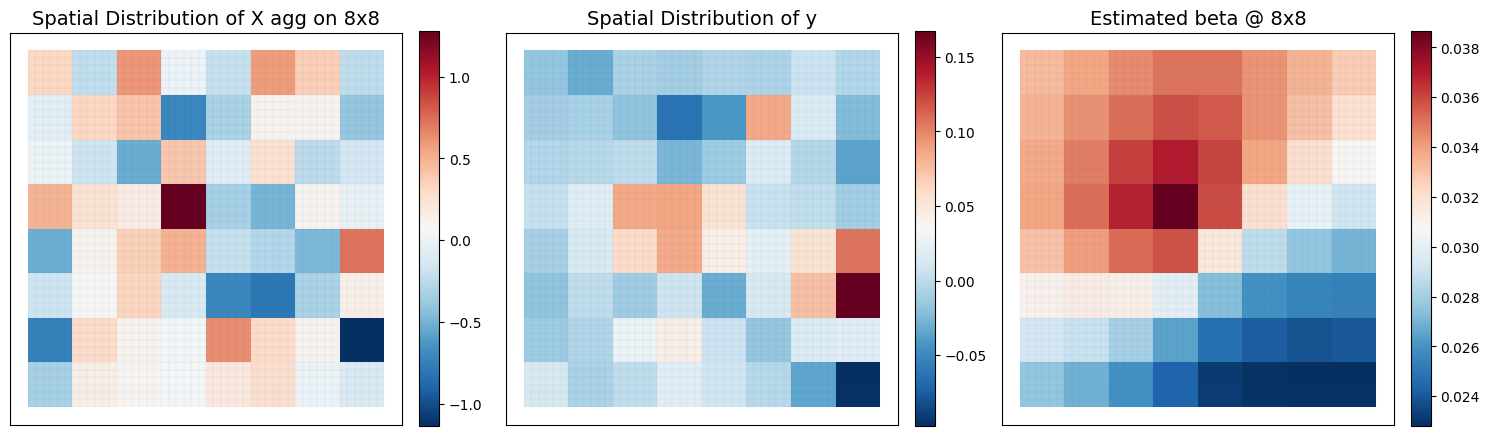

In [363]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
cmap1 = plt.cm.Reds
cmap2 = plt.cm.RdBu_r
cmap3 = plt.cm.RdBu_r

# Plot 1 - X_8x8
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[0])
plot1 = tracts_gdf48.plot(column="X_8x8", cmap=cmap2,
                          edgecolor="face", linewidth=0,
                          ax=ax[0], legend=False)
ax[0].set_title("Spatial Distribution of X agg on 8x8", fontsize=14)
ax[0].set_xticks([])
ax[0].set_yticks([])

# Colorbar for Plot 1
norm1 = mcolors.Normalize(vmin=tracts_gdf48["X_8x8"].min(), vmax=tracts_gdf48["X_8x8"].max())
sm1 = cm.ScalarMappable(cmap=cmap2, norm=norm1)
sm1.set_array([])
fig.colorbar(sm1, ax=ax[0], fraction=0.046, pad=0.04)

# Plot 2 - y_8x8
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[1])
plot2 = tracts_gdf48.plot(column="y_8x8", cmap=cmap2,
                          edgecolor="face", linewidth=0,
                          ax=ax[1], legend=False)
ax[1].set_title("Spatial Distribution of y", fontsize=14)
ax[1].set_xticks([])
ax[1].set_yticks([])

# Colorbar for Plot 2
norm2 = mcolors.Normalize(vmin=tracts_gdf48["y_8x8"].min(), vmax=tracts_gdf48["y_8x8"].max())
sm2 = cm.ScalarMappable(cmap=cmap2, norm=norm2)
sm2.set_array([])
fig.colorbar(sm2, ax=ax[1], fraction=0.046, pad=0.04)

# Plot 3 - est_beta8
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[2])
plot3 = tracts_gdf48.plot(column="est_beta8", cmap=cmap3,
                          edgecolor="face", linewidth=0,
                          ax=ax[2], legend=False)
ax[2].set_title("Estimated beta @ 8x8", fontsize=14)
ax[2].set_xticks([])
ax[2].set_yticks([])

# Colorbar for Plot 3
norm3 = mcolors.Normalize(vmin=tracts_gdf48["est_beta8"].min(), vmax=tracts_gdf48["est_beta8"].max())
sm3 = cm.ScalarMappable(cmap=cmap3, norm=norm3)
sm3.set_array([])
fig.colorbar(sm3, ax=ax[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


##### general visualization

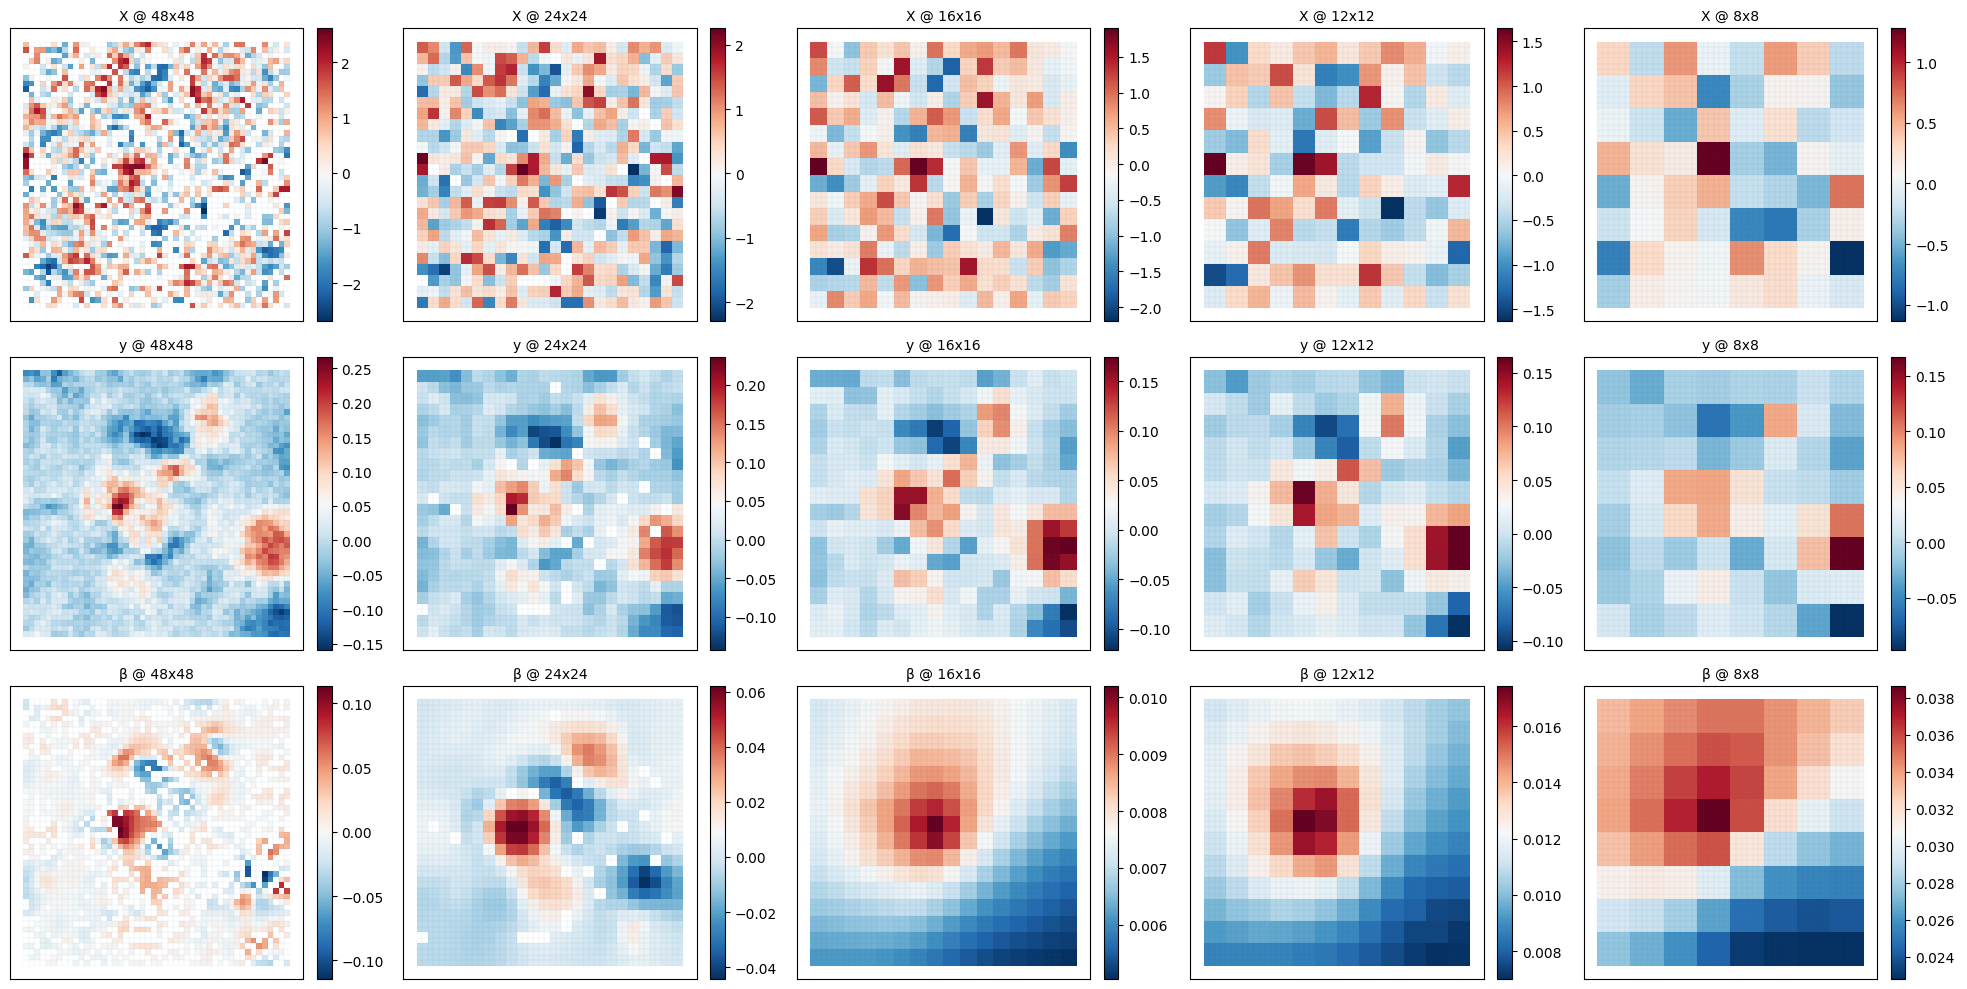

In [367]:
# Setup
res_labels = ["48x48", "24x24", "16x16", "12x12", "8x8"]
x_cols = ["X_48x48", "X_24x24", "X_16x16", "X_12x12", "X_8x8"]
y_cols = ["y_48x48", "y_24x24", "y_16x16", "y_12x12", "y_8x8"]
beta_cols = ["est_beta48", "est_beta24", "est_beta16", "est_beta12", "est_beta8"]
titles = ["X", "y", "β"]
cmap = plt.cm.RdBu_r

# Create a 3x5 grid
fig, axes = plt.subplots(3, 5, figsize=(20, 10))

# Loop through each row (X, y, β) and each column (resolutions)
for row, cols in enumerate([x_cols, y_cols, beta_cols]):
    for col, colname in enumerate(cols):
        ax = axes[row, col]
        
        # Base map (light boundary layer)
        tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax)
        
        # Choropleth plot
        tracts_gdf48.plot(column=colname, cmap=cmap, edgecolor="face", linewidth=0, ax=ax, legend=False)
        
        # Normalize for consistent colorbar
        norm = mcolors.Normalize(vmin=tracts_gdf48[colname].min(), vmax=tracts_gdf48[colname].max())
        sm = cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        fig.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
        
        # Title and layout tweaks
        ax.set_title(f"{titles[row]} @ {res_labels[col]}", fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])

plt.tight_layout()
plt.show()


##### 